---

# Section: 1.EDA and LSTM models(Uni, Bi and Stacked).ipynb


In [1]:
from google.colab import drive # import Colab's drive module to access Google Drive
drive.mount('/content/drive') # connect Google Drive to this notebook so we can open/save files

Mounted at /content/drive


In [2]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings as warn
warn.filterwarnings('ignore')
from sklearn.preprocessing import RobustScaler
import math
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Bidirectional
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error


# Importing and Saving the BTC-USD historical price data from Yahoo Finance

In [3]:
btc_cc = yf.download("BTC-USD", start="2014-09-17", end="2025-03-31", auto_adjust=False)
btc_cc


[*********************100%***********************]  1 of 1 completed


Price          Adj Close         Close          High           Low  \
Ticker           BTC-USD       BTC-USD       BTC-USD       BTC-USD   
Date                                                                 
2014-09-17    457.334015    457.334015    468.174011    452.421997   
2014-09-18    424.440002    424.440002    456.859985    413.104004   
2014-09-19    394.795990    394.795990    427.834991    384.532013   
2014-09-20    408.903992    408.903992    423.295990    389.882996   
2014-09-21    398.821014    398.821014    412.425995    393.181000   
...                  ...           ...           ...           ...   
2025-03-26  86900.882812  86900.882812  88292.156250  85861.453125   
2025-03-27  87177.101562  87177.101562  87786.726562  85837.937500   
2025-03-28  84353.148438  84353.148438  87489.859375  83557.640625   
2025-03-29  82597.585938  82597.585938  84567.335938  81634.140625   
2025-03-30  82334.523438  82334.523438  83505.000000  81573.250000   

Price               Open       Volume  
Ticker           BTC-USD      BTC-USD  
Date                                   
2014-09-17    465.864014     21056800  
2014-09-18    456.859985     34483200  
2014-09-19    424.102997     37919700  
2014-09-20    394.673004     36863600  
2014-09-21    408.084991     26580100  
...                  ...          ...  
2025-03-26  87460.234375  26704046038  
2025-03-27  86896.257812  24413471941  
2025-03-28  87185.234375  34198619509  
2025-03-29  84352.070312  16969396135  
2025-03-30  82596.984375  14763760943  

[3848 rows x 6 columns]

In [4]:
# Cleaning the multi-level column names
btc_cc.reset_index(inplace=True) # used for resetting the index to default numbers
btc_cc.columns = ['_'.join(filter(None, column_name)).strip() if isinstance(column_name, tuple) else column_name for column_name in btc_cc.columns]
btc_cc.columns = [column_name.replace('_BTC-USD', '') for column_name in btc_cc.columns] # used for removing '_BTC-USD' from column names
btc_cc

Date     Adj Close         Close          High           Low  \
0    2014-09-17    457.334015    457.334015    468.174011    452.421997   
1    2014-09-18    424.440002    424.440002    456.859985    413.104004   
2    2014-09-19    394.795990    394.795990    427.834991    384.532013   
3    2014-09-20    408.903992    408.903992    423.295990    389.882996   
4    2014-09-21    398.821014    398.821014    412.425995    393.181000   
...         ...           ...           ...           ...           ...   
3843 2025-03-26  86900.882812  86900.882812  88292.156250  85861.453125   
3844 2025-03-27  87177.101562  87177.101562  87786.726562  85837.937500   
3845 2025-03-28  84353.148438  84353.148438  87489.859375  83557.640625   
3846 2025-03-29  82597.585938  82597.585938  84567.335938  81634.140625   
3847 2025-03-30  82334.523438  82334.523438  83505.000000  81573.250000   

              Open       Volume  
0       465.864014     21056800  
1       456.859985     34483200  
2       424.102997     37919700  
3       394.673004     36863600  
4       408.084991     26580100  
...            ...          ...  
3843  87460.234375  26704046038  
3844  86896.257812  24413471941  
3845  87185.234375  34198619509  
3846  84352.070312  16969396135  
3847  82596.984375  14763760943  

[3848 rows x 7 columns]

In [5]:
btc_cc.to_csv('btc_usd.csv', index=False)
# used for saving the data to a CSV file without the index column


In [6]:
# used for showing column names, data types, and non-missing values
btc_cc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3848 entries, 0 to 3847
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Date       3848 non-null   datetime64[ns]
 1   Adj Close  3848 non-null   float64       
 2   Close      3848 non-null   float64       
 3   High       3848 non-null   float64       
 4   Low        3848 non-null   float64       
 5   Open       3848 non-null   float64       
 6   Volume     3848 non-null   int64         
dtypes: datetime64[ns](1), float64(5), int64(1)
memory usage: 210.6 KB


Viewing the Start and End Dates in this imported BTC historical crypto trading data

In [7]:
first_date = btc_cc['Date'].min()
last_date = btc_cc['Date'].max()

print("First trading date in this BTC historical data:", first_date.date())
print("Last trading date in this BTC historical data:", last_date.date())

First trading date in this BTC historical data: 2014-09-17
Last trading date in this BTC historical data: 2025-03-30


In [8]:
print("Minimum BTC Closing Price:", btc_cc['Close'].min())
print("Maximum BTC Closing Price:", btc_cc['Close'].max())
print("Minimum BTC Opening Price:", btc_cc['Open'].min())
print("Maximum BTC Opening Price:", btc_cc['Open'].max())
print("Lowest recorded BTC high price:", btc_cc['High'].min())
print("Highest recorded BTC high price:", btc_cc['High'].max())
print("Lowest recorded BTC low price:", btc_cc['Low'].min())
print("Highest recorded BTC low price:", btc_cc['Low'].max())
print("Lowest recorded BTC trading volume:", btc_cc['Volume'].min())
print("Highest recorded BTC trading volume:", btc_cc['Volume'].max())

Minimum BTC Closing Price: 178.10299682617188
Maximum BTC Closing Price: 106146.265625
Minimum BTC Opening Price: 176.89700317382812
Maximum BTC Opening Price: 106147.296875
Lowest recorded BTC high price: 211.7310028076172
Highest recorded BTC high price: 109114.8828125
Lowest recorded BTC low price: 171.50999450683594
Highest recorded BTC low price: 105291.734375
Lowest recorded BTC trading volume: 5914570
Highest recorded BTC trading volume: 350967941479


# Data Analysis - Visualisation

**Seasonal Decomposition of Time Series**

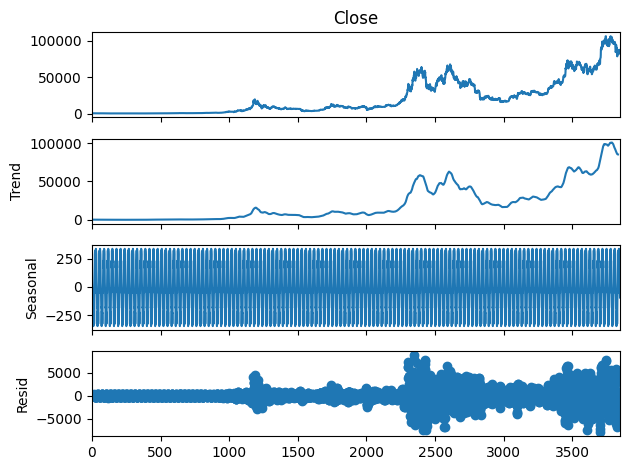

In [9]:
from statsmodels.tsa.seasonal import seasonal_decompose  # used for breaking time series into trend, seasonality, and residuals

decom = seasonal_decompose(btc_cc['Close'], model='additive', period=30)  # used for decomposing closing price with 30-day seasonality
decom.plot()  # used for plotting trend, seasonality, and residuals
plt.show()


This seasonal decomposition shows a strong upward trend in Bitcoin prices, a repeating seasonal pattern with consistent cycles, and residuals indicating increased volatility in recent years. It confirms non-stationarity and the presence of both trend and seasonality components.

**Rolling data - Moving Average - Average of the past 7 days**

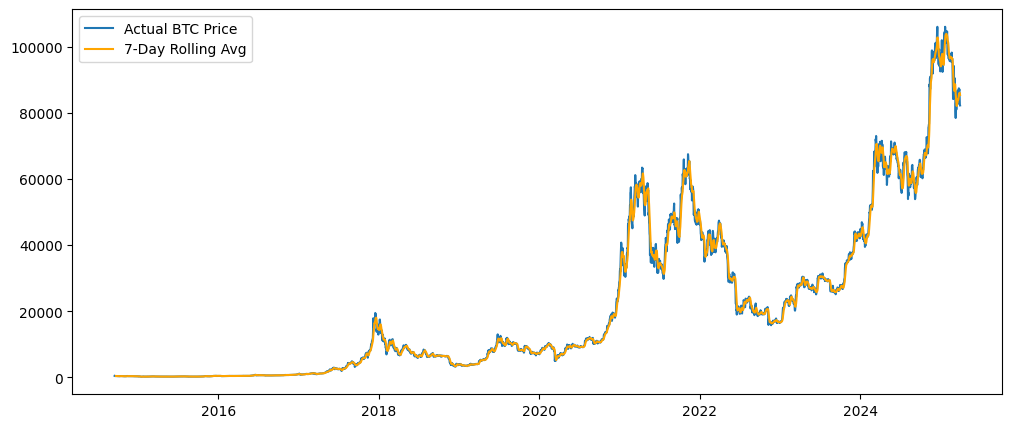

In [10]:
btc_cc['Rolling_7'] = btc_cc['Close'].rolling(window=7).mean()  # used for calculating 7-day moving average of closing price

plt.figure(figsize=(12,5))
plt.plot(btc_cc['Date'], btc_cc['Close'], label='Actual BTC Price')  # used for plotting actual BTC prices
plt.plot(btc_cc['Date'], btc_cc['Rolling_7'], label='7-Day Rolling Avg', color='orange')
plt.legend()
plt.show()



The plot compares actual Bitcoin prices with a 7-day rolling average. The rolling average smooths out short-term fluctuations, revealing the underlying trend. Both lines closely align, indicating strong short-term momentum and highlighting periodic price spikes and corrections.

**Bitcoin End-of-Month Closing Price Trend**

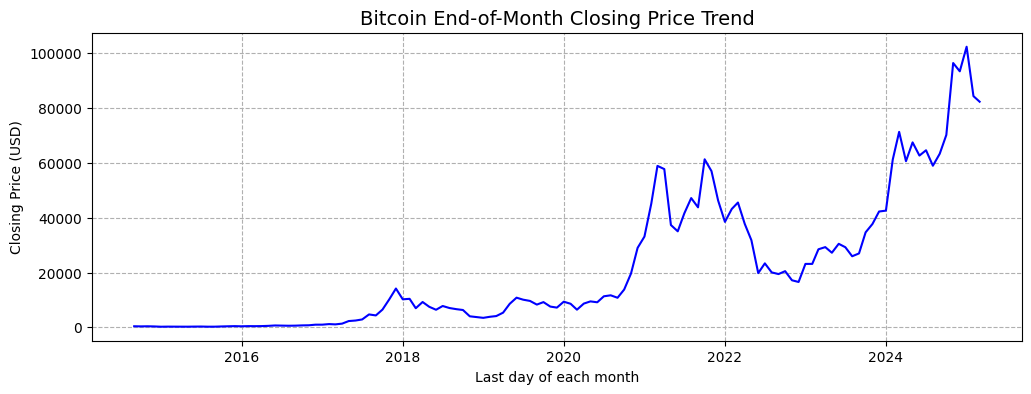

In [11]:
# Creating a new column for Year-Month and keeping the last entry of each month
btc_cc['YearMonth'] = btc_cc['Date'].dt.to_period('M')
monthly_data = btc_cc.groupby('YearMonth').last().reset_index()

# Converting YearMonth back to datetime for plotting
monthly_data['Date'] = monthly_data['YearMonth'].dt.to_timestamp()

plt.figure(figsize=(12, 4))
plt.plot(monthly_data['Date'], monthly_data['Close'], color='blue')
plt.title('Bitcoin End-of-Month Closing Price Trend', fontsize=14)
plt.xlabel('Last day of each month')
plt.ylabel('Closing Price (USD)')
plt.grid(True, linestyle='--')
plt.show()


The graph shows Bitcoins end-of-month closing price trend from 2014 to 2025. Prices remained low until 2017, followed by sharp fluctuations, peaking above $100,000 in 2024, indicating high volatility and rapid growth in recent years.

**Candle Stick Chart showing the monthly bitcoin price and the fluctuations**

In [12]:
pip install plotly

In [13]:
import plotly.graph_objects as go  # used for interactive charts

# Grouping the data by year & month, and getting the last entry of each month
month_end_data = btc_cc.groupby([btc_cc['Date'].dt.to_period('M')]).agg({
    'Date': 'last',
    'Open': 'first',
    'High': 'max',
    'Low': 'min',
    'Close': 'last'
}).reset_index(drop=True)

# Creating the candlestick chart
Chart = go.Figure(data=[go.Candlestick(
    x=month_end_data['Date'],
    open=month_end_data['Open'],
    high=month_end_data['High'],
    low=month_end_data['Low'],
    close=month_end_data['Close'],
    increasing_line_color='green',
    decreasing_line_color='red'
)])

Chart.update_layout(
    title='Candlestick Chart - Monthly BTC Price',
    xaxis_title='Last day of each month',
    yaxis_title='BTC Price (USD)',
    xaxis_rangeslider_visible=False
)
Chart.show()


Th candlestick chart above shows monthly BTC price movements from 2014 to 2025, highlighting high volatility, sharp uptrends in 2017 and 2021, and a peak above $100,000 in 2024.

**Candle stick chart for the months Feb and March 2025**

In [14]:
feb_mar = btc_cc[(btc_cc['Date'] >= '2025-02-01') & (btc_cc['Date'] <= '2025-03-31')]

# Creating the candlestick chart
Chart = go.Figure(data=[go.Candlestick(x=feb_mar['Date'],
                                       open=feb_mar['Open'],
                                       high=feb_mar['High'],
                                       low=feb_mar['Low'],
                                       close=feb_mar['Close'],
                                       increasing_line_color='green',
                                       decreasing_line_color='red')])

Chart.update_layout(title='Candlestick Chart - Daily BTC Price- Feb & March 2025',
                    xaxis_title='Date',
                    yaxis_title='BTC Price (USD)',
                    xaxis_rangeslider_visible=False)
Chart.show()

The candlestick above shows daily BTC price fluctuations from Feb to March 2025. The price fell from over $100k to around $85k, followed by minor recovery and sideways consolidation near month-end.

**Taking only the Date and Closing Price column for univariate time series analysis focused on BTC's closing price trend**

In [15]:
btc_cc = btc_cc[['Date', 'Close']]
btc_cc.to_csv('btc_usd(date&Close).csv', index=False)
btc_cc

Date         Close
0    2014-09-17    457.334015
1    2014-09-18    424.440002
2    2014-09-19    394.795990
3    2014-09-20    408.903992
4    2014-09-21    398.821014
...         ...           ...
3843 2025-03-26  86900.882812
3844 2025-03-27  87177.101562
3845 2025-03-28  84353.148438
3846 2025-03-29  82597.585938
3847 2025-03-30  82334.523438

[3848 rows x 2 columns]

# **Sliding window one-step ahead forecasting**

In [16]:
closing_prices = btc_cc['Close'].values
dates = btc_cc['Date'].values

# In this code 10 previous days will be used to predict the next day's price
window_size = 10

# Preparing the input (X), target (y), and target date using a sliding window
X, y, y_dates = [], [], []
for current_day_index in range(window_size, len(closing_prices)):
    ten_days_window = closing_prices[current_day_index - window_size:current_day_index]  # previous 10 days
    target_day = closing_prices[current_day_index]  # next day's price
    target_date = dates[current_day_index]  # next day's date

    X.append(ten_days_window)
    y.append(target_day)
    y_dates.append(target_date)

X = np.array(X)
y = np.array(y)
y_dates = np.array(y_dates)

print(f"Input shape (X): {X.shape}")
print(f"Target shape (y): {y.shape}")
print("Example input:", X[0])
print("Expected output:", y[0])

# Reshaping X
X = X.reshape((X.shape[0], X.shape[1], 1))
print(f"Reshaped input for LSTM: {X.shape}")

Input shape (X): (3838, 10)
Target shape (y): (3838,)
Example input: [457.33401489 424.44000244 394.79598999 408.9039917  398.8210144
 402.15200806 435.79098511 423.20498657 411.57400513 404.42498779]
Expected output: 399.5199890136719
Reshaped input for LSTM: (3838, 10, 1)


**DAta Splitting into Training and Testing**

In [17]:
split_date = np.datetime64('2025-01-01')
before_split_date = y_dates < split_date
from_2025_onward = y_dates >= split_date

# Splitting the dataset in to training and testing
X_train, X_test = X[before_split_date], X[from_2025_onward]
y_train, y_test = y[before_split_date], y[from_2025_onward]

print(f"\nTraining set of BTC closing prices:  X = {X_train.shape},  y = {y_train.shape}")
print(f"Testing set of BTC closing prices:   X = {X_test.shape},   y = {y_test.shape}")


Training set of BTC closing prices:  X = (3749, 10, 1),  y = (3749,)
Testing set of BTC closing prices:   X = (89, 10, 1),   y = (89,)


**Scaling the Data using Robust Scaler**

In [18]:
X_train_reshaped = X_train.reshape(-1, X_train.shape[-1])
X_test_reshaped = X_test.reshape(-1, X_test.shape[-1])

x_scaler = RobustScaler()
X_train_scaled = x_scaler.fit_transform(X_train_reshaped)
X_test_scaled = x_scaler.transform(X_test_reshaped)

X_train_scaled = X_train_scaled.reshape(X_train.shape)
X_test_scaled = X_test_scaled.reshape(X_test.shape)

y_scaler = RobustScaler()
y_train_scaled = y_scaler.fit_transform(y_train.reshape(-1, 1)).flatten()
y_test_scaled = y_scaler.transform(y_test.reshape(-1, 1)).flatten()

In [20]:
# Saving the full 3-month test set (after scaling) for using it in final code demonstration using saved model
np.savez("btc_test_3months_scaled.npz",
         X_test_scaled=X_test_scaled,
         y_test=y_test,  # original price ( this data is not scaled)
         y_scaler_center=y_scaler.center_,
         y_scaler_scale=y_scaler.scale_)

In [19]:
X_train_scaled

array([[[-0.30396439],
        [-0.30508881],
        [-0.30610215],
        ...,
        [-0.30513103],
        [-0.30552862],
        [-0.30577299]],

       [[-0.30508881],
        [-0.30610215],
        [-0.30561989],
        ...,
        [-0.30552862],
        [-0.30577299],
        [-0.30594066]],

       [[-0.30610215],
        [-0.30561989],
        [-0.30596456],
        ...,
        [-0.30577299],
        [-0.30594066],
        [-0.30670429]],

       ...,

       [[ 3.01297192],
        [ 3.02202971],
        [ 3.0038714 ],
        ...,
        [ 2.95501615],
        [ 2.89927482],
        [ 2.93342641]],

       [[ 3.02202971],
        [ 3.0038714 ],
        [ 2.93140986],
        ...,
        [ 2.89927482],
        [ 2.93342641],
        [ 2.87758093]],

       [[ 3.0038714 ],
        [ 2.93140986],
        [ 2.91709744],
        ...,
        [ 2.93342641],
        [ 2.87758093],
        [ 2.84725975]]])

In [20]:
y_test_scaled

array([2.89603143, 2.98004471, 3.02160852, 3.02599447, 3.02867563,
       3.15682214, 2.98126477, 2.91727266, 2.83011398, 2.90562407,
       2.90103167, 2.8983702 , 2.89932661, 2.96802978, 3.10323621,
       3.07777851, 3.23800342, 3.23616561, 3.12316134, 3.15473053,
       3.29535675, 3.21045543, 3.22091322, 3.25017558, 3.24660558,
       3.17740439, 3.15714911, 3.13143175, 3.21216288, 3.24730899,
       3.16795542, 3.10839235, 3.00735885, 3.13391577, 3.01358527,
       2.97080166, 2.97004743, 2.96786084, 2.96627285, 2.96687357,
       2.99879713, 2.94124293, 3.01406334, 2.97108845, 3.001229  ,
       3.00365982, 2.95580414, 2.94212672, 2.93416385, 2.97148831,
       3.02932184, 2.95411904, 2.96951828, 2.95917169, 2.79381778,
       2.70248705, 2.55302242, 2.56518634, 2.55390728, 2.61039837,
       2.8901945 , 2.61154793, 2.65093128, 2.76675877, 2.74422113,
       2.63460196, 2.61457601, 2.42545961, 2.35500217, 2.50245978,
       2.5317506 , 2.44131696, 2.54015297, 2.55288914, 2.49283

# **Unidirectional LSTM**

Epoch 1/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 8s 43ms/step - loss: 0.0401 - mae: 0.0991 - val_loss: 0.0282 - val_mae: 0.1187
Epoch 2/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 6s 54ms/step - loss: 0.0024 - mae: 0.0250 - val_loss: 0.0091 - val_mae: 0.0765
Epoch 3/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 0.0028 - mae: 0.0274 - val_loss: 0.0067 - val_mae: 0.0622
Epoch 4/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 0.0020 - mae: 0.0226 - val_loss: 0.0191 - val_mae: 0.0932
Epoch 5/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 0.0017 - mae: 0.0210 - val_loss: 0.0095 - val_mae: 0.0642
Epoch 6/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - loss: 0.0015 - mae: 0.0194 - val_loss: 0.0061 - val_mae: 0.0497
Epoch 7/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - loss: 0.0015 - mae: 0.0200 - val_loss: 0.0043 - val_mae: 0.0492
Epoch 8/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - loss: 0.0015 - mae: 0.0198 - val_loss: 0.0066 - val_mae: 0.0525
Epoch 9/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 0.001

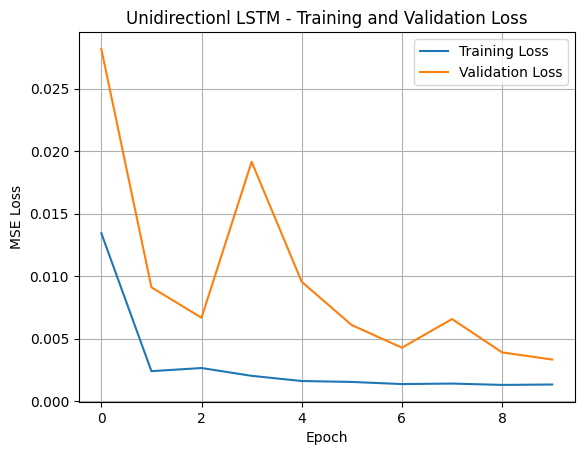

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step

 Metrics: Unidirectional LSTM:
MAE  - 2043.5068
MSE  - 7124371.6557
RMSE - 2669.1519
R²   - 0.8678
MAPE - 2.20%



In [21]:
# Building Uni-directional LSTM model for next-day price prediction
Uni_LSTM = Sequential()
Uni_LSTM.add(LSTM(300, activation='selu', input_shape=(window_size, 1)))
Uni_LSTM.add(Dense(1))
Uni_LSTM.compile(optimizer='adam', loss='mse', metrics=['mae'])

#Training the Uni-LSTM model
history_uni_lstm = Uni_LSTM.fit(X_train_scaled, y_train_scaled, epochs=10, batch_size=32, validation_split=0.2, verbose=1)

# Plotting training and validation loss over epochs
plt.plot(history_uni_lstm.history['loss'], label='Training Loss')
plt.plot(history_uni_lstm.history['val_loss'], label='Validation Loss')
plt.title('Unidirectionl LSTM - Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.legend()
plt.grid(True)
plt.show()

#saving the trained model
Uni_LSTM.save("btc_uni_lstm_model.keras")

#Predicting the closing price of BTC
y_pred = Uni_LSTM.predict(X_test_scaled).flatten()

# Inverse scaling
y_test_inverse = y_scaler.inverse_transform(y_test_scaled.reshape(-1, 1)).flatten()
y_pred_inverse = y_scaler.inverse_transform(y_pred.reshape(-1, 1)).flatten()

print(f"\n Metrics: Unidirectional LSTM:")
mae = mean_absolute_error(y_test_inverse, y_pred_inverse)
print(f"MAE  - {mae:.4f}")
mse = mean_squared_error(y_test_inverse, y_pred_inverse)
print(f"MSE  - {mse:.4f}")
rmse = math.sqrt(mse)
print(f"RMSE - {rmse:.4f}")
r2 = r2_score(y_test_inverse, y_pred_inverse)
print(f"R²   - {r2:.4f}")
mape = mean_absolute_percentage_error(y_test_inverse, y_pred_inverse) * 100
print(f"MAPE - {mape:.2f}%\n")


Some test predictions of Unidirectionl LSTM

Sample 1
Last 10 days input (closing btc price): [2.93140986 2.91709744 3.05348403 3.07478374 2.95501615 2.89927482
 2.93342641 2.87758093 2.84725975 2.87412761]
Actual BTC closing price      : 94419.7578125
Predicted BTC closing price   : 92466.84375

Sample 2
Last 10 days input (closing btc price): [2.91709744 3.05348403 3.07478374 2.95501615 2.89927482 2.93342641
 2.87758093 2.84725975 2.87412761 2.90798811]
Actual BTC closing price      : 96886.875
Predicted BTC closing price   : 93172.4140625

Sample 3
Last 10 days input (closing btc price): [3.05348403 3.07478374 2.95501615 2.89927482 2.93342641 2.87758093
 2.84725975 2.87412761 2.90798811 2.99232249]
Actual BTC closing price      : 98107.4296875
Predicted BTC closing price   : 94791.9140625

Sample 4
Last 10 days input (closing btc price): [3.07478374 2.95501615 2.89927482 2.93342641 2.87758093 2.84725975
 2.87412761 2.90798811 2.99232249 3.03404517]
Actual BTC closing price      : 9

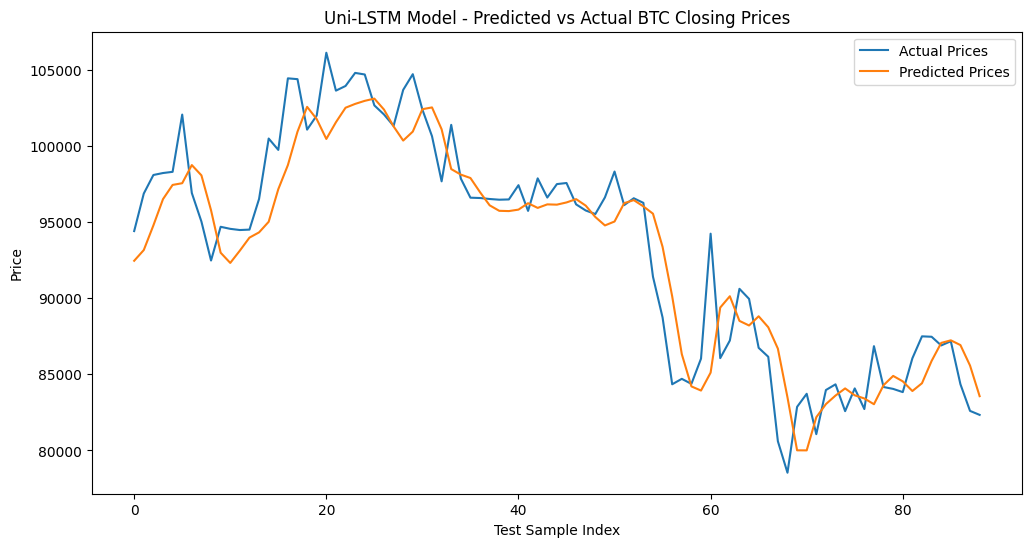

In [22]:
print("\nSome test predictions of Unidirectionl LSTM\n")

for day_index in range(5):
    print(f"Sample {day_index+1}")
    print("Last 10 days input (closing btc price):", X_test_scaled[day_index].flatten())
    print(f"Actual BTC closing price      : {y_test_inverse[day_index]}")
    print(f"Predicted BTC closing price   : {y_pred_inverse[day_index]}\n")

# Plotting actual vs predicted prices on test set
plt.figure(figsize=(12, 6))
plt.plot(y_test_inverse, label='Actual Prices')
plt.plot(y_pred_inverse, label='Predicted Prices')
plt.title('Uni-LSTM Model - Predicted vs Actual BTC Closing Prices')
plt.xlabel('Test Sample Index')
plt.ylabel('Price')
plt.legend()
plt.show()

# **Bidirectional LSTM**

Epoch 1/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 7s 49ms/step - loss: 0.0348 - mae: 0.0846 - val_loss: 0.0208 - val_mae: 0.0914
Epoch 2/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 4s 38ms/step - loss: 0.0029 - mae: 0.0291 - val_loss: 0.0329 - val_mae: 0.1212
Epoch 3/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 5s 38ms/step - loss: 0.0023 - mae: 0.0266 - val_loss: 0.0175 - val_mae: 0.0883
Epoch 4/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 4s 46ms/step - loss: 0.0024 - mae: 0.0280 - val_loss: 0.0107 - val_mae: 0.0659
Epoch 5/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 4s 39ms/step - loss: 0.0021 - mae: 0.0243 - val_loss: 0.0209 - val_mae: 0.1014
Epoch 6/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 4s 38ms/step - loss: 0.0021 - mae: 0.0255 - val_loss: 0.0098 - val_mae: 0.0646
Epoch 7/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 4s 46ms/step - loss: 0.0020 - mae: 0.0242 - val_loss: 0.0081 - val_mae: 0.0562
Epoch 8/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 4s 38ms/step - loss: 0.0015 - mae: 0.0213 - val_loss: 0.0110 - val_mae: 0.0685
Epoch 9/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 6s 45ms/step - loss: 0.001

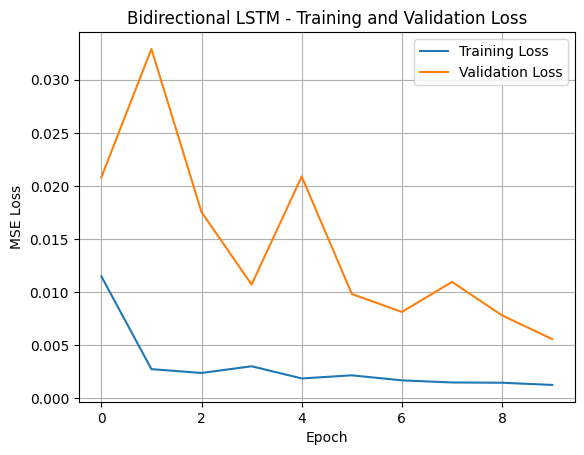

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 111ms/step

 Metrics: Bidirectional LSTM:
MAE  - 4315.9917
MSE  - 24393492.1041
RMSE - 4938.9768
R²   - 0.5473
MAPE - 4.54%



In [23]:
# Building Bi-directional LSTM model for next-day price prediction
Bi_LSTM = Sequential()
Bi_LSTM.add(Bidirectional(LSTM(300, activation='selu', input_shape=(window_size, 1))))
Bi_LSTM.add(Dense(1))
Bi_LSTM.compile(optimizer='adam', loss='mse', metrics=['mae'])

#Training the Bi-LSTM model
history_bi_lstm = Bi_LSTM.fit(X_train_scaled, y_train_scaled, epochs=10, batch_size=32, validation_split=0.2, verbose=1)

# Plotting training and validation loss over epochs
plt.plot(history_bi_lstm.history['loss'], label='Training Loss')
plt.plot(history_bi_lstm.history['val_loss'], label='Validation Loss')
plt.title('Bidirectional LSTM - Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.legend()
plt.grid(True)
plt.show()

#saving the trained model
Bi_LSTM.save("btc_bi_lstm_model.keras")

#Predicting the closing price of BTC
y_pred = Bi_LSTM.predict(X_test_scaled).flatten()

# Inverse scaling
y_test_inverse = y_scaler.inverse_transform(y_test_scaled.reshape(-1, 1)).flatten()
y_pred_inverse = y_scaler.inverse_transform(y_pred.reshape(-1, 1)).flatten()

print(f"\n Metrics: Bidirectional LSTM:")
mae = mean_absolute_error(y_test_inverse, y_pred_inverse)
print(f"MAE  - {mae:.4f}")
mse = mean_squared_error(y_test_inverse, y_pred_inverse)
print(f"MSE  - {mse:.4f}")
rmse = math.sqrt(mse)
print(f"RMSE - {rmse:.4f}")
r2 = r2_score(y_test_inverse, y_pred_inverse)
print(f"R²   - {r2:.4f}")
mape = mean_absolute_percentage_error(y_test_inverse, y_pred_inverse) * 100
print(f"MAPE - {mape:.2f}%\n")


Some test predictions of Bidirectionl LSTM

Sample 1
Last 10 days input (closing btc price): [2.93140986 2.91709744 3.05348403 3.07478374 2.95501615 2.89927482
 2.93342641 2.87758093 2.84725975 2.87412761]
Actual BTC closing price      : 94419.7578125
Predicted BTC closing price   : 88549.046875

Sample 2
Last 10 days input (closing btc price): [2.91709744 3.05348403 3.07478374 2.95501615 2.89927482 2.93342641
 2.87758093 2.84725975 2.87412761 2.90798811]
Actual BTC closing price      : 96886.875
Predicted BTC closing price   : 89316.0625

Sample 3
Last 10 days input (closing btc price): [3.05348403 3.07478374 2.95501615 2.89927482 2.93342641 2.87758093
 2.84725975 2.87412761 2.90798811 2.99232249]
Actual BTC closing price      : 98107.4296875
Predicted BTC closing price   : 91047.0625

Sample 4
Last 10 days input (closing btc price): [3.07478374 2.95501615 2.89927482 2.93342641 2.87758093 2.84725975
 2.87412761 2.90798811 2.99232249 3.03404517]
Actual BTC closing price      : 98236.2

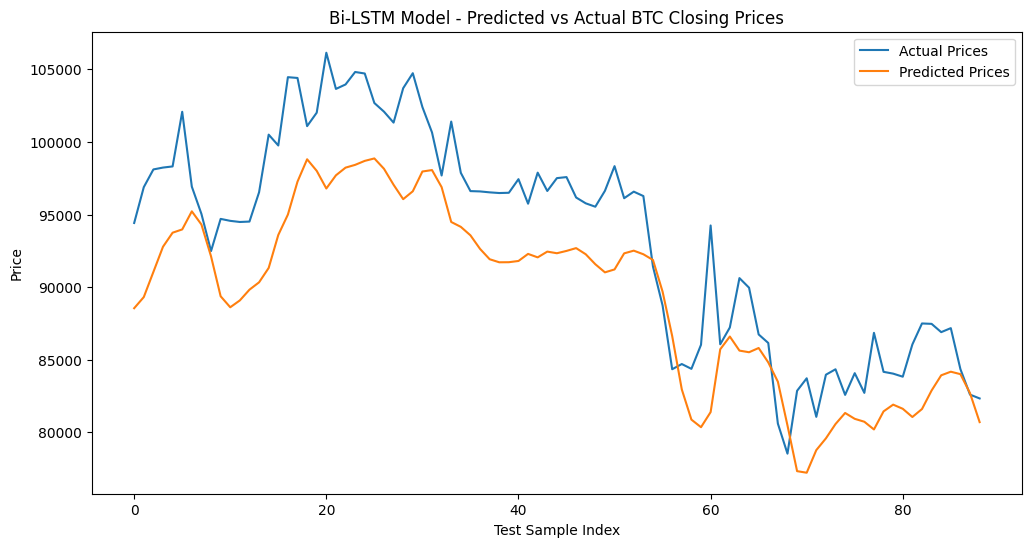

In [24]:
print("\nSome test predictions of Bidirectionl LSTM\n")

for day_index in range(5):
    print(f"Sample {day_index+1}")
    print("Last 10 days input (closing btc price):", X_test_scaled[day_index].flatten())
    print(f"Actual BTC closing price      : {y_test_inverse[day_index]}")
    print(f"Predicted BTC closing price   : {y_pred_inverse[day_index]}\n")

# Plotting actual vs predicted prices on test set
plt.figure(figsize=(12, 6))
plt.plot(y_test_inverse, label='Actual Prices')
plt.plot(y_pred_inverse, label='Predicted Prices')
plt.title('Bi-LSTM Model - Predicted vs Actual BTC Closing Prices')
plt.xlabel('Test Sample Index')
plt.ylabel('Price')
plt.legend()
plt.show()

# **Stacked LSTM**

Epoch 1/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 6s 42ms/step - loss: 0.0420 - mae: 0.1003 - val_loss: 0.0391 - val_mae: 0.1189
Epoch 2/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 3s 36ms/step - loss: 0.0027 - mae: 0.0274 - val_loss: 0.0118 - val_mae: 0.0678
Epoch 3/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - loss: 0.0030 - mae: 0.0289 - val_loss: 0.0108 - val_mae: 0.0745
Epoch 4/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 4s 36ms/step - loss: 0.0022 - mae: 0.0257 - val_loss: 0.0080 - val_mae: 0.0593
Epoch 5/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 6s 43ms/step - loss: 0.0016 - mae: 0.0208 - val_loss: 0.0058 - val_mae: 0.0603
Epoch 6/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 4s 35ms/step - loss: 0.0018 - mae: 0.0255 - val_loss: 0.0046 - val_mae: 0.0458
Epoch 7/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 5s 36ms/step - loss: 0.0012 - mae: 0.0195 - val_loss: 0.0341 - val_mae: 0.1431
Epoch 8/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - loss: 0.0019 - mae: 0.0243 - val_loss: 0.0071 - val_mae: 0.0539
Epoch 9/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - loss: 0.001

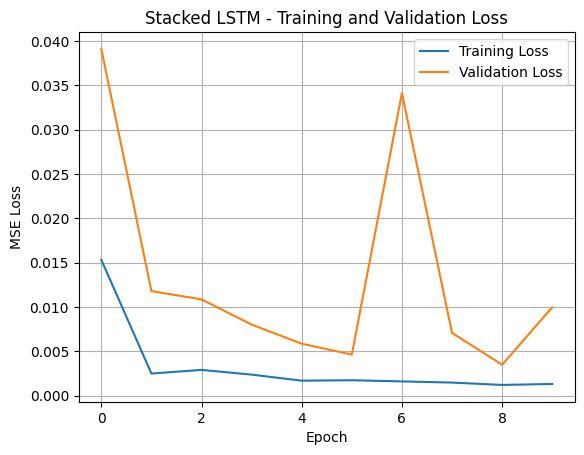

1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 279ms/step

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 148ms/step

 Metrics: Stacked LSTM:
MAE  - 6127.4449
MSE  - 44256165.8086
RMSE - 6652.5308
R²   - 0.1787
MAPE - 6.46%



In [25]:
# Building Stacked LSTM model for next-day price prediction
stacked_LSTM = Sequential()
stacked_LSTM.add(LSTM(300, activation='selu', return_sequences=True, input_shape=(window_size, 1)))
stacked_LSTM.add(LSTM(150, activation='selu'))
stacked_LSTM.add(Dense(1))
stacked_LSTM.compile(optimizer='adam', loss='mse', metrics=['mae'])

#Training the Stacked LSTM model
history_stacked_lstm = stacked_LSTM.fit(X_train_scaled, y_train_scaled, epochs=10, batch_size=32, validation_split=0.2, verbose=1)

# Plotting training and validation loss over epochs
plt.plot(history_stacked_lstm.history['loss'], label='Training Loss')
plt.plot(history_stacked_lstm.history['val_loss'], label='Validation Loss')
plt.title('Stacked LSTM - Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.legend()
plt.grid(True)
plt.show()

#saving the trained model
stacked_LSTM.save("btc_stacked_lstm_model.keras")

#Predicting the closing price of BTC
y_pred = stacked_LSTM.predict(X_test_scaled).flatten()

# Inverse scaling
y_test_inverse = y_scaler.inverse_transform(y_test_scaled.reshape(-1, 1)).flatten()
y_pred_inverse = y_scaler.inverse_transform(y_pred.reshape(-1, 1)).flatten()

print(f"\n Metrics: Stacked LSTM:")
mae = mean_absolute_error(y_test_inverse, y_pred_inverse)
print(f"MAE  - {mae:.4f}")
mse = mean_squared_error(y_test_inverse, y_pred_inverse)
print(f"MSE  - {mse:.4f}")
rmse = math.sqrt(mse)
print(f"RMSE - {rmse:.4f}")
r2 = r2_score(y_test_inverse, y_pred_inverse)
print(f"R²   - {r2:.4f}")
mape = mean_absolute_percentage_error(y_test_inverse, y_pred_inverse) * 100
print(f"MAPE - {mape:.2f}%\n")


Checking some test predictions - Stacked LSTM

Sample 1
Last 10 days input (closing price): [2.93140986 2.91709744 3.05348403 3.07478374 2.95501615 2.89927482
 2.93342641 2.87758093 2.84725975 2.87412761]
Actual BTC closing price      : 94419.7578125
Predicted BTC closing price   : 86889.9375

Sample 2
Last 10 days input (closing price): [2.91709744 3.05348403 3.07478374 2.95501615 2.89927482 2.93342641
 2.87758093 2.84725975 2.87412761 2.90798811]
Actual BTC closing price      : 96886.875
Predicted BTC closing price   : 87682.3203125

Sample 3
Last 10 days input (closing price): [3.05348403 3.07478374 2.95501615 2.89927482 2.93342641 2.87758093
 2.84725975 2.87412761 2.90798811 2.99232249]
Actual BTC closing price      : 98107.4296875
Predicted BTC closing price   : 89430.75

Sample 4
Last 10 days input (closing price): [3.07478374 2.95501615 2.89927482 2.93342641 2.87758093 2.84725975
 2.87412761 2.90798811 2.99232249 3.03404517]
Actual BTC closing price      : 98236.2265625
Predict

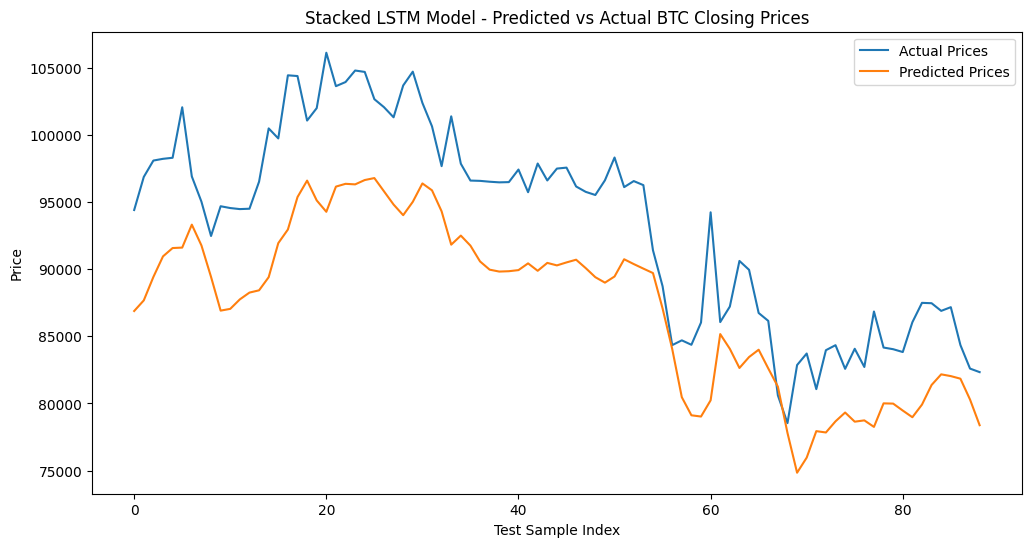

In [26]:
print("\nChecking some test predictions - Stacked LSTM\n")

for day_index in range(5):
    print(f"Sample {day_index+1}")
    print("Last 10 days input (closing price):", X_test_scaled[day_index].flatten())
    print(f"Actual BTC closing price      : {y_test_inverse[day_index]}")
    print(f"Predicted BTC closing price   : {y_pred_inverse[day_index]}\n")

# Plotting actual vs predicted prices on test set
plt.figure(figsize=(12, 6))
plt.plot(y_test_inverse, label='Actual Prices')
plt.plot(y_pred_inverse, label='Predicted Prices')
plt.title('Stacked LSTM Model - Predicted vs Actual BTC Closing Prices')
plt.xlabel('Test Sample Index')
plt.ylabel('Price')
plt.legend()
plt.show()

---

# Section: 2. Time Series Transformer Model with varying Attention Blocks.ipynb


In [27]:
import pandas as pd
import matplotlib.pyplot as plt
import warnings as warn
warn.filterwarnings('ignore')
import numpy as np
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error
import math
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, GlobalAveragePooling1D, Attention, Concatenate, Lambda
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

In [28]:
btc_cc = pd.read_csv('btc_usd(date&Close).csv')
btc_cc

Date         Close
0     2014-09-17    457.334015
1     2014-09-18    424.440002
2     2014-09-19    394.795990
3     2014-09-20    408.903992
4     2014-09-21    398.821014
...          ...           ...
3843  2025-03-26  86900.882812
3844  2025-03-27  87177.101562
3845  2025-03-28  84353.148438
3846  2025-03-29  82597.585938
3847  2025-03-30  82334.523438

[3848 rows x 2 columns]

In [29]:
btc_cc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3848 entries, 0 to 3847
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    3848 non-null   object 
 1   Close   3848 non-null   float64
dtypes: float64(1), object(1)
memory usage: 60.3+ KB


Converting the strings in the Date column to datetime format

In [30]:
btc_cc['Date'] = pd.to_datetime(btc_cc['Date'])

# **Sliding window one-step ahead forecasting**

In [31]:
closing_prices = btc_cc['Close'].values
dates = btc_cc['Date'].values

# In this code 10 previous days will be used to predict the next day's price
window_size = 10

# Preparing the input (X), target (y), and target date using a sliding window
X, y, y_dates = [], [], []
for current_day_index in range(window_size, len(closing_prices)):
    ten_days_window = closing_prices[current_day_index - window_size:current_day_index]  # previous 10 days
    target_day = closing_prices[current_day_index]  # next day's price
    target_date = dates[current_day_index]  # next day's date

    X.append(ten_days_window)
    y.append(target_day)
    y_dates.append(target_date)

X = np.array(X)
y = np.array(y)
y_dates = np.array(y_dates)

print(f"Input shape (X): {X.shape}")
print(f"Target shape (y): {y.shape}")
print("Example input:", X[0])
print("Expected output:", y[0])

# Reshaping X
X = X.reshape((X.shape[0], X.shape[1], 1))
print(f"Reshaped input for Transformer: {X.shape}")

Input shape (X): (3838, 10)
Target shape (y): (3838,)
Example input: [457.33401489 424.44000244 394.79598999 408.9039917  398.8210144
 402.15200806 435.79098511 423.20498657 411.57400513 404.42498779]
Expected output: 399.5199890136719
Reshaped input for Transformer: (3838, 10, 1)


**DAta Splitting into Training and Testing**

In [32]:
split_date = np.datetime64('2025-01-01')
before_split_date = y_dates < split_date
from_2025_onward = y_dates >= split_date

# Splitting the dataset in to training and testing
X_train, X_test = X[before_split_date], X[from_2025_onward]
y_train, y_test = y[before_split_date], y[from_2025_onward]

print(f"\nTraining set of BTC closing prices:  X = {X_train.shape},  y = {y_train.shape}")
print(f"Testing set of BTC closing prices:   X = {X_test.shape},   y = {y_test.shape}")


Training set of BTC closing prices:  X = (3749, 10, 1),  y = (3749,)
Testing set of BTC closing prices:   X = (89, 10, 1),   y = (89,)


**Scaling the Data using Robust Scaler**

In [33]:
X_train_reshaped = X_train.reshape(-1, X_train.shape[-1])
X_test_reshaped = X_test.reshape(-1, X_test.shape[-1])

x_scaler = RobustScaler()
X_train_scaled = x_scaler.fit_transform(X_train_reshaped)
X_test_scaled = x_scaler.transform(X_test_reshaped)

X_train_scaled = X_train_scaled.reshape(X_train.shape)
X_test_scaled = X_test_scaled.reshape(X_test.shape)

y_scaler = RobustScaler()
y_train_scaled = y_scaler.fit_transform(y_train.reshape(-1, 1)).flatten()
y_test_scaled = y_scaler.transform(y_test.reshape(-1, 1)).flatten()

In [34]:
X_train_scaled

array([[[-0.30396439],
        [-0.30508881],
        [-0.30610215],
        ...,
        [-0.30513103],
        [-0.30552862],
        [-0.30577299]],

       [[-0.30508881],
        [-0.30610215],
        [-0.30561989],
        ...,
        [-0.30552862],
        [-0.30577299],
        [-0.30594066]],

       [[-0.30610215],
        [-0.30561989],
        [-0.30596456],
        ...,
        [-0.30577299],
        [-0.30594066],
        [-0.30670429]],

       ...,

       [[ 3.01297192],
        [ 3.02202971],
        [ 3.0038714 ],
        ...,
        [ 2.95501615],
        [ 2.89927482],
        [ 2.93342641]],

       [[ 3.02202971],
        [ 3.0038714 ],
        [ 2.93140986],
        ...,
        [ 2.89927482],
        [ 2.93342641],
        [ 2.87758093]],

       [[ 3.0038714 ],
        [ 2.93140986],
        [ 2.91709744],
        ...,
        [ 2.93342641],
        [ 2.87758093],
        [ 2.84725975]]])

In [35]:
y_test_scaled

array([2.89603143, 2.98004471, 3.02160852, 3.02599447, 3.02867563,
       3.15682214, 2.98126477, 2.91727266, 2.83011398, 2.90562407,
       2.90103167, 2.8983702 , 2.89932661, 2.96802978, 3.10323621,
       3.07777851, 3.23800342, 3.23616561, 3.12316134, 3.15473053,
       3.29535675, 3.21045543, 3.22091322, 3.25017558, 3.24660558,
       3.17740439, 3.15714911, 3.13143175, 3.21216288, 3.24730899,
       3.16795542, 3.10839235, 3.00735885, 3.13391577, 3.01358527,
       2.97080166, 2.97004743, 2.96786084, 2.96627285, 2.96687357,
       2.99879713, 2.94124293, 3.01406334, 2.97108845, 3.001229  ,
       3.00365982, 2.95580414, 2.94212672, 2.93416385, 2.97148831,
       3.02932184, 2.95411904, 2.96951828, 2.95917169, 2.79381778,
       2.70248705, 2.55302242, 2.56518634, 2.55390728, 2.61039837,
       2.8901945 , 2.61154793, 2.65093128, 2.76675877, 2.74422113,
       2.63460196, 2.61457601, 2.42545961, 2.35500217, 2.50245978,
       2.5317506 , 2.44131696, 2.54015297, 2.55288914, 2.49283

# **Transformer Regression Model**

In [36]:
#Building a Transformer-style model for Bitcoin price prediction using block-wise attention

def BTC_Transformer(input_shape, num_blocks):
    input_layer = Input(shape=input_shape)
    block_attention_outputs = []

    time_steps = input_shape[0]
    block_size = time_steps // num_blocks

    # Go through the input in blocks
    for block_index in range(num_blocks):
        start_index = block_index * block_size
        end_index = (block_index + 1) * block_size
        time_block = Lambda(lambda x: x[:, start_index:end_index, :])(input_layer)
        attention_output = Attention()([time_block, time_block])
        block_attention_outputs.append(attention_output)

    merged_blocks = Concatenate(axis=1)(block_attention_outputs)
    compressed_time_vector = GlobalAveragePooling1D()(merged_blocks)
    output_layer = Dense(1)(compressed_time_vector) #(eg: next BTC price)

    # Build and return the transformer model
    transformer_model = Model(inputs=input_layer, outputs=output_layer)
    return transformer_model

In [37]:
input_shape = X_train.shape[1:]
epochs = 50
batch_size = 32

**Transformer with one attention block**

Epoch 1/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0188 - mae: 0.0950 - val_loss: 0.0646 - val_mae: 0.2051
Epoch 2/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0093 - mae: 0.0686 - val_loss: 0.0301 - val_mae: 0.1331
Epoch 3/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0055 - mae: 0.0488 - val_loss: 0.0164 - val_mae: 0.0931
Epoch 4/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0038 - mae: 0.0358 - val_loss: 0.0105 - val_mae: 0.0714
Epoch 5/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0027 - mae: 0.0292 - val_loss: 0.0087 - val_mae: 0.0645
Epoch 6/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0028 - mae: 0.0271 - val_loss: 0.0081 - val_mae: 0.0622
Epoch 7/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0031 - mae: 0.0282 - val_loss: 0.0080 - val_mae: 0.0617
Epoch 8/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0027 - mae: 0.0256 - val_loss: 0.0079 - val_mae: 0.0613
Epoch 9/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0031 - mae: 

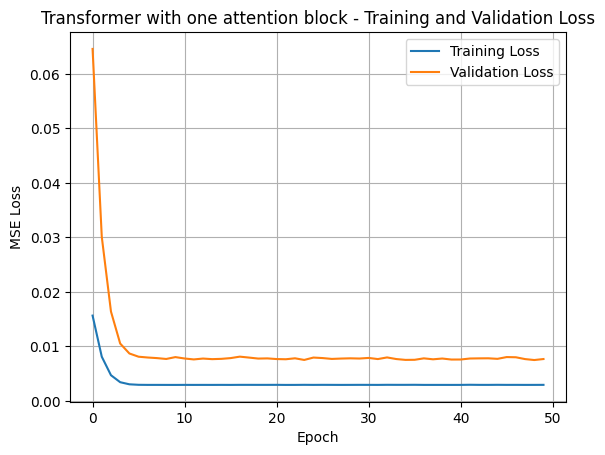

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step

 Metrics: Transformer with one attention block:
MAE  - 2873.4041
MSE  - 14373931.5400
RMSE - 3791.2968
R²   - 0.7332
MAPE - 3.14%



In [38]:
one_block_transformer = BTC_Transformer(input_shape, num_blocks=1)
one_block_transformer.compile(optimizer=Adam(learning_rate=0.001), loss='mse', metrics=['mae'])
history_one_block_transformer = one_block_transformer.fit(X_train_scaled, y_train_scaled, epochs=epochs, batch_size=batch_size, validation_split=0.2, verbose=1)

# Plotting training and validation loss over epochs
plt.plot(history_one_block_transformer.history['loss'], label='Training Loss')
plt.plot(history_one_block_transformer.history['val_loss'], label='Validation Loss')
plt.title('Transformer with one attention block - Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.legend()
plt.grid(True)
plt.show()

#saving the trained model
one_block_transformer.save("btc_one_block_transformer_model.keras")

#Predicting the closing price of BTC
y_pred = one_block_transformer.predict(X_test_scaled).flatten()
y_test_inverse = y_scaler.inverse_transform(y_test_scaled.reshape(-1, 1)).flatten()
y_pred_inverse = y_scaler.inverse_transform(y_pred.reshape(-1, 1)).flatten()

print(f"\n Metrics: Transformer with one attention block:")
mae = mean_absolute_error(y_test_inverse, y_pred_inverse)
print(f"MAE  - {mae:.4f}")
mse = mean_squared_error(y_test_inverse, y_pred_inverse)
print(f"MSE  - {mse:.4f}")
rmse = math.sqrt(mse)
print(f"RMSE - {rmse:.4f}")
r2 = r2_score(y_test_inverse, y_pred_inverse)
print(f"R²   - {r2:.4f}")
mape = mean_absolute_percentage_error(y_test_inverse, y_pred_inverse) * 100
print(f"MAPE - {mape:.2f}%\n")


Some test predictions of Transformer with one attenton block

Sample 1
Last 10 days input (closing btc price): [2.93140986 2.91709744 3.05348403 3.07478374 2.95501615 2.89927482
 2.93342641 2.87758093 2.84725975 2.87412761]
Actual BTC closing price      : 94419.7578125
Predicted BTC closing price   : 95175.7265625

Sample 2
Last 10 days input (closing btc price): [2.91709744 3.05348403 3.07478374 2.95501615 2.89927482 2.93342641
 2.87758093 2.84725975 2.87412761 2.90798811]
Actual BTC closing price      : 96886.875
Predicted BTC closing price   : 95117.6328125

Sample 3
Last 10 days input (closing btc price): [3.05348403 3.07478374 2.95501615 2.89927482 2.93342641 2.87758093
 2.84725975 2.87412761 2.90798811 2.99232249]
Actual BTC closing price      : 98107.4296875
Predicted BTC closing price   : 95345.03125

Sample 4
Last 10 days input (closing btc price): [3.07478374 2.95501615 2.89927482 2.93342641 2.87758093 2.84725975
 2.87412761 2.90798811 2.99232249 3.03404517]
Actual BTC closi

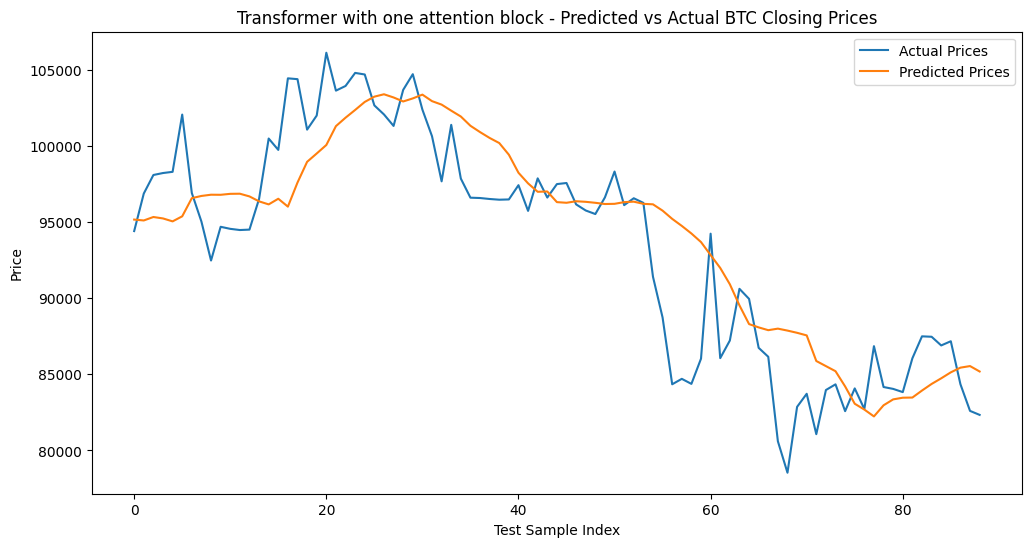

In [39]:
print("\nSome test predictions of Transformer with one attenton block\n")

for day_index in range(5):
    print(f"Sample {day_index+1}")
    print("Last 10 days input (closing btc price):", X_test_scaled[day_index].flatten())
    print(f"Actual BTC closing price      : {y_test_inverse[day_index]}")
    print(f"Predicted BTC closing price   : {y_pred_inverse[day_index]}\n")

# Plotting actual vs predicted prices on test set
plt.figure(figsize=(12, 6))
plt.plot(y_test_inverse, label='Actual Prices')
plt.plot(y_pred_inverse, label='Predicted Prices')
plt.title('Transformer with one attention block - Predicted vs Actual BTC Closing Prices')
plt.xlabel('Test Sample Index')
plt.ylabel('Price')
plt.legend()
plt.show()

**Transformer with two attention blocks**

Epoch 1/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0221 - mae: 0.1015 - val_loss: 0.0751 - val_mae: 0.2250
Epoch 2/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0100 - mae: 0.0749 - val_loss: 0.0342 - val_mae: 0.1468
Epoch 3/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0052 - mae: 0.0519 - val_loss: 0.0161 - val_mae: 0.0958
Epoch 4/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0028 - mae: 0.0349 - val_loss: 0.0086 - val_mae: 0.0665
Epoch 5/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0019 - mae: 0.0266 - val_loss: 0.0060 - val_mae: 0.0535
Epoch 6/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0018 - mae: 0.0230 - val_loss: 0.0050 - val_mae: 0.0481
Epoch 7/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0017 - mae: 0.0211 - val_loss: 0.0047 - val_mae: 0.0461
Epoch 8/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0016 - mae: 0.0194 - val_loss: 0.0047 - val_mae: 0.0461
Epoch 9/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0014 - mae: 

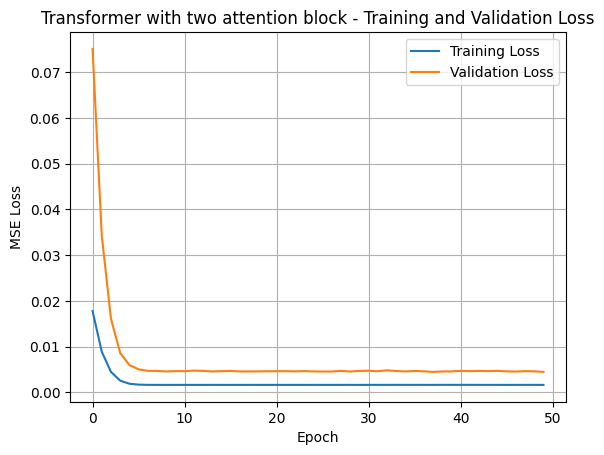

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step

 Metrics: Transformer with two attention block:
MAE  - 2467.4262
MSE  - 11457947.6690
RMSE - 3384.9590
R²   - 0.7874
MAPE - 2.70%



In [40]:
two_block_transformer = BTC_Transformer(input_shape, num_blocks=2)
two_block_transformer.compile(optimizer=Adam(learning_rate=0.001), loss='mse', metrics=['mae'])
history_two_block_transformer = two_block_transformer.fit(X_train_scaled, y_train_scaled, epochs=epochs, batch_size=batch_size, validation_split=0.2, verbose=1)

# Plotting training and validation loss over epochs
plt.plot(history_two_block_transformer.history['loss'], label='Training Loss')
plt.plot(history_two_block_transformer.history['val_loss'], label='Validation Loss')
plt.title('Transformer with two attention block - Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.legend()
plt.grid(True)
plt.show()

#saving the trained model
two_block_transformer.save("btc_two_block_transformer_model.keras")

#Predicting the closing price of BTC
y_pred = two_block_transformer.predict(X_test_scaled).flatten()
y_test_inverse = y_scaler.inverse_transform(y_test_scaled.reshape(-1, 1)).flatten()
y_pred_inverse = y_scaler.inverse_transform(y_pred.reshape(-1, 1)).flatten()

print(f"\n Metrics: Transformer with two attention block:")
mae = mean_absolute_error(y_test_inverse, y_pred_inverse)
print(f"MAE  - {mae:.4f}")
mse = mean_squared_error(y_test_inverse, y_pred_inverse)
print(f"MSE  - {mse:.4f}")
rmse = math.sqrt(mse)
print(f"RMSE - {rmse:.4f}")
r2 = r2_score(y_test_inverse, y_pred_inverse)
print(f"R²   - {r2:.4f}")
mape = mean_absolute_percentage_error(y_test_inverse, y_pred_inverse) * 100
print(f"MAPE - {mape:.2f}%\n")


Some test predictions of Transformer with two attenton block

Sample 1
Last 10 days input (closing btc price): [2.93140986 2.91709744 3.05348403 3.07478374 2.95501615 2.89927482
 2.93342641 2.87758093 2.84725975 2.87412761]
Actual BTC closing price      : 94419.7578125
Predicted BTC closing price   : 93944.4296875

Sample 2
Last 10 days input (closing btc price): [2.91709744 3.05348403 3.07478374 2.95501615 2.89927482 2.93342641
 2.87758093 2.84725975 2.87412761 2.90798811]
Actual BTC closing price      : 96886.875
Predicted BTC closing price   : 93999.8828125

Sample 3
Last 10 days input (closing btc price): [3.05348403 3.07478374 2.95501615 2.89927482 2.93342641 2.87758093
 2.84725975 2.87412761 2.90798811 2.99232249]
Actual BTC closing price      : 98107.4296875
Predicted BTC closing price   : 94496.46875

Sample 4
Last 10 days input (closing btc price): [3.07478374 2.95501615 2.89927482 2.93342641 2.87758093 2.84725975
 2.87412761 2.90798811 2.99232249 3.03404517]
Actual BTC closi

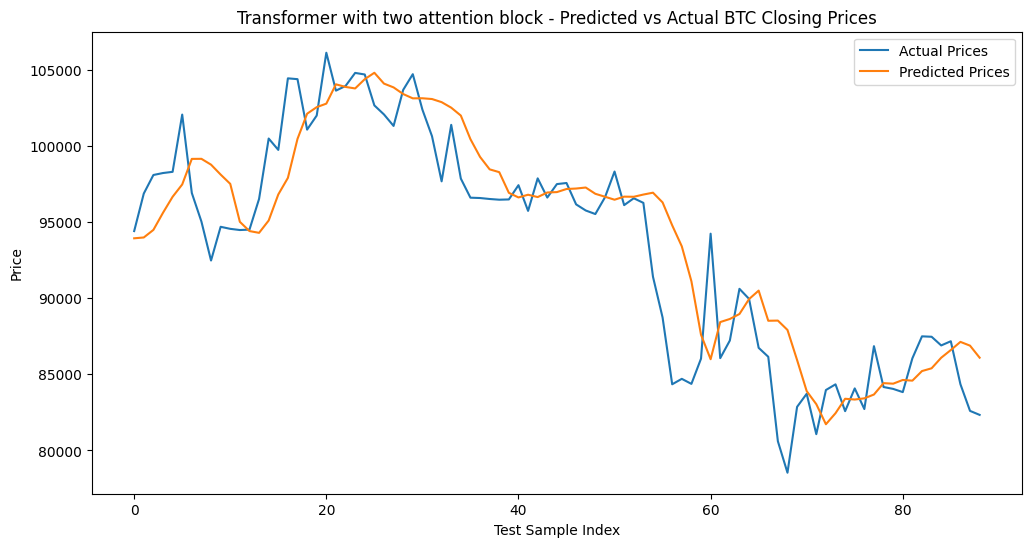

In [41]:
print("\nSome test predictions of Transformer with two attenton block\n")

for day_index in range(5):
    print(f"Sample {day_index+1}")
    print("Last 10 days input (closing btc price):", X_test_scaled[day_index].flatten())
    print(f"Actual BTC closing price      : {y_test_inverse[day_index]}")
    print(f"Predicted BTC closing price   : {y_pred_inverse[day_index]}\n")

# Plotting actual vs predicted prices on test set
plt.figure(figsize=(12, 6))
plt.plot(y_test_inverse, label='Actual Prices')
plt.plot(y_pred_inverse, label='Predicted Prices')
plt.title('Transformer with two attention block - Predicted vs Actual BTC Closing Prices')
plt.xlabel('Test Sample Index')
plt.ylabel('Price')
plt.legend()
plt.show()

**Transformer with three attention blocks**

Epoch 1/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0051 - mae: 0.0481 - val_loss: 0.0111 - val_mae: 0.0755
Epoch 2/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0022 - mae: 0.0275 - val_loss: 0.0061 - val_mae: 0.0524
Epoch 3/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0018 - mae: 0.0226 - val_loss: 0.0054 - val_mae: 0.0487
Epoch 4/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0018 - mae: 0.0211 - val_loss: 0.0054 - val_mae: 0.0485
Epoch 5/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0020 - mae: 0.0216 - val_loss: 0.0054 - val_mae: 0.0487
Epoch 6/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0019 - mae: 0.0211 - val_loss: 0.0054 - val_mae: 0.0487
Epoch 7/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0020 - mae: 0.0213 - val_loss: 0.0054 - val_mae: 0.0485
Epoch 8/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0021 - mae: 0.0227 - val_loss: 0.0055 - val_mae: 0.0493
Epoch 9/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0019 - mae: 

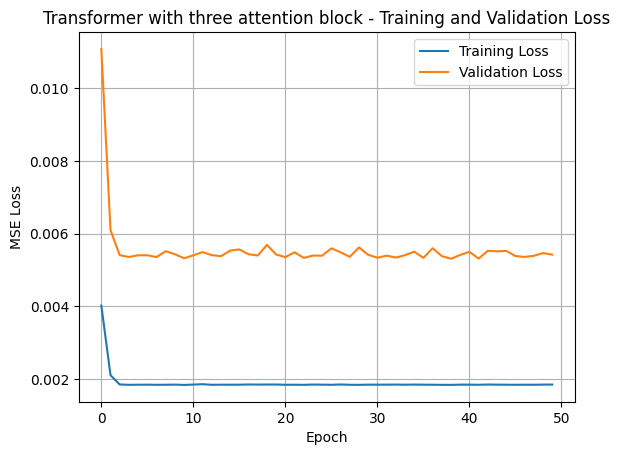

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step

 Metrics: Transformer with three attention block:
MAE  - 2489.3099
MSE  - 12061925.5548
RMSE - 3473.0283
R²   - 0.7761
MAPE - 2.71%



In [42]:
three_block_transformer = BTC_Transformer(input_shape, num_blocks=3)
three_block_transformer.compile(optimizer=Adam(learning_rate=0.001), loss='mse', metrics=['mae'])
history_three_block_transformer = three_block_transformer.fit(X_train_scaled, y_train_scaled, epochs=epochs, batch_size=batch_size, validation_split=0.2, verbose=1)

# Plotting training and validation loss over epochs
plt.plot(history_three_block_transformer.history['loss'], label='Training Loss')
plt.plot(history_three_block_transformer.history['val_loss'], label='Validation Loss')
plt.title('Transformer with three attention block - Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.legend()
plt.grid(True)
plt.show()

#saving the trained model
three_block_transformer.save("btc_three_block_transformer_model.keras")

#Predicting the closing price of BTC
y_pred = three_block_transformer.predict(X_test_scaled).flatten()
y_test_inverse = y_scaler.inverse_transform(y_test_scaled.reshape(-1, 1)).flatten()
y_pred_inverse = y_scaler.inverse_transform(y_pred.reshape(-1, 1)).flatten()

print(f"\n Metrics: Transformer with three attention block:")
mae = mean_absolute_error(y_test_inverse, y_pred_inverse)
print(f"MAE  - {mae:.4f}")
mse = mean_squared_error(y_test_inverse, y_pred_inverse)
print(f"MSE  - {mse:.4f}")
rmse = math.sqrt(mse)
print(f"RMSE - {rmse:.4f}")
r2 = r2_score(y_test_inverse, y_pred_inverse)
print(f"R²   - {r2:.4f}")
mape = mean_absolute_percentage_error(y_test_inverse, y_pred_inverse) * 100
print(f"MAPE - {mape:.2f}%\n")


Some test predictions of Transformer with three attenton block

Sample 1
Last 10 days input (closing btc price): [2.93140986 2.91709744 3.05348403 3.07478374 2.95501615 2.89927482
 2.93342641 2.87758093 2.84725975 2.87412761]
Actual BTC closing price      : 94419.7578125
Predicted BTC closing price   : 93581.328125

Sample 2
Last 10 days input (closing btc price): [2.91709744 3.05348403 3.07478374 2.95501615 2.89927482 2.93342641
 2.87758093 2.84725975 2.87412761 2.90798811]
Actual BTC closing price      : 96886.875
Predicted BTC closing price   : 92911.5703125

Sample 3
Last 10 days input (closing btc price): [3.05348403 3.07478374 2.95501615 2.89927482 2.93342641 2.87758093
 2.84725975 2.87412761 2.90798811 2.99232249]
Actual BTC closing price      : 98107.4296875
Predicted BTC closing price   : 93243.828125

Sample 4
Last 10 days input (closing btc price): [3.07478374 2.95501615 2.89927482 2.93342641 2.87758093 2.84725975
 2.87412761 2.90798811 2.99232249 3.03404517]
Actual BTC clo

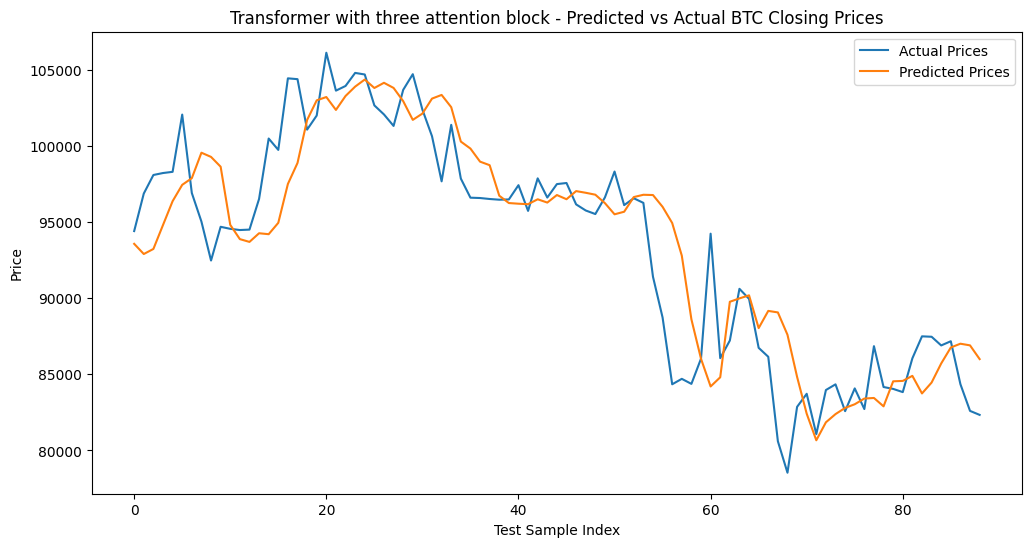

In [43]:
print("\nSome test predictions of Transformer with three attenton block\n")

for day_index in range(5):
    print(f"Sample {day_index+1}")
    print("Last 10 days input (closing btc price):", X_test_scaled[day_index].flatten())
    print(f"Actual BTC closing price      : {y_test_inverse[day_index]}")
    print(f"Predicted BTC closing price   : {y_pred_inverse[day_index]}\n")

# Plotting actual vs predicted prices on test set
plt.figure(figsize=(12, 6))
plt.plot(y_test_inverse, label='Actual Prices')
plt.plot(y_pred_inverse, label='Predicted Prices')
plt.title('Transformer with three attention block - Predicted vs Actual BTC Closing Prices')
plt.xlabel('Test Sample Index')
plt.ylabel('Price')
plt.legend()
plt.show()

**Transformer with four attention blocks**

Epoch 1/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0858 - mae: 0.2010 - val_loss: 0.3724 - val_mae: 0.5054
Epoch 2/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0589 - mae: 0.1813 - val_loss: 0.2473 - val_mae: 0.4071
Epoch 3/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0418 - mae: 0.1550 - val_loss: 0.1641 - val_mae: 0.3293
Epoch 4/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0283 - mae: 0.1256 - val_loss: 0.1043 - val_mae: 0.2595
Epoch 5/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0178 - mae: 0.0968 - val_loss: 0.0641 - val_mae: 0.1996
Epoch 6/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0116 - mae: 0.0772 - val_loss: 0.0385 - val_mae: 0.1508
Epoch 7/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0080 - mae: 0.0605 - val_loss: 0.0234 - val_mae: 0.1138
Epoch 8/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0048 - mae: 0.0466 - val_loss: 0.0147 - val_mae: 0.0875
Epoch 9/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0038 - mae: 

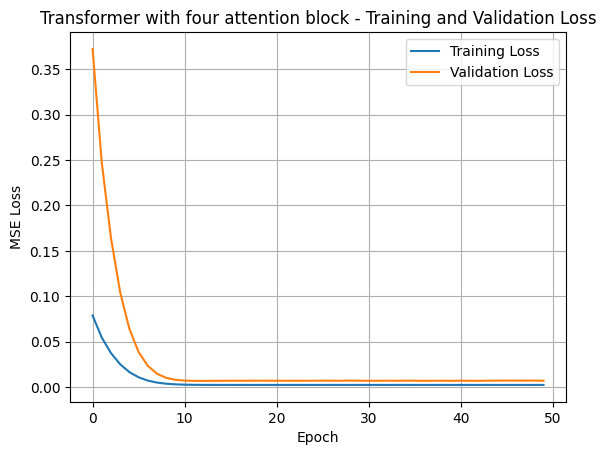

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step

 Metrics: Transformer with four attention block:
MAE  - 2763.1032
MSE  - 14579138.2187
RMSE - 3818.2638
R²   - 0.7294
MAPE - 3.01%



In [44]:
four_block_transformer = BTC_Transformer(input_shape, num_blocks=4)
four_block_transformer.compile(optimizer=Adam(learning_rate=0.001), loss='mse', metrics=['mae'])
history_four_block_transformer = four_block_transformer.fit(X_train_scaled, y_train_scaled, epochs=epochs, batch_size=batch_size, validation_split=0.2, verbose=1)

# Plotting training and validation loss over epochs
plt.plot(history_four_block_transformer.history['loss'], label='Training Loss')
plt.plot(history_four_block_transformer.history['val_loss'], label='Validation Loss')
plt.title('Transformer with four attention block - Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.legend()
plt.grid(True)
plt.show()

#saving the trained model
four_block_transformer.save("btc_four_block_transformer_model.keras")

#Predicting the closing price of BTC
y_pred = four_block_transformer.predict(X_test_scaled).flatten()
y_test_inverse = y_scaler.inverse_transform(y_test_scaled.reshape(-1, 1)).flatten()
y_pred_inverse = y_scaler.inverse_transform(y_pred.reshape(-1, 1)).flatten()

print(f"\n Metrics: Transformer with four attention block:")
mae = mean_absolute_error(y_test_inverse, y_pred_inverse)
print(f"MAE  - {mae:.4f}")
mse = mean_squared_error(y_test_inverse, y_pred_inverse)
print(f"MSE  - {mse:.4f}")
rmse = math.sqrt(mse)
print(f"RMSE - {rmse:.4f}")
r2 = r2_score(y_test_inverse, y_pred_inverse)
print(f"R²   - {r2:.4f}")
mape = mean_absolute_percentage_error(y_test_inverse, y_pred_inverse) * 100
print(f"MAPE - {mape:.2f}%\n")


Some test predictions of Transformer with four attenton block

Sample 1
Last 10 days input (closing btc price): [2.93140986 2.91709744 3.05348403 3.07478374 2.95501615 2.89927482
 2.93342641 2.87758093 2.84725975 2.87412761]
Actual BTC closing price      : 94419.7578125
Predicted BTC closing price   : 94063.1875

Sample 2
Last 10 days input (closing btc price): [2.91709744 3.05348403 3.07478374 2.95501615 2.89927482 2.93342641
 2.87758093 2.84725975 2.87412761 2.90798811]
Actual BTC closing price      : 96886.875
Predicted BTC closing price   : 92762.796875

Sample 3
Last 10 days input (closing btc price): [3.05348403 3.07478374 2.95501615 2.89927482 2.93342641 2.87758093
 2.84725975 2.87412761 2.90798811 2.99232249]
Actual BTC closing price      : 98107.4296875
Predicted BTC closing price   : 92708.4296875

Sample 4
Last 10 days input (closing btc price): [3.07478374 2.95501615 2.89927482 2.93342641 2.87758093 2.84725975
 2.87412761 2.90798811 2.99232249 3.03404517]
Actual BTC closin

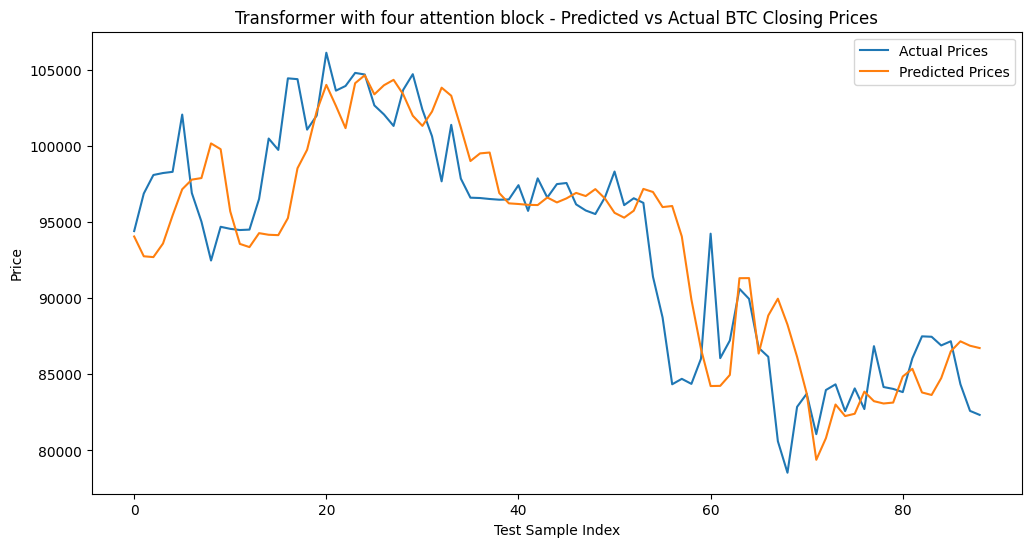

In [45]:
print("\nSome test predictions of Transformer with four attenton block\n")

for day_index in range(5):
    print(f"Sample {day_index+1}")
    print("Last 10 days input (closing btc price):", X_test_scaled[day_index].flatten())
    print(f"Actual BTC closing price      : {y_test_inverse[day_index]}")
    print(f"Predicted BTC closing price   : {y_pred_inverse[day_index]}\n")

# Plotting actual vs predicted prices on test set
plt.figure(figsize=(12, 6))
plt.plot(y_test_inverse, label='Actual Prices')
plt.plot(y_pred_inverse, label='Predicted Prices')
plt.title('Transformer with four attention block - Predicted vs Actual BTC Closing Prices')
plt.xlabel('Test Sample Index')
plt.ylabel('Price')
plt.legend()
plt.show()

**Transformer with five attention blocks**

Epoch 1/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.3553 - mae: 0.4064 - val_loss: 2.0079 - val_mae: 1.2052
Epoch 2/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2857 - mae: 0.3829 - val_loss: 1.6176 - val_mae: 1.0721
Epoch 3/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2470 - mae: 0.3738 - val_loss: 1.3209 - val_mae: 0.9639
Epoch 4/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2105 - mae: 0.3514 - val_loss: 1.0908 - val_mae: 0.8745
Epoch 5/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1705 - mae: 0.3161 - val_loss: 0.8901 - val_mae: 0.7886
Epoch 6/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1380 - mae: 0.2868 - val_loss: 0.7262 - val_mae: 0.7120
Epoch 7/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1128 - mae: 0.2601 - val_loss: 0.5851 - val_mae: 0.6384
Epoch 8/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0895 - mae: 0.2332 - val_loss: 0.4640 - val_mae: 0.5675
Epoch 9/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0750 - mae: 

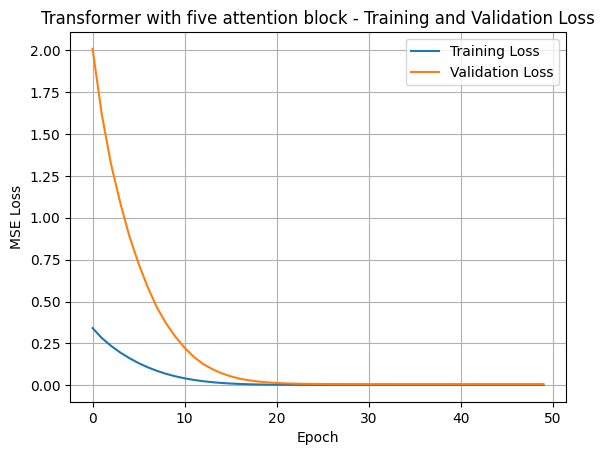

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step

 Metrics: Transformer with five attention block:
MAE  - 2772.2281
MSE  - 14560626.8831
RMSE - 3815.8389
R²   - 0.7298
MAPE - 3.02%



In [46]:
five_block_transformer = BTC_Transformer(input_shape, num_blocks=4)
five_block_transformer.compile(optimizer=Adam(learning_rate=0.001), loss='mse', metrics=['mae'])
history_five_block_transformer = five_block_transformer.fit(X_train_scaled, y_train_scaled, epochs=epochs, batch_size=batch_size, validation_split=0.2, verbose=1)

# Plotting training and validation loss over epochs
plt.plot(history_five_block_transformer.history['loss'], label='Training Loss')
plt.plot(history_five_block_transformer.history['val_loss'], label='Validation Loss')
plt.title('Transformer with five attention block - Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.legend()
plt.grid(True)
plt.show()

#saving the trained model
five_block_transformer.save("btc_five_block_transformer_model.keras")

#Predicting the closing price of BTC
y_pred = five_block_transformer.predict(X_test_scaled).flatten()
y_test_inverse = y_scaler.inverse_transform(y_test_scaled.reshape(-1, 1)).flatten()
y_pred_inverse = y_scaler.inverse_transform(y_pred.reshape(-1, 1)).flatten()

print(f"\n Metrics: Transformer with five attention block:")
mae = mean_absolute_error(y_test_inverse, y_pred_inverse)
print(f"MAE  - {mae:.4f}")
mse = mean_squared_error(y_test_inverse, y_pred_inverse)
print(f"MSE  - {mse:.4f}")
rmse = math.sqrt(mse)
print(f"RMSE - {rmse:.4f}")
r2 = r2_score(y_test_inverse, y_pred_inverse)
print(f"R²   - {r2:.4f}")
mape = mean_absolute_percentage_error(y_test_inverse, y_pred_inverse) * 100
print(f"MAPE - {mape:.2f}%\n")


Some test predictions of Transformer with five attenton block

Sample 1
Last 10 days input (closing btc price): [2.93140986 2.91709744 3.05348403 3.07478374 2.95501615 2.89927482
 2.93342641 2.87758093 2.84725975 2.87412761]
Actual BTC closing price      : 94419.7578125
Predicted BTC closing price   : 93990.46875

Sample 2
Last 10 days input (closing btc price): [2.91709744 3.05348403 3.07478374 2.95501615 2.89927482 2.93342641
 2.87758093 2.84725975 2.87412761 2.90798811]
Actual BTC closing price      : 96886.875
Predicted BTC closing price   : 92689.6171875

Sample 3
Last 10 days input (closing btc price): [3.05348403 3.07478374 2.95501615 2.89927482 2.93342641 2.87758093
 2.84725975 2.87412761 2.90798811 2.99232249]
Actual BTC closing price      : 98107.4296875
Predicted BTC closing price   : 92635.2421875

Sample 4
Last 10 days input (closing btc price): [3.07478374 2.95501615 2.89927482 2.93342641 2.87758093 2.84725975
 2.87412761 2.90798811 2.99232249 3.03404517]
Actual BTC clos

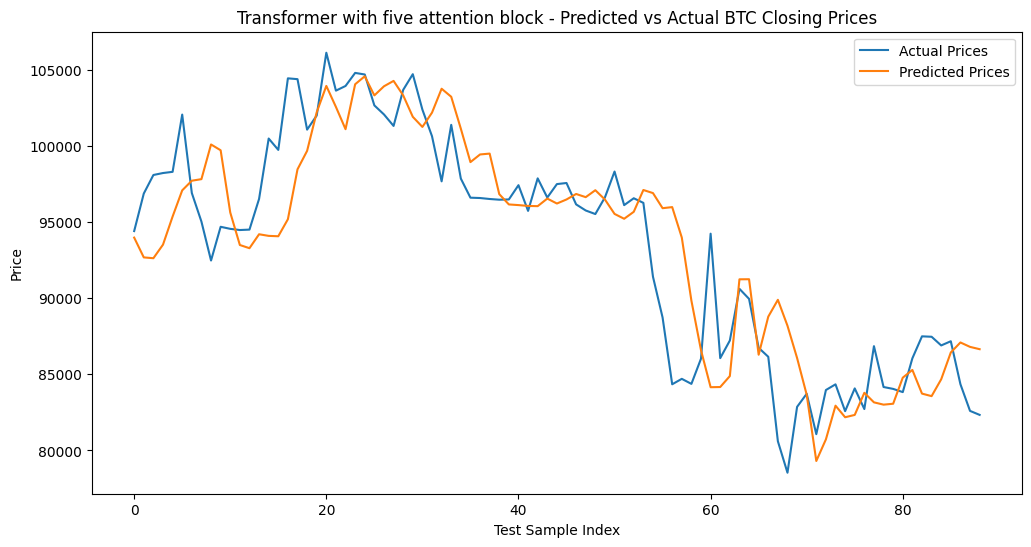

In [47]:
print("\nSome test predictions of Transformer with five attenton block\n")

for day_index in range(5):
    print(f"Sample {day_index+1}")
    print("Last 10 days input (closing btc price):", X_test_scaled[day_index].flatten())
    print(f"Actual BTC closing price      : {y_test_inverse[day_index]}")
    print(f"Predicted BTC closing price   : {y_pred_inverse[day_index]}\n")

# Plotting actual vs predicted prices on test set
plt.figure(figsize=(12, 6))
plt.plot(y_test_inverse, label='Actual Prices')
plt.plot(y_pred_inverse, label='Predicted Prices')
plt.title('Transformer with five attention block - Predicted vs Actual BTC Closing Prices')
plt.xlabel('Test Sample Index')
plt.ylabel('Price')
plt.legend()
plt.show()

---

# Section: 3. LSTM models with stationery data.ipynb


# Importing and Saving the BTC-USD historical price data from Yahoo Finance

**Checking whether data is stationery or not stationery and if found stationery then applying Differencing**

In [48]:
from statsmodels.tsa.stattools import adfuller

#Extracting the closing btc price series
closing_series = btc_cc['Close']

#Making the btc series to stationary (apply differencing if needed)
def btc_stationary(series, max_diffs=2):
    initial_btc_series = series.dropna().copy()
    difference_applied = 0

    for i in range(max_diffs + 1):
        result = adfuller(initial_btc_series)
        p_value = result[1]

        print(f"\nAugmented Dickey-Fuller (ADF) Test{i+1}:")
        print(f"ADF Statistic: {result[0]:.4f}")
        print(f"p-value: {p_value:.4f}")
        if p_value <= 0.05:
            print("Bitcoin series is now stationary")
            return initial_btc_series, difference_applied
        elif i < max_diffs:
            print("Bitcoin series is not stationary. Applying differencing...")
            initial_btc_series = pd.Series(np.diff(initial_btc_series), index=initial_btc_series.index[1:])
            difference_applied += 1

    raise ValueError("Could not make the Bitcoin series stationary")

try:
    print("Checking stationarity of original BTC closing price series...")
    close_stationary, difference_needed = btc_stationary(btc_cc['Close'])

    print(f"\n Successfully made series stationary with {difference_needed} difference(s)")
    print("Proceeding with next steps...")

    # Replace the original closing prices with the stationary version
    btc_cc = btc_cc.iloc[difference_needed:]  # Align with differencing
    btc_cc['Close'] = close_stationary.values

except ValueError as e:
    print(f"\n Error: {e}")
    print(" Cannot proceed with analysis - Bitcoin series is not stationary")

Checking stationarity of original BTC closing price series...

Augmented Dickey-Fuller (ADF) Test1:
ADF Statistic: -0.5211
p-value: 0.8878
Bitcoin series is not stationary. Applying differencing...

Augmented Dickey-Fuller (ADF) Test2:
ADF Statistic: -9.2114
p-value: 0.0000
Bitcoin series is now stationary

 Successfully made series stationary with 1 difference(s)
Proceeding with next steps...


# **Sliding window one-step ahead forecasting**

In [49]:
closing_prices = btc_cc['Close'].values
dates = btc_cc['Date'].values

# In this code 10 previous days will be used to predict the next day's price
window_size = 10

# Preparing the input (X), target (y), and target date using a sliding window
X, y, y_dates = [], [], []
for current_day_index in range(window_size, len(closing_prices)):
    ten_days_window = closing_prices[current_day_index - window_size:current_day_index]  # previous 10 days
    target_day = closing_prices[current_day_index]  # next day's price
    target_date = dates[current_day_index]  # next day's date

    X.append(ten_days_window)
    y.append(target_day)
    y_dates.append(target_date)

X = np.array(X)
y = np.array(y)
y_dates = np.array(y_dates)

print(f"Input shape (X): {X.shape}")
print(f"Target shape (y): {y.shape}")
print("Example input:", X[0])
print("Expected output:", y[0])

# Reshaping X
X = X.reshape((X.shape[0], X.shape[1], 1))
print(f"Reshaped input for LSTM: {X.shape}")

Input shape (X): (3837, 10)
Target shape (y): (3837,)
Example input: [-32.89401245 -29.64401245  14.10800171 -10.08297729   3.33099365
  33.63897705 -12.58599854 -11.63098145  -7.14901733  -4.90499878]
Expected output: -22.3389892578125
Reshaped input for LSTM: (3837, 10, 1)


**DAta Splitting into Training and Testing**

In [50]:
split_date = np.datetime64('2025-01-01')
before_split_date = y_dates < split_date
from_2025_onward = y_dates >= split_date

# Splitting the dataset in to training and testing
X_train, X_test = X[before_split_date], X[from_2025_onward]
y_train, y_test = y[before_split_date], y[from_2025_onward]

print(f"\nTraining set of BTC closing prices:  X = {X_train.shape},  y = {y_train.shape}")
print(f"Testing set of BTC closing prices:   X = {X_test.shape},   y = {y_test.shape}")


Training set of BTC closing prices:  X = (3748, 10, 1),  y = (3748,)
Testing set of BTC closing prices:   X = (89, 10, 1),   y = (89,)


In [51]:
X_train

array([[[-3.28940125e+01],
        [-2.96440125e+01],
        [ 1.41080017e+01],
        ...,
        [-1.16309814e+01],
        [-7.14901733e+00],
        [-4.90499878e+00]],

       [[-2.96440125e+01],
        [ 1.41080017e+01],
        [-1.00829773e+01],
        ...,
        [-7.14901733e+00],
        [-4.90499878e+00],
        [-2.23389893e+01]],

       [[ 1.41080017e+01],
        [-1.00829773e+01],
        [ 3.33099365e+00],
        ...,
        [-4.90499878e+00],
        [-2.23389893e+01],
        [-1.71398926e+00]],

       ...,

       [[-2.55058594e+03],
        [ 2.64976562e+02],
        [-5.31203125e+02],
        ...,
        [-3.50367969e+03],
        [-1.63065625e+03],
        [ 9.99070312e+02]],

       [[ 2.64976562e+02],
        [-5.31203125e+02],
        [-2.11978906e+03],
        ...,
        [-1.63065625e+03],
        [ 9.99070312e+02],
        [-1.63370312e+03]],

       [[-5.31203125e+02],
        [-2.11978906e+03],
        [-4.18695312e+02],
        ...,
        

In [52]:
y_test

array([  990.5546875,  2467.1171875,  1220.5546875,   128.796875 ,
          78.734375 ,  3763.125    , -5155.3828125, -1879.1796875,
       -2559.484375 ,  2217.4140625,  -134.859375 ,   -78.15625  ,
          28.0859375,  2017.5234375,  3970.4453125,  -747.5859375,
        4705.1328125,   -53.96875  , -3318.4609375,   927.0546875,
        4129.6015625, -2493.1953125,   307.1015625,   859.3125   ,
        -104.8359375, -2032.1484375,  -594.8125   ,  -755.2109375,
        2370.734375 ,  1032.09375  , -2330.28125  , -1749.1171875,
       -2966.9296875,  3716.4453125, -3533.6015625, -1256.375    ,
         -22.1484375,   -64.2109375,   -46.6328125,    17.640625 ,
         937.4609375, -1690.125    ,  2138.4296875, -1261.9921875,
         885.1015625,    71.3828125, -1405.3203125,  -401.6484375,
        -233.8359375,  1096.0625   ,  1698.328125 , -2208.390625 ,
         452.2109375,  -303.8359375, -4855.75     , -2682.       ,
       -4389.1484375,   357.203125 ,  -331.21875  ,  1658.9062

# **Unidirectional LSTM**

Epoch 1/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - loss: 627377.7500 - mae: 349.3791 - val_loss: 1891011.2500 - val_mae: 867.3170
Epoch 2/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step - loss: 623537.2500 - mae: 348.2569 - val_loss: 1906029.7500 - val_mae: 870.6229
Epoch 3/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - loss: 718427.4375 - mae: 380.7282 - val_loss: 1921488.7500 - val_mae: 876.0534
Epoch 4/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 630143.5000 - mae: 352.2150 - val_loss: 1925670.3750 - val_mae: 877.3651
Epoch 5/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - loss: 632347.6250 - mae: 351.3311 - val_loss: 1920914.7500 - val_mae: 875.8502
Epoch 6/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - loss: 755950.1250 - mae: 387.0629 - val_loss: 1927861.1250 - val_mae: 877.2484
Epoch 7/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - loss: 755955.2500 - mae: 390.1250 - val_loss: 1890532.3750 - val_mae: 865.2704
Epoch 8/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - loss: 640888.7500 - mae

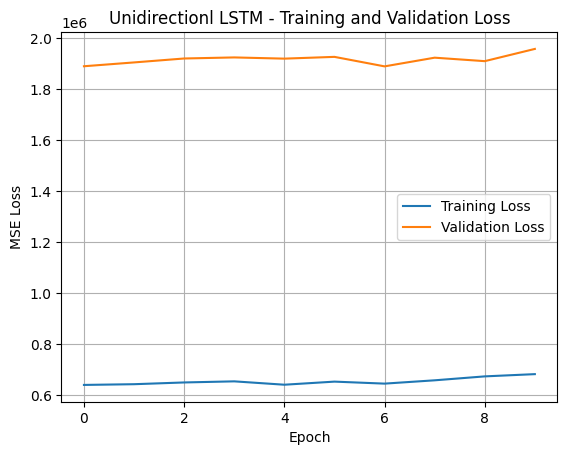

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step

 Metrics: Unidirectional LSTM:
MAE  - 5558.6793
MSE  - 41335475.6700
RMSE - 6429.2671
R²   - 0.2329
MAPE - 99.42%



In [53]:
# Building Uni-directional LSTM model for next-day price prediction
Uni_LSTM = Sequential()
Uni_LSTM.add(LSTM(300, activation='selu', input_shape=(window_size, 1)))
Uni_LSTM.add(Dense(1))
Uni_LSTM.compile(optimizer='adam', loss='mse', metrics=['mae'])

#Training the Uni-LSTM model
history_uni_lstm = Uni_LSTM.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.2, verbose=1)

# Plotting training and validation loss over epochs
plt.plot(history_uni_lstm.history['loss'], label='Training Loss')
plt.plot(history_uni_lstm.history['val_loss'], label='Validation Loss')
plt.title('Unidirectionl LSTM - Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.legend()
plt.grid(True)
plt.show()

#Predicting the closing price of BTC
y_pred = Uni_LSTM.predict(X_test).flatten()

# Inverse differencing
last_train_price = btc_cc['Close'].iloc[len(btc_cc) - len(y_test) - 1]
y_pred_inverse = np.r_[last_train_price, y_pred].cumsum()[1:]
y_test_inverse = np.r_[last_train_price, y_test].cumsum()[1:]

print(f"\n Metrics: Unidirectional LSTM:")
mae = mean_absolute_error(y_test_inverse, y_pred_inverse)
print(f"MAE  - {mae:.4f}")
mse = mean_squared_error(y_test_inverse, y_pred_inverse)
print(f"MSE  - {mse:.4f}")
rmse = math.sqrt(mse)
print(f"RMSE - {rmse:.4f}")
r2 = r2_score(y_test_inverse, y_pred_inverse)
print(f"R²   - {r2:.4f}")
mape = mean_absolute_percentage_error(y_test_inverse, y_pred_inverse) * 100
print(f"MAPE - {mape:.2f}%\n")


Some test predictions of Unidirectionl LSTM

Sample 1
Last 10 days input (closing btc price): [-2119.7890625  -418.6953125  3989.8515625   623.1015625 -3503.6796875
 -1630.65625     999.0703125 -1633.703125   -887.015625    785.9921875]
Actual BTC closing price      : 1776.546875
Predicted BTC closing price   : 256.6884765625

Sample 2
Last 10 days input (closing btc price): [ -418.6953125  3989.8515625   623.1015625 -3503.6796875 -1630.65625
   999.0703125 -1633.703125   -887.015625    785.9921875   990.5546875]
Actual BTC closing price      : 4243.6640625
Predicted BTC closing price   : -54.314910888671875

Sample 3
Last 10 days input (closing btc price): [ 3989.8515625   623.1015625 -3503.6796875 -1630.65625     999.0703125
 -1633.703125   -887.015625    785.9921875   990.5546875  2467.1171875]
Actual BTC closing price      : 5464.21875
Predicted BTC closing price   : -248.1780548095703

Sample 4
Last 10 days input (closing btc price): [  623.1015625 -3503.6796875 -1630.65625     9

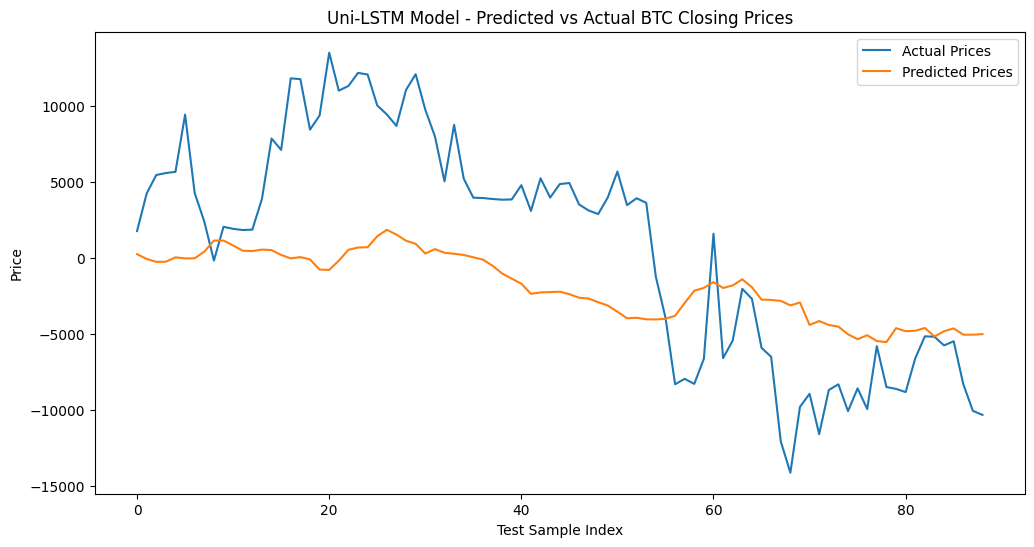

In [54]:
print("\nSome test predictions of Unidirectionl LSTM\n")

for day_index in range(5):
    print(f"Sample {day_index+1}")
    print("Last 10 days input (closing btc price):", X_test[day_index].flatten())
    print(f"Actual BTC closing price      : {y_test_inverse[day_index]}")
    print(f"Predicted BTC closing price   : {y_pred_inverse[day_index]}\n")

# Plotting actual vs predicted prices on test set
plt.figure(figsize=(12, 6))
plt.plot(y_test_inverse, label='Actual Prices')
plt.plot(y_pred_inverse, label='Predicted Prices')
plt.title('Uni-LSTM Model - Predicted vs Actual BTC Closing Prices')
plt.xlabel('Test Sample Index')
plt.ylabel('Price')
plt.legend()
plt.show()

# **Bidirectional LSTM**

Epoch 1/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 7s 55ms/step - loss: 596259.5000 - mae: 344.8451 - val_loss: 1934137.5000 - val_mae: 876.3589
Epoch 2/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 9s 37ms/step - loss: 764567.0000 - mae: 395.2683 - val_loss: 1888885.8750 - val_mae: 868.9331
Epoch 3/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 4s 47ms/step - loss: 611067.9375 - mae: 353.6248 - val_loss: 1902048.2500 - val_mae: 868.0778
Epoch 4/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 4s 38ms/step - loss: 624364.3125 - mae: 358.6951 - val_loss: 1919077.0000 - val_mae: 878.0141
Epoch 5/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - loss: 604631.1875 - mae: 357.6485 - val_loss: 1885831.5000 - val_mae: 862.8128
Epoch 6/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 4s 47ms/step - loss: 658549.8750 - mae: 358.8324 - val_loss: 1887166.2500 - val_mae: 866.6173
Epoch 7/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 4s 39ms/step - loss: 623348.3125 - mae: 359.7702 - val_loss: 1965600.2500 - val_mae: 889.2862
Epoch 8/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step - loss: 764204.0000 - mae

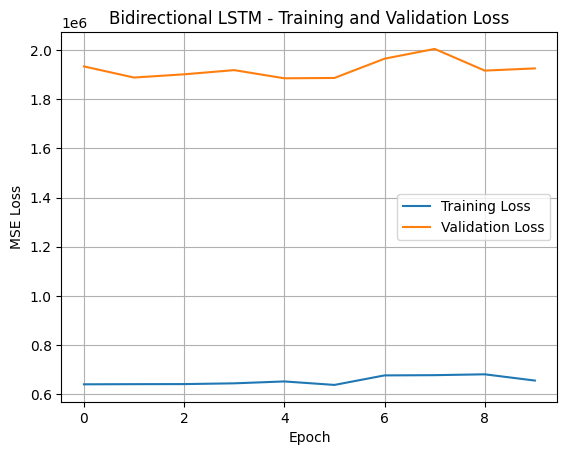

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step

 Metrics: Bidirectional LSTM:
MAE  - 7537.8293
MSE  - 74631199.6115
RMSE - 8638.9351
R²   - -0.3851
MAPE - 112.68%



In [55]:
# Building Bi-directional LSTM model for next-day price prediction
Bi_LSTM = Sequential()
Bi_LSTM.add(Bidirectional(LSTM(300, activation='selu', input_shape=(window_size, 1))))
Bi_LSTM.add(Dense(1))
Bi_LSTM.compile(optimizer='adam', loss='mse', metrics=['mae'])

#Training the Bi-LSTM model
history_bi_lstm = Bi_LSTM.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.2, verbose=1)

# Plotting training and validation loss over epochs
plt.plot(history_bi_lstm.history['loss'], label='Training Loss')
plt.plot(history_bi_lstm.history['val_loss'], label='Validation Loss')
plt.title('Bidirectional LSTM - Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.legend()
plt.grid(True)
plt.show()

#Predicting the closing price of BTC
y_pred = Bi_LSTM.predict(X_test).flatten()

# Inverse differencing
last_train_price = btc_cc['Close'].iloc[len(btc_cc) - len(y_test) - 1]
y_pred_inverse = np.r_[last_train_price, y_pred].cumsum()[1:]
y_test_inverse = np.r_[last_train_price, y_test].cumsum()[1:]

print(f"\n Metrics: Bidirectional LSTM:")
mae = mean_absolute_error(y_test_inverse, y_pred_inverse)
print(f"MAE  - {mae:.4f}")
mse = mean_squared_error(y_test_inverse, y_pred_inverse)
print(f"MSE  - {mse:.4f}")
rmse = math.sqrt(mse)
print(f"RMSE - {rmse:.4f}")
r2 = r2_score(y_test_inverse, y_pred_inverse)
print(f"R²   - {r2:.4f}")
mape = mean_absolute_percentage_error(y_test_inverse, y_pred_inverse) * 100
print(f"MAPE - {mape:.2f}%\n")


Some test predictions of Bidirectionl LSTM

Sample 1
Last 10 days input (closing btc price): [-2119.7890625  -418.6953125  3989.8515625   623.1015625 -3503.6796875
 -1630.65625     999.0703125 -1633.703125   -887.015625    785.9921875]
Actual BTC closing price      : 1776.546875
Predicted BTC closing price   : 485.89471435546875

Sample 2
Last 10 days input (closing btc price): [ -418.6953125  3989.8515625   623.1015625 -3503.6796875 -1630.65625
   999.0703125 -1633.703125   -887.015625    785.9921875   990.5546875]
Actual BTC closing price      : 4243.6640625
Predicted BTC closing price   : 478.47723627090454

Sample 3
Last 10 days input (closing btc price): [ 3989.8515625   623.1015625 -3503.6796875 -1630.65625     999.0703125
 -1633.703125   -887.015625    785.9921875   990.5546875  2467.1171875]
Actual BTC closing price      : 5464.21875
Predicted BTC closing price   : 326.8592095375061

Sample 4
Last 10 days input (closing btc price): [  623.1015625 -3503.6796875 -1630.65625     

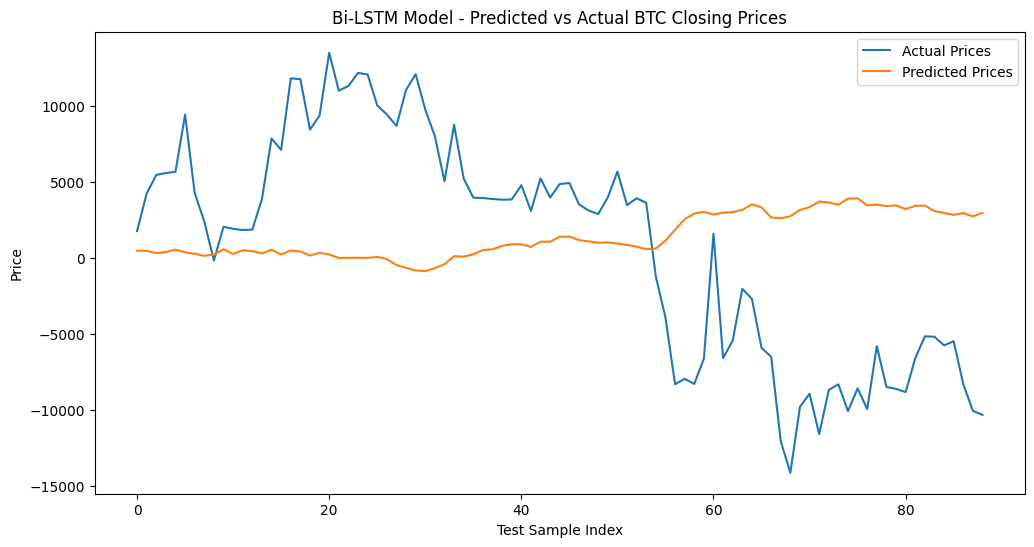

In [56]:
print("\nSome test predictions of Bidirectionl LSTM\n")

for day_index in range(5):
    print(f"Sample {day_index+1}")
    print("Last 10 days input (closing btc price):", X_test[day_index].flatten())
    print(f"Actual BTC closing price      : {y_test_inverse[day_index]}")
    print(f"Predicted BTC closing price   : {y_pred_inverse[day_index]}\n")

# Plotting actual vs predicted prices on test set
plt.figure(figsize=(12, 6))
plt.plot(y_test_inverse, label='Actual Prices')
plt.plot(y_pred_inverse, label='Predicted Prices')
plt.title('Bi-LSTM Model - Predicted vs Actual BTC Closing Prices')
plt.xlabel('Test Sample Index')
plt.ylabel('Price')
plt.legend()
plt.show()

# **Stacked LSTM**

Epoch 1/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 10s 68ms/step - loss: 666899.0625 - mae: 373.5473 - val_loss: 1894339.1250 - val_mae: 874.1074
Epoch 2/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 10s 70ms/step - loss: 625797.6875 - mae: 346.2944 - val_loss: 2085034.1250 - val_mae: 922.7238
Epoch 3/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 7s 76ms/step - loss: 588875.6875 - mae: 357.9053 - val_loss: 1929039.0000 - val_mae: 879.9381
Epoch 4/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 9s 65ms/step - loss: 712268.5625 - mae: 385.2761 - val_loss: 1906400.7500 - val_mae: 877.8677
Epoch 5/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 8s 83ms/step - loss: 681082.8750 - mae: 382.9912 - val_loss: 1939528.7500 - val_mae: 880.2490
Epoch 6/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 9s 67ms/step - loss: 700643.1250 - mae: 385.5406 - val_loss: 1929692.6250 - val_mae: 871.2557
Epoch 7/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 10s 65ms/step - loss: 633585.5625 - mae: 361.1976 - val_loss: 1906516.6250 - val_mae: 874.9724
Epoch 8/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 8s 84ms/step - loss: 604703.9375 - 

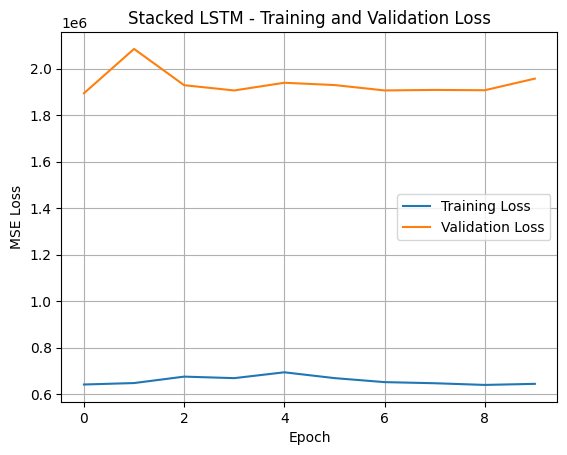

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 157ms/step

 Metrics: Stacked LSTM:
MAE  - 11041.9583
MSE  - 145376860.1376
RMSE - 12057.2327
R²   - -1.6980
MAPE - 213.33%



In [57]:
# Building Stacked LSTM model for next-day price prediction
stacked_LSTM = Sequential()
stacked_LSTM.add(LSTM(300, activation='selu', return_sequences=True, input_shape=(window_size, 1)))
stacked_LSTM.add(LSTM(150, activation='selu'))
stacked_LSTM.add(Dense(1))
stacked_LSTM.compile(optimizer='adam', loss='mse', metrics=['mae'])

#Training the Stacked LSTM model
history_stacked_lstm = stacked_LSTM.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.2, verbose=1)

# Plotting training and validation loss over epochs
plt.plot(history_stacked_lstm.history['loss'], label='Training Loss')
plt.plot(history_stacked_lstm.history['val_loss'], label='Validation Loss')
plt.title('Stacked LSTM - Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.legend()
plt.grid(True)
plt.show()

#Predicting the closing price of BTC
y_pred = stacked_LSTM.predict(X_test).flatten()

# Inverse differencing
last_train_price = btc_cc['Close'].iloc[len(btc_cc) - len(y_test) - 1]
y_pred_inverse = np.r_[last_train_price, y_pred].cumsum()[1:]
y_test_inverse = np.r_[last_train_price, y_test].cumsum()[1:]

print(f"\n Metrics: Stacked LSTM:")
mae = mean_absolute_error(y_test_inverse, y_pred_inverse)
print(f"MAE  - {mae:.4f}")
mse = mean_squared_error(y_test_inverse, y_pred_inverse)
print(f"MSE  - {mse:.4f}")
rmse = math.sqrt(mse)
print(f"RMSE - {rmse:.4f}")
r2 = r2_score(y_test_inverse, y_pred_inverse)
print(f"R²   - {r2:.4f}")
mape = mean_absolute_percentage_error(y_test_inverse, y_pred_inverse) * 100
print(f"MAPE - {mape:.2f}%\n")


Checking some test predictions - Stacked LSTM

Sample 1
Last 10 days input (closing price): [-2119.7890625  -418.6953125  3989.8515625   623.1015625 -3503.6796875
 -1630.65625     999.0703125 -1633.703125   -887.015625    785.9921875]
Actual BTC closing price      : 1776.546875
Predicted BTC closing price   : 485.89471435546875

Sample 2
Last 10 days input (closing price): [ -418.6953125  3989.8515625   623.1015625 -3503.6796875 -1630.65625
   999.0703125 -1633.703125   -887.015625    785.9921875   990.5546875]
Actual BTC closing price      : 4243.6640625
Predicted BTC closing price   : 478.47723627090454

Sample 3
Last 10 days input (closing price): [ 3989.8515625   623.1015625 -3503.6796875 -1630.65625     999.0703125
 -1633.703125   -887.015625    785.9921875   990.5546875  2467.1171875]
Actual BTC closing price      : 5464.21875
Predicted BTC closing price   : 326.8592095375061

Sample 4
Last 10 days input (closing price): [  623.1015625 -3503.6796875 -1630.65625     999.0703125 -

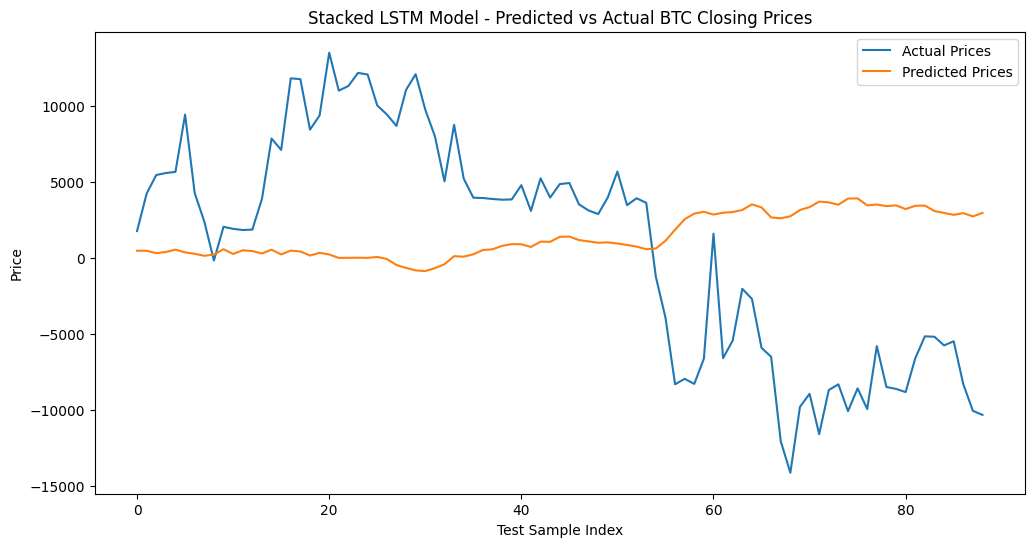

In [58]:
print("\nChecking some test predictions - Stacked LSTM\n")

for day_index in range(5):
    print(f"Sample {day_index+1}")
    print("Last 10 days input (closing price):", X_test[day_index].flatten())
    print(f"Actual BTC closing price      : {y_test_inverse[day_index]}")
    print(f"Predicted BTC closing price   : {y_pred_inverse[day_index]}\n")

# Plotting actual vs predicted prices on test set
plt.figure(figsize=(12, 6))
plt.plot(y_test_inverse, label='Actual Prices')
plt.plot(y_pred_inverse, label='Predicted Prices')
plt.title('Stacked LSTM Model - Predicted vs Actual BTC Closing Prices')
plt.xlabel('Test Sample Index')
plt.ylabel('Price')
plt.legend()
plt.show()

---

# Section: 4.Transformer Model with stationery data.ipynb


**Checking whether data is stationery or not stationery and if found stationery then applying Differencing**

In [59]:
from statsmodels.tsa.stattools import adfuller

#Extracting the closing btc price series
closing_series = btc_cc['Close']

#Making the btc series to stationary (apply differencing if needed)
def btc_stationary(series, max_diffs=2):
    initial_btc_series = series.dropna().copy()
    difference_applied = 0

    for i in range(max_diffs + 1):
        result = adfuller(initial_btc_series)
        p_value = result[1]

        print(f"\nAugmented Dickey-Fuller (ADF) Test{i+1}:")
        print(f"ADF Statistic: {result[0]:.4f}")
        print(f"p-value: {p_value:.4f}")
        if p_value <= 0.05:
            print("Bitcoin series is now stationary")
            return initial_btc_series, difference_applied
        elif i < max_diffs:
            print("Bitcoin series is not stationary. Applying differencing...")
            initial_btc_series = pd.Series(np.diff(initial_btc_series), index=initial_btc_series.index[1:])
            difference_applied += 1

    raise ValueError("Could not make the Bitcoin series stationary")

try:
    print("Checking stationarity of original BTC closing price series...")
    close_stationary, difference_needed = btc_stationary(btc_cc['Close'])

    print(f"\n Successfully made series stationary with {difference_needed} difference(s)")
    print("Proceeding with next steps...")

    # Replace the original closing prices with the stationary version
    btc_cc = btc_cc.iloc[difference_needed:]  # Align with differencing
    btc_cc['Close'] = close_stationary.values

except ValueError as e:
    print(f"\n Error: {e}")
    print(" Cannot proceed with analysis - Bitcoin series is not stationary")

Checking stationarity of original BTC closing price series...

Augmented Dickey-Fuller (ADF) Test1:
ADF Statistic: -9.2114
p-value: 0.0000
Bitcoin series is now stationary

 Successfully made series stationary with 0 difference(s)
Proceeding with next steps...


In [60]:
btc_cc = btc_cc[['Date', 'Close']]
btc_cc

Date        Close
1    2014-09-18   -32.894012
2    2014-09-19   -29.644012
3    2014-09-20    14.108002
4    2014-09-21   -10.082977
5    2014-09-22     3.330994
...         ...          ...
3843 2025-03-26  -570.820312
3844 2025-03-27   276.218750
3845 2025-03-28 -2823.953125
3846 2025-03-29 -1755.562500
3847 2025-03-30  -263.062500

[3847 rows x 2 columns]

# **Sliding window one-step ahead forecasting**

In [61]:
closing_prices = btc_cc['Close'].values
dates = btc_cc['Date'].values

# In this code 10 previous days will be used to predict the next day's price
window_size = 10

# Preparing the input (X), target (y), and target date using a sliding window
X, y, y_dates = [], [], []
for current_day_index in range(window_size, len(closing_prices)):
    ten_days_window = closing_prices[current_day_index - window_size:current_day_index]  # previous 10 days
    target_day = closing_prices[current_day_index]  # next day's price
    target_date = dates[current_day_index]  # next day's date

    X.append(ten_days_window)
    y.append(target_day)
    y_dates.append(target_date)

X = np.array(X)
y = np.array(y)
y_dates = np.array(y_dates)

print(f"Input shape (X): {X.shape}")
print(f"Target shape (y): {y.shape}")
print("Example input:", X[0])
print("Expected output:", y[0])

# Reshaping X
X = X.reshape((X.shape[0], X.shape[1], 1))
print(f"Reshaped input for Transformer: {X.shape}")

Input shape (X): (3837, 10)
Target shape (y): (3837,)
Example input: [-32.89401245 -29.64401245  14.10800171 -10.08297729   3.33099365
  33.63897705 -12.58599854 -11.63098145  -7.14901733  -4.90499878]
Expected output: -22.3389892578125
Reshaped input for Transformer: (3837, 10, 1)


**DAta Splitting into Training and Testing**

In [62]:
split_date = np.datetime64('2025-01-01')
before_split_date = y_dates < split_date
from_2025_onward = y_dates >= split_date

# Splitting the dataset in to training and testing
X_train, X_test = X[before_split_date], X[from_2025_onward]
y_train, y_test = y[before_split_date], y[from_2025_onward]

print(f"\nTraining set of BTC closing prices:  X = {X_train.shape},  y = {y_train.shape}")
print(f"Testing set of BTC closing prices:   X = {X_test.shape},   y = {y_test.shape}")


Training set of BTC closing prices:  X = (3748, 10, 1),  y = (3748,)
Testing set of BTC closing prices:   X = (89, 10, 1),   y = (89,)


In [63]:
X_train

array([[[-3.28940125e+01],
        [-2.96440125e+01],
        [ 1.41080017e+01],
        ...,
        [-1.16309814e+01],
        [-7.14901733e+00],
        [-4.90499878e+00]],

       [[-2.96440125e+01],
        [ 1.41080017e+01],
        [-1.00829773e+01],
        ...,
        [-7.14901733e+00],
        [-4.90499878e+00],
        [-2.23389893e+01]],

       [[ 1.41080017e+01],
        [-1.00829773e+01],
        [ 3.33099365e+00],
        ...,
        [-4.90499878e+00],
        [-2.23389893e+01],
        [-1.71398926e+00]],

       ...,

       [[-2.55058594e+03],
        [ 2.64976562e+02],
        [-5.31203125e+02],
        ...,
        [-3.50367969e+03],
        [-1.63065625e+03],
        [ 9.99070312e+02]],

       [[ 2.64976562e+02],
        [-5.31203125e+02],
        [-2.11978906e+03],
        ...,
        [-1.63065625e+03],
        [ 9.99070312e+02],
        [-1.63370312e+03]],

       [[-5.31203125e+02],
        [-2.11978906e+03],
        [-4.18695312e+02],
        ...,
        

In [64]:
y_test

array([  990.5546875,  2467.1171875,  1220.5546875,   128.796875 ,
          78.734375 ,  3763.125    , -5155.3828125, -1879.1796875,
       -2559.484375 ,  2217.4140625,  -134.859375 ,   -78.15625  ,
          28.0859375,  2017.5234375,  3970.4453125,  -747.5859375,
        4705.1328125,   -53.96875  , -3318.4609375,   927.0546875,
        4129.6015625, -2493.1953125,   307.1015625,   859.3125   ,
        -104.8359375, -2032.1484375,  -594.8125   ,  -755.2109375,
        2370.734375 ,  1032.09375  , -2330.28125  , -1749.1171875,
       -2966.9296875,  3716.4453125, -3533.6015625, -1256.375    ,
         -22.1484375,   -64.2109375,   -46.6328125,    17.640625 ,
         937.4609375, -1690.125    ,  2138.4296875, -1261.9921875,
         885.1015625,    71.3828125, -1405.3203125,  -401.6484375,
        -233.8359375,  1096.0625   ,  1698.328125 , -2208.390625 ,
         452.2109375,  -303.8359375, -4855.75     , -2682.       ,
       -4389.1484375,   357.203125 ,  -331.21875  ,  1658.9062

# **Transformer Regression Model**

In [65]:
#Building a Transformer-style model for Bitcoin price prediction using block-wise attention

def BTC_Transformer(input_shape, num_blocks):
    input_layer = Input(shape=input_shape)
    block_attention_outputs = []

    time_steps = input_shape[0]
    block_size = time_steps // num_blocks

    # Go through the input in blocks
    for block_index in range(num_blocks):
        start_index = block_index * block_size
        end_index = (block_index + 1) * block_size
        time_block = Lambda(lambda x: x[:, start_index:end_index, :])(input_layer)
        attention_output = Attention()([time_block, time_block])
        block_attention_outputs.append(attention_output)

    merged_blocks = Concatenate(axis=1)(block_attention_outputs)
    compressed_time_vector = GlobalAveragePooling1D()(merged_blocks)
    output_layer = Dense(1)(compressed_time_vector) #(eg: next BTC price)

    # Build and return the transformer model
    transformer_model = Model(inputs=input_layer, outputs=output_layer)
    return transformer_model

In [66]:
input_shape = X_train.shape[1:]
epochs = 50
batch_size = 32

**Transformer with one attention block**

Epoch 1/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 1489388.8750 - mae: 592.2914 - val_loss: 4047018.0000 - val_mae: 1357.4614
Epoch 2/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 1530279.3750 - mae: 594.2726 - val_loss: 3804454.2500 - val_mae: 1313.5310
Epoch 3/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 1275868.3750 - mae: 535.9625 - val_loss: 3577629.2500 - val_mae: 1270.7523
Epoch 4/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 1484195.1250 - mae: 575.6582 - val_loss: 3373606.0000 - val_mae: 1230.7423
Epoch 5/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 1180405.8750 - mae: 533.5446 - val_loss: 3193671.0000 - val_mae: 1193.6333
Epoch 6/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1185626.6250 - mae: 517.8797 - val_loss: 3030839.7500 - val_mae: 1158.4717
Epoch 7/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1021092.2500 - mae: 477.8354 - val_loss: 2885035.7500 - val_mae: 1125.2837
Epoch 8/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1034156.500

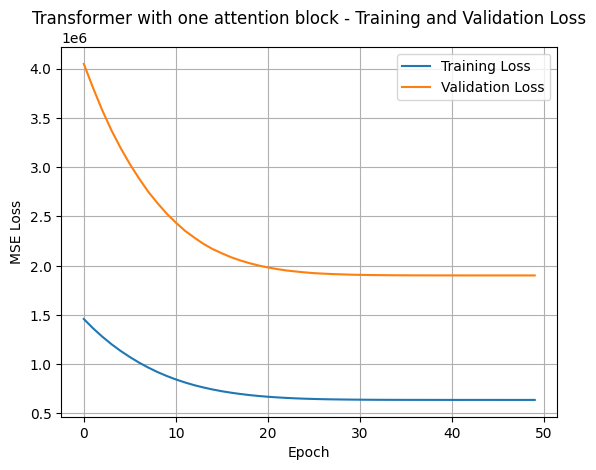

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step

 Metrics: Transformer with one attention block:
MAE  - 5998.1389
MSE  - 46745462.4380
RMSE - 6837.0653
R²   - 0.1325
MAPE - 94.85%



In [67]:
one_block_transformer = BTC_Transformer(input_shape, num_blocks=1)
one_block_transformer.compile(optimizer=Adam(learning_rate=0.001), loss='mse', metrics=['mae'])
history_one_block_transformer = one_block_transformer.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_split=0.2, verbose=1)

# Plotting training and validation loss over epochs
plt.plot(history_one_block_transformer.history['loss'], label='Training Loss')
plt.plot(history_one_block_transformer.history['val_loss'], label='Validation Loss')
plt.title('Transformer with one attention block - Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.legend()
plt.grid(True)
plt.show()

#Predicting the closing price of BTC
y_pred = one_block_transformer.predict(X_test).flatten()

# Inverse differencing
last_train_price = btc_cc['Close'].iloc[len(btc_cc) - len(y_test) - 1]
y_pred_inverse = np.r_[last_train_price, y_pred].cumsum()[1:]
y_test_inverse = np.r_[last_train_price, y_test].cumsum()[1:]

print(f"\n Metrics: Transformer with one attention block:")
mae = mean_absolute_error(y_test_inverse, y_pred_inverse)
print(f"MAE  - {mae:.4f}")
mse = mean_squared_error(y_test_inverse, y_pred_inverse)
print(f"MSE  - {mse:.4f}")
rmse = math.sqrt(mse)
print(f"RMSE - {rmse:.4f}")
r2 = r2_score(y_test_inverse, y_pred_inverse)
print(f"R²   - {r2:.4f}")
mape = mean_absolute_percentage_error(y_test_inverse, y_pred_inverse) * 100
print(f"MAPE - {mape:.2f}%\n")


Some test predictions of Transformer with one attenton block

Sample 1
Last 10 days input (closing btc price): [-2119.7890625  -418.6953125  3989.8515625   623.1015625 -3503.6796875
 -1630.65625     999.0703125 -1633.703125   -887.015625    785.9921875]
Actual BTC closing price      : 1776.546875
Predicted BTC closing price   : 767.5652141571045

Sample 2
Last 10 days input (closing btc price): [ -418.6953125  3989.8515625   623.1015625 -3503.6796875 -1630.65625
   999.0703125 -1633.703125   -887.015625    785.9921875   990.5546875]
Actual BTC closing price      : 4243.6640625
Predicted BTC closing price   : 776.8153009414673

Sample 3
Last 10 days input (closing btc price): [ 3989.8515625   623.1015625 -3503.6796875 -1630.65625     999.0703125
 -1633.703125   -887.015625    785.9921875   990.5546875  2467.1171875]
Actual BTC closing price      : 5464.21875
Predicted BTC closing price   : 813.7424478530884

Sample 4
Last 10 days input (closing btc price): [  623.1015625 -3503.6796875 

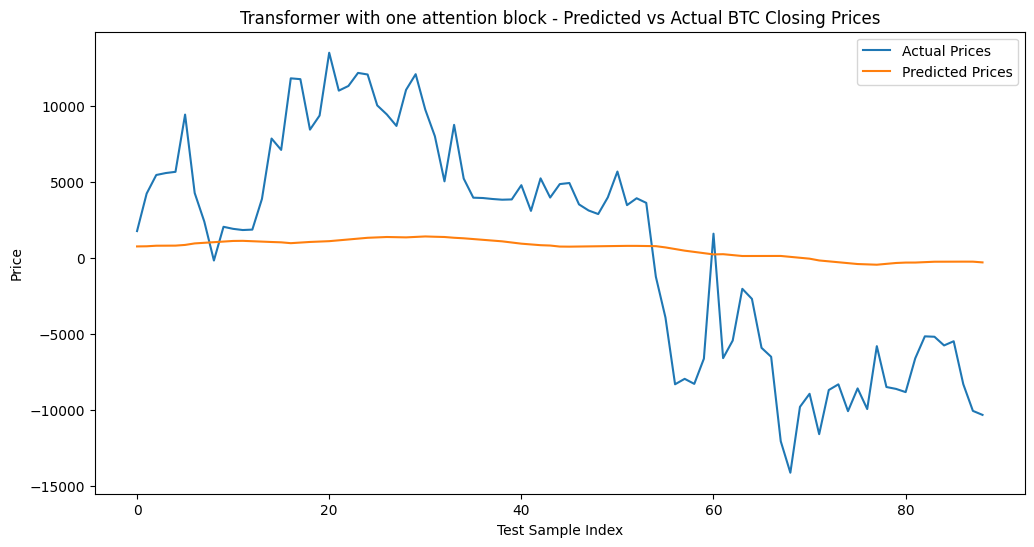

In [68]:
print("\nSome test predictions of Transformer with one attenton block\n")

for day_index in range(5):
    print(f"Sample {day_index+1}")
    print("Last 10 days input (closing btc price):", X_test[day_index].flatten())
    print(f"Actual BTC closing price      : {y_test_inverse[day_index]}")
    print(f"Predicted BTC closing price   : {y_pred_inverse[day_index]}\n")

# Plotting actual vs predicted prices on test set
plt.figure(figsize=(12, 6))
plt.plot(y_test_inverse, label='Actual Prices')
plt.plot(y_pred_inverse, label='Predicted Prices')
plt.title('Transformer with one attention block - Predicted vs Actual BTC Closing Prices')
plt.xlabel('Test Sample Index')
plt.ylabel('Price')
plt.legend()
plt.show()

**Transformer with two attention blocks**

Epoch 1/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1140814.2500 - mae: 509.8814 - val_loss: 3139082.2500 - val_mae: 1193.0553
Epoch 2/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 955340.0000 - mae: 464.7223 - val_loss: 2944787.5000 - val_mae: 1153.8186
Epoch 3/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 956645.0000 - mae: 466.1616 - val_loss: 2778316.0000 - val_mae: 1119.0024
Epoch 4/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1019315.0000 - mae: 477.6655 - val_loss: 2626494.0000 - val_mae: 1084.9611
Epoch 5/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 829572.6875 - mae: 426.2791 - val_loss: 2502439.7500 - val_mae: 1055.1937
Epoch 6/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 822403.8750 - mae: 426.5239 - val_loss: 2389517.7500 - val_mae: 1027.3667
Epoch 7/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 832317.5625 - mae: 416.7207 - val_loss: 2302502.5000 - val_mae: 1005.2623
Epoch 8/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 779065.5625 - ma

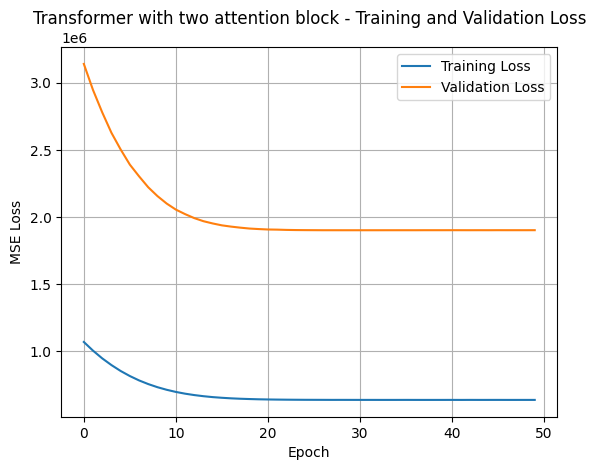

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step

 Metrics: Transformer with two attention block:
MAE  - 6294.9167
MSE  - 51345749.5091
RMSE - 7165.5948
R²   - 0.0471
MAPE - 99.00%



In [69]:
two_block_transformer = BTC_Transformer(input_shape, num_blocks=2)
two_block_transformer.compile(optimizer=Adam(learning_rate=0.001), loss='mse', metrics=['mae'])
history_two_block_transformer = two_block_transformer.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_split=0.2, verbose=1)

# Plotting training and validation loss over epochs
plt.plot(history_two_block_transformer.history['loss'], label='Training Loss')
plt.plot(history_two_block_transformer.history['val_loss'], label='Validation Loss')
plt.title('Transformer with two attention block - Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.legend()
plt.grid(True)
plt.show()

#Predicting the closing price of BTC
y_pred = two_block_transformer.predict(X_test).flatten()

# Inverse differencing
last_train_price = btc_cc['Close'].iloc[len(btc_cc) - len(y_test) - 1]
y_pred_inverse = np.r_[last_train_price, y_pred].cumsum()[1:]
y_test_inverse = np.r_[last_train_price, y_test].cumsum()[1:]

print(f"\n Metrics: Transformer with two attention block:")
mae = mean_absolute_error(y_test_inverse, y_pred_inverse)
print(f"MAE  - {mae:.4f}")
mse = mean_squared_error(y_test_inverse, y_pred_inverse)
print(f"MSE  - {mse:.4f}")
rmse = math.sqrt(mse)
print(f"RMSE - {rmse:.4f}")
r2 = r2_score(y_test_inverse, y_pred_inverse)
print(f"R²   - {r2:.4f}")
mape = mean_absolute_percentage_error(y_test_inverse, y_pred_inverse) * 100
print(f"MAPE - {mape:.2f}%\n")


Some test predictions of Transformer with two attenton block

Sample 1
Last 10 days input (closing btc price): [-2119.7890625  -418.6953125  3989.8515625   623.1015625 -3503.6796875
 -1630.65625     999.0703125 -1633.703125   -887.015625    785.9921875]
Actual BTC closing price      : 1776.546875
Predicted BTC closing price   : 777.0345287322998

Sample 2
Last 10 days input (closing btc price): [ -418.6953125  3989.8515625   623.1015625 -3503.6796875 -1630.65625
   999.0703125 -1633.703125   -887.015625    785.9921875   990.5546875]
Actual BTC closing price      : 4243.6640625
Predicted BTC closing price   : 776.2943988442421

Sample 3
Last 10 days input (closing btc price): [ 3989.8515625   623.1015625 -3503.6796875 -1630.65625     999.0703125
 -1633.703125   -887.015625    785.9921875   990.5546875  2467.1171875]
Actual BTC closing price      : 5464.21875
Predicted BTC closing price   : 789.3006663918495

Sample 4
Last 10 days input (closing btc price): [  623.1015625 -3503.6796875 

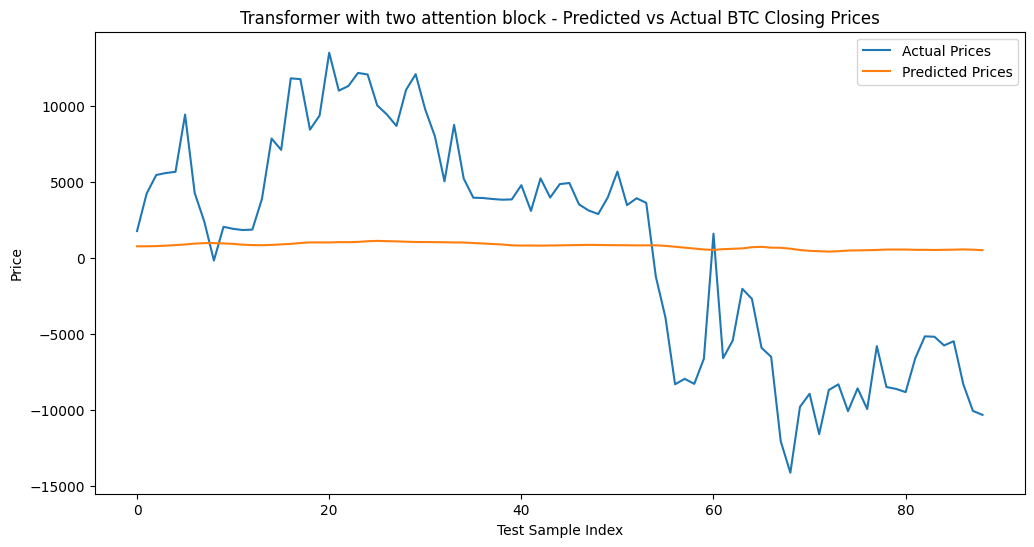

In [70]:
print("\nSome test predictions of Transformer with two attenton block\n")

for day_index in range(5):
    print(f"Sample {day_index+1}")
    print("Last 10 days input (closing btc price):", X_test[day_index].flatten())
    print(f"Actual BTC closing price      : {y_test_inverse[day_index]}")
    print(f"Predicted BTC closing price   : {y_pred_inverse[day_index]}\n")

# Plotting actual vs predicted prices on test set
plt.figure(figsize=(12, 6))
plt.plot(y_test_inverse, label='Actual Prices')
plt.plot(y_pred_inverse, label='Predicted Prices')
plt.title('Transformer with two attention block - Predicted vs Actual BTC Closing Prices')
plt.xlabel('Test Sample Index')
plt.ylabel('Price')
plt.legend()
plt.show()

**Transformer with three attention blocks**

Epoch 1/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 654921.6875 - mae: 364.9981 - val_loss: 1973702.6250 - val_mae: 887.3763
Epoch 2/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 532273.5000 - mae: 330.5219 - val_loss: 1948377.2500 - val_mae: 880.3766
Epoch 3/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 658918.8750 - mae: 369.3353 - val_loss: 1932750.8750 - val_mae: 876.2225
Epoch 4/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 567998.0625 - mae: 344.8661 - val_loss: 1923610.5000 - val_mae: 873.8687
Epoch 5/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 628742.1875 - mae: 360.0957 - val_loss: 1915579.2500 - val_mae: 871.9380
Epoch 6/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 599760.1250 - mae: 353.0275 - val_loss: 1910739.7500 - val_mae: 870.7883
Epoch 7/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 623760.7500 - mae: 357.7663 - val_loss: 1907155.7500 - val_mae: 870.0544
Epoch 8/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 709605.8125 - mae: 372.41

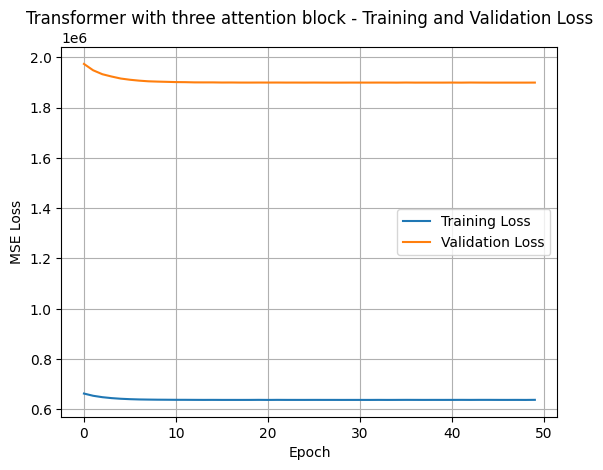

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step

 Metrics: Transformer with three attention block:
MAE  - 6234.2949
MSE  - 50453817.9715
RMSE - 7103.0851
R²   - 0.0636
MAPE - 99.14%



In [71]:
three_block_transformer = BTC_Transformer(input_shape, num_blocks=3)
three_block_transformer.compile(optimizer=Adam(learning_rate=0.001), loss='mse', metrics=['mae'])
history_three_block_transformer = three_block_transformer.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_split=0.2, verbose=1)

# Plotting training and validation loss over epochs
plt.plot(history_three_block_transformer.history['loss'], label='Training Loss')
plt.plot(history_three_block_transformer.history['val_loss'], label='Validation Loss')
plt.title('Transformer with three attention block - Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.legend()
plt.grid(True)
plt.show()

#Predicting the closing price of BTC
y_pred = three_block_transformer.predict(X_test).flatten()

# Inverse differencing
last_train_price = btc_cc['Close'].iloc[len(btc_cc) - len(y_test) - 1]
y_pred_inverse = np.r_[last_train_price, y_pred].cumsum()[1:]
y_test_inverse = np.r_[last_train_price, y_test].cumsum()[1:]

print(f"\n Metrics: Transformer with three attention block:")
mae = mean_absolute_error(y_test_inverse, y_pred_inverse)
print(f"MAE  - {mae:.4f}")
mse = mean_squared_error(y_test_inverse, y_pred_inverse)
print(f"MSE  - {mse:.4f}")
rmse = math.sqrt(mse)
print(f"RMSE - {rmse:.4f}")
r2 = r2_score(y_test_inverse, y_pred_inverse)
print(f"R²   - {r2:.4f}")
mape = mean_absolute_percentage_error(y_test_inverse, y_pred_inverse) * 100
print(f"MAPE - {mape:.2f}%\n")


Some test predictions of Transformer with three attenton block

Sample 1
Last 10 days input (closing btc price): [-2119.7890625  -418.6953125  3989.8515625   623.1015625 -3503.6796875
 -1630.65625     999.0703125 -1633.703125   -887.015625    785.9921875]
Actual BTC closing price      : 1776.546875
Predicted BTC closing price   : 764.6153945922852

Sample 2
Last 10 days input (closing btc price): [ -418.6953125  3989.8515625   623.1015625 -3503.6796875 -1630.65625
   999.0703125 -1633.703125   -887.015625    785.9921875   990.5546875]
Actual BTC closing price      : 4243.6640625
Predicted BTC closing price   : 741.2136631011963

Sample 3
Last 10 days input (closing btc price): [ 3989.8515625   623.1015625 -3503.6796875 -1630.65625     999.0703125
 -1633.703125   -887.015625    785.9921875   990.5546875  2467.1171875]
Actual BTC closing price      : 5464.21875
Predicted BTC closing price   : 751.7909574508667

Sample 4
Last 10 days input (closing btc price): [  623.1015625 -3503.679687

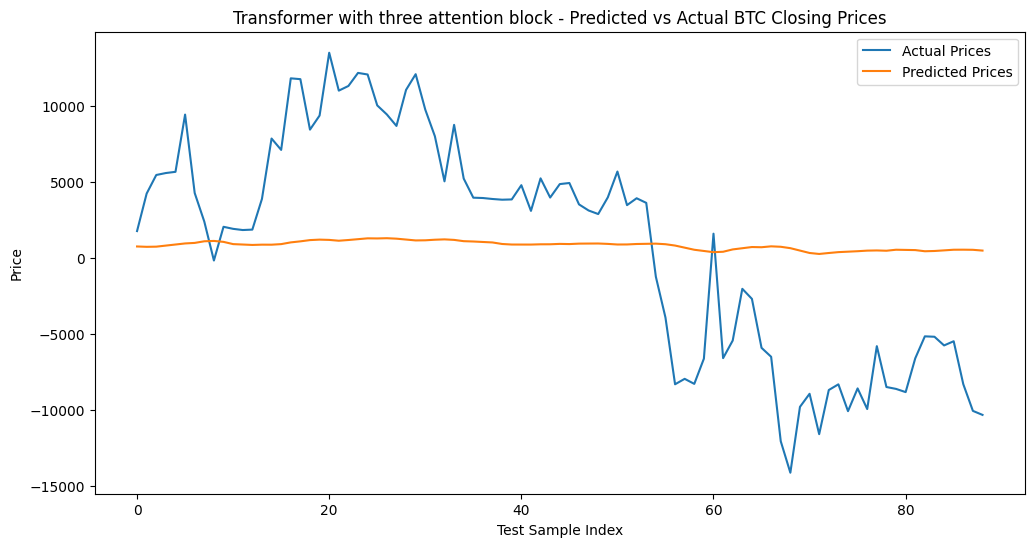

In [72]:
print("\nSome test predictions of Transformer with three attenton block\n")

for day_index in range(5):
    print(f"Sample {day_index+1}")
    print("Last 10 days input (closing btc price):", X_test[day_index].flatten())
    print(f"Actual BTC closing price      : {y_test_inverse[day_index]}")
    print(f"Predicted BTC closing price   : {y_pred_inverse[day_index]}\n")

# Plotting actual vs predicted prices on test set
plt.figure(figsize=(12, 6))
plt.plot(y_test_inverse, label='Actual Prices')
plt.plot(y_pred_inverse, label='Predicted Prices')
plt.title('Transformer with three attention block - Predicted vs Actual BTC Closing Prices')
plt.xlabel('Test Sample Index')
plt.ylabel('Price')
plt.legend()
plt.show()

**Transformer with four attention blocks**

Epoch 1/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 686226.3125 - mae: 369.8580 - val_loss: 2023438.0000 - val_mae: 910.7211
Epoch 2/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 642234.1875 - mae: 365.1116 - val_loss: 1985436.6250 - val_mae: 898.3994
Epoch 3/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 626148.6875 - mae: 355.8595 - val_loss: 1962174.6250 - val_mae: 890.7991
Epoch 4/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 688336.4375 - mae: 370.2381 - val_loss: 1944320.0000 - val_mae: 884.6547
Epoch 5/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 587493.8750 - mae: 344.1088 - val_loss: 1933250.5000 - val_mae: 881.1096
Epoch 6/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 622821.2500 - mae: 362.1724 - val_loss: 1925739.0000 - val_mae: 878.5749
Epoch 7/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 636426.3750 - mae: 357.9748 - val_loss: 1918126.7500 - val_mae: 875.7189
Epoch 8/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 590113.9375 - mae: 343.35

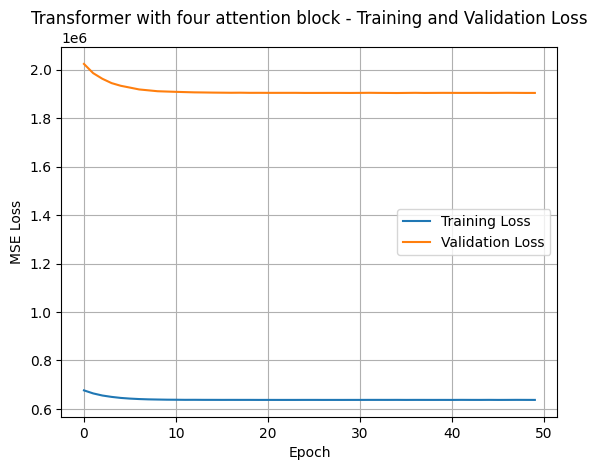

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step

 Metrics: Transformer with four attention block:
MAE  - 6245.5451
MSE  - 50476224.3629
RMSE - 7104.6622
R²   - 0.0632
MAPE - 98.96%



In [73]:
four_block_transformer = BTC_Transformer(input_shape, num_blocks=4)
four_block_transformer.compile(optimizer=Adam(learning_rate=0.001), loss='mse', metrics=['mae'])
history_four_block_transformer = four_block_transformer.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_split=0.2, verbose=1)

# Plotting training and validation loss over epochs
plt.plot(history_four_block_transformer.history['loss'], label='Training Loss')
plt.plot(history_four_block_transformer.history['val_loss'], label='Validation Loss')
plt.title('Transformer with four attention block - Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.legend()
plt.grid(True)
plt.show()

#Predicting the closing price of BTC
y_pred = four_block_transformer.predict(X_test).flatten()

# Inverse differencing
last_train_price = btc_cc['Close'].iloc[len(btc_cc) - len(y_test) - 1]
y_pred_inverse = np.r_[last_train_price, y_pred].cumsum()[1:]
y_test_inverse = np.r_[last_train_price, y_test].cumsum()[1:]

print(f"\n Metrics: Transformer with four attention block:")
mae = mean_absolute_error(y_test_inverse, y_pred_inverse)
print(f"MAE  - {mae:.4f}")
mse = mean_squared_error(y_test_inverse, y_pred_inverse)
print(f"MSE  - {mse:.4f}")
rmse = math.sqrt(mse)
print(f"RMSE - {rmse:.4f}")
r2 = r2_score(y_test_inverse, y_pred_inverse)
print(f"R²   - {r2:.4f}")
mape = mean_absolute_percentage_error(y_test_inverse, y_pred_inverse) * 100
print(f"MAPE - {mape:.2f}%\n")


Some test predictions of Transformer with four attenton block

Sample 1
Last 10 days input (closing btc price): [-2119.7890625  -418.6953125  3989.8515625   623.1015625 -3503.6796875
 -1630.65625     999.0703125 -1633.703125   -887.015625    785.9921875]
Actual BTC closing price      : 1776.546875
Predicted BTC closing price   : 776.7632598876953

Sample 2
Last 10 days input (closing btc price): [ -418.6953125  3989.8515625   623.1015625 -3503.6796875 -1630.65625
   999.0703125 -1633.703125   -887.015625    785.9921875   990.5546875]
Actual BTC closing price      : 4243.6640625
Predicted BTC closing price   : 728.4992523193359

Sample 3
Last 10 days input (closing btc price): [ 3989.8515625   623.1015625 -3503.6796875 -1630.65625     999.0703125
 -1633.703125   -887.015625    785.9921875   990.5546875  2467.1171875]
Actual BTC closing price      : 5464.21875
Predicted BTC closing price   : 727.181937456131

Sample 4
Last 10 days input (closing btc price): [  623.1015625 -3503.6796875 

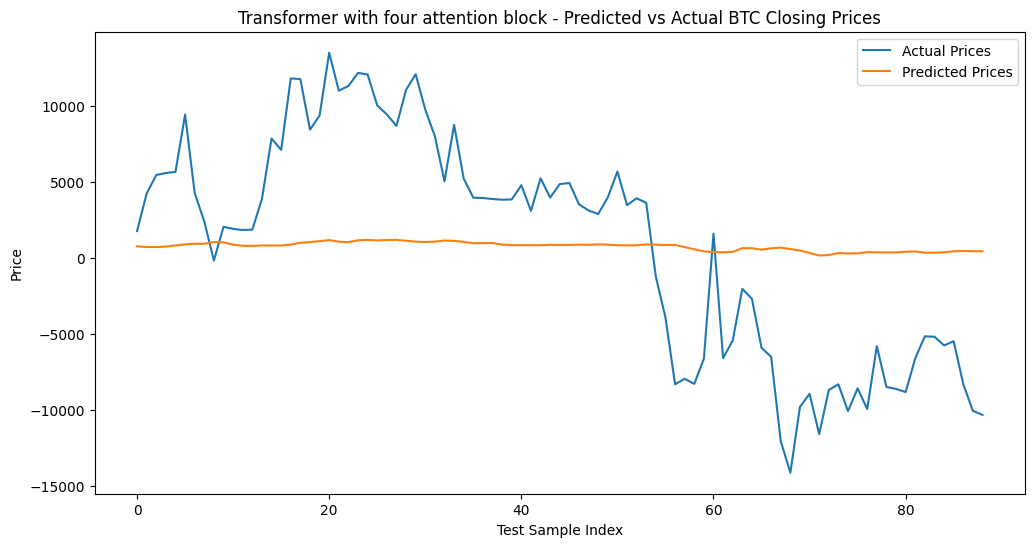

In [74]:
print("\nSome test predictions of Transformer with four attenton block\n")

for day_index in range(5):
    print(f"Sample {day_index+1}")
    print("Last 10 days input (closing btc price):", X_test[day_index].flatten())
    print(f"Actual BTC closing price      : {y_test_inverse[day_index]}")
    print(f"Predicted BTC closing price   : {y_pred_inverse[day_index]}\n")

# Plotting actual vs predicted prices on test set
plt.figure(figsize=(12, 6))
plt.plot(y_test_inverse, label='Actual Prices')
plt.plot(y_pred_inverse, label='Predicted Prices')
plt.title('Transformer with four attention block - Predicted vs Actual BTC Closing Prices')
plt.xlabel('Test Sample Index')
plt.ylabel('Price')
plt.legend()
plt.show()

**Transformer with five attention blocks**

Epoch 1/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 2139540.0000 - mae: 675.0562 - val_loss: 5870036.5000 - val_mae: 1610.0233
Epoch 2/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 1951930.2500 - mae: 658.1667 - val_loss: 5490851.0000 - val_mae: 1559.0415
Epoch 3/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1890568.3750 - mae: 637.6346 - val_loss: 5159982.5000 - val_mae: 1512.3804
Epoch 4/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1678529.6250 - mae: 623.1553 - val_loss: 4839306.0000 - val_mae: 1464.9410
Epoch 5/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1659193.7500 - mae: 587.8311 - val_loss: 4542635.5000 - val_mae: 1419.3030
Epoch 6/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1568366.8750 - mae: 588.0894 - val_loss: 4268638.5000 - val_mae: 1375.3447
Epoch 7/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1430904.7500 - mae: 548.9210 - val_loss: 4021215.0000 - val_mae: 1334.7565
Epoch 8/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1374300.125

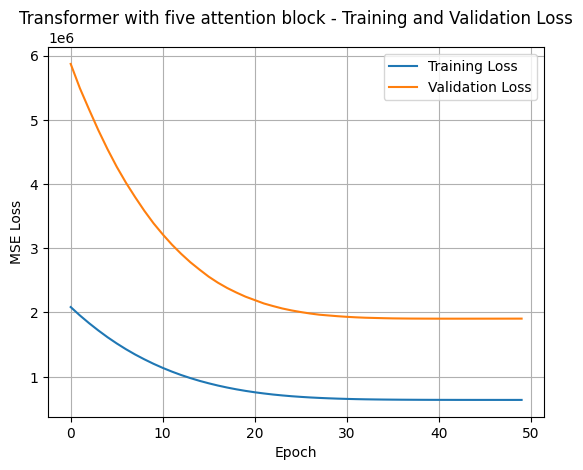

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step

 Metrics: Transformer with five attention block:
MAE  - 6277.4105
MSE  - 50995684.3589
RMSE - 7141.1263
R²   - 0.0536
MAPE - 99.12%



In [75]:
five_block_transformer = BTC_Transformer(input_shape, num_blocks=4)
five_block_transformer.compile(optimizer=Adam(learning_rate=0.001), loss='mse', metrics=['mae'])
history_five_block_transformer = five_block_transformer.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_split=0.2, verbose=1)

# Plotting training and validation loss over epochs
plt.plot(history_five_block_transformer.history['loss'], label='Training Loss')
plt.plot(history_five_block_transformer.history['val_loss'], label='Validation Loss')
plt.title('Transformer with five attention block - Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.legend()
plt.grid(True)
plt.show()

#Predicting the closing price of BTC
y_pred = five_block_transformer.predict(X_test).flatten()

# Inverse differencing
last_train_price = btc_cc['Close'].iloc[len(btc_cc) - len(y_test) - 1]
y_pred_inverse = np.r_[last_train_price, y_pred].cumsum()[1:]
y_test_inverse = np.r_[last_train_price, y_test].cumsum()[1:]

print(f"\n Metrics: Transformer with five attention block:")
mae = mean_absolute_error(y_test_inverse, y_pred_inverse)
print(f"MAE  - {mae:.4f}")
mse = mean_squared_error(y_test_inverse, y_pred_inverse)
print(f"MSE  - {mse:.4f}")
rmse = math.sqrt(mse)
print(f"RMSE - {rmse:.4f}")
r2 = r2_score(y_test_inverse, y_pred_inverse)
print(f"R²   - {r2:.4f}")
mape = mean_absolute_percentage_error(y_test_inverse, y_pred_inverse) * 100
print(f"MAPE - {mape:.2f}%\n")


Some test predictions of Transformer with five attenton block

Sample 1
Last 10 days input (closing btc price): [-2119.7890625  -418.6953125  3989.8515625   623.1015625 -3503.6796875
 -1630.65625     999.0703125 -1633.703125   -887.015625    785.9921875]
Actual BTC closing price      : 1776.546875
Predicted BTC closing price   : 778.2057948112488

Sample 2
Last 10 days input (closing btc price): [ -418.6953125  3989.8515625   623.1015625 -3503.6796875 -1630.65625
   999.0703125 -1633.703125   -887.015625    785.9921875   990.5546875]
Actual BTC closing price      : 4243.6640625
Predicted BTC closing price   : 737.2815508842468

Sample 3
Last 10 days input (closing btc price): [ 3989.8515625   623.1015625 -3503.6796875 -1630.65625     999.0703125
 -1633.703125   -887.015625    785.9921875   990.5546875  2467.1171875]
Actual BTC closing price      : 5464.21875
Predicted BTC closing price   : 736.2115225791931

Sample 4
Last 10 days input (closing btc price): [  623.1015625 -3503.6796875

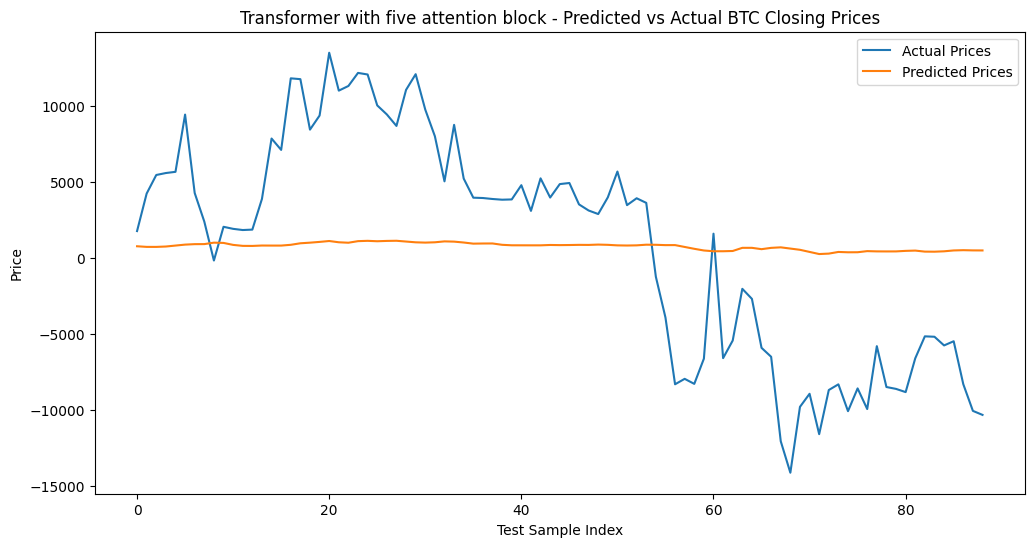

In [76]:
print("\nSome test predictions of Transformer with five attenton block\n")

for day_index in range(5):
    print(f"Sample {day_index+1}")
    print("Last 10 days input (closing btc price):", X_test[day_index].flatten())
    print(f"Actual BTC closing price      : {y_test_inverse[day_index]}")
    print(f"Predicted BTC closing price   : {y_pred_inverse[day_index]}\n")

# Plotting actual vs predicted prices on test set
plt.figure(figsize=(12, 6))
plt.plot(y_test_inverse, label='Actual Prices')
plt.plot(y_pred_inverse, label='Predicted Prices')
plt.title('Transformer with five attention block - Predicted vs Actual BTC Closing Prices')
plt.xlabel('Test Sample Index')
plt.ylabel('Price')
plt.legend()
plt.show()

---

# Section: 5.Included Validation set Evaluation - LSTM models(Uni, Bi and Stacked).ipynb


In [77]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings as warn
warn.filterwarnings('ignore')
from sklearn.preprocessing import RobustScaler
import math
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Bidirectional
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error

# Importing and Saving the BTC-USD historical price data from Yahoo Finance

In [78]:
btc_cc = yf.download("BTC-USD", start="2014-09-17", end="2025-03-31", auto_adjust=False)
btc_cc

[*********************100%***********************]  1 of 1 completed


Price          Adj Close         Close          High           Low  \
Ticker           BTC-USD       BTC-USD       BTC-USD       BTC-USD   
Date                                                                 
2014-09-17    457.334015    457.334015    468.174011    452.421997   
2014-09-18    424.440002    424.440002    456.859985    413.104004   
2014-09-19    394.795990    394.795990    427.834991    384.532013   
2014-09-20    408.903992    408.903992    423.295990    389.882996   
2014-09-21    398.821014    398.821014    412.425995    393.181000   
...                  ...           ...           ...           ...   
2025-03-26  86900.882812  86900.882812  88292.156250  85861.453125   
2025-03-27  87177.101562  87177.101562  87786.726562  85837.937500   
2025-03-28  84353.148438  84353.148438  87489.859375  83557.640625   
2025-03-29  82597.585938  82597.585938  84567.335938  81634.140625   
2025-03-30  82334.523438  82334.523438  83505.000000  81573.250000   

Price               Open       Volume  
Ticker           BTC-USD      BTC-USD  
Date                                   
2014-09-17    465.864014     21056800  
2014-09-18    456.859985     34483200  
2014-09-19    424.102997     37919700  
2014-09-20    394.673004     36863600  
2014-09-21    408.084991     26580100  
...                  ...          ...  
2025-03-26  87460.234375  26704046038  
2025-03-27  86896.257812  24413471941  
2025-03-28  87185.234375  34198619509  
2025-03-29  84352.070312  16969396135  
2025-03-30  82596.984375  14763760943  

[3848 rows x 6 columns]

In [79]:
# Cleaning the multi-level column names
btc_cc.reset_index(inplace=True)
btc_cc.columns = ['_'.join(filter(None, column_name)).strip() if isinstance(column_name, tuple) else column_name for column_name in btc_cc.columns]
btc_cc.columns = [column_name.replace('_BTC-USD', '') for column_name in btc_cc.columns]
btc_cc

Date     Adj Close         Close          High           Low  \
0    2014-09-17    457.334015    457.334015    468.174011    452.421997   
1    2014-09-18    424.440002    424.440002    456.859985    413.104004   
2    2014-09-19    394.795990    394.795990    427.834991    384.532013   
3    2014-09-20    408.903992    408.903992    423.295990    389.882996   
4    2014-09-21    398.821014    398.821014    412.425995    393.181000   
...         ...           ...           ...           ...           ...   
3843 2025-03-26  86900.882812  86900.882812  88292.156250  85861.453125   
3844 2025-03-27  87177.101562  87177.101562  87786.726562  85837.937500   
3845 2025-03-28  84353.148438  84353.148438  87489.859375  83557.640625   
3846 2025-03-29  82597.585938  82597.585938  84567.335938  81634.140625   
3847 2025-03-30  82334.523438  82334.523438  83505.000000  81573.250000   

              Open       Volume  
0       465.864014     21056800  
1       456.859985     34483200  
2       424.102997     37919700  
3       394.673004     36863600  
4       408.084991     26580100  
...            ...          ...  
3843  87460.234375  26704046038  
3844  86896.257812  24413471941  
3845  87185.234375  34198619509  
3846  84352.070312  16969396135  
3847  82596.984375  14763760943  

[3848 rows x 7 columns]

In [80]:
btc_cc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3848 entries, 0 to 3847
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Date       3848 non-null   datetime64[ns]
 1   Adj Close  3848 non-null   float64       
 2   Close      3848 non-null   float64       
 3   High       3848 non-null   float64       
 4   Low        3848 non-null   float64       
 5   Open       3848 non-null   float64       
 6   Volume     3848 non-null   int64         
dtypes: datetime64[ns](1), float64(5), int64(1)
memory usage: 210.6 KB


Viewing the Start and End Dates in this imported BTC historical crypto trading data

In [81]:
first_date = btc_cc['Date'].min()
last_date = btc_cc['Date'].max()

print("First trading date in this BTC historical data:", first_date.date())
print("Last trading date in this BTC historical data:", last_date.date())

First trading date in this BTC historical data: 2014-09-17
Last trading date in this BTC historical data: 2025-03-30


In [82]:
btc_cc = btc_cc[['Date', 'Close']]
btc_cc.to_csv('btc_usd(date&Close).csv', index=False)
btc_cc

Date         Close
0    2014-09-17    457.334015
1    2014-09-18    424.440002
2    2014-09-19    394.795990
3    2014-09-20    408.903992
4    2014-09-21    398.821014
...         ...           ...
3843 2025-03-26  86900.882812
3844 2025-03-27  87177.101562
3845 2025-03-28  84353.148438
3846 2025-03-29  82597.585938
3847 2025-03-30  82334.523438

[3848 rows x 2 columns]

# **Sliding window one-step ahead forecasting**

In [83]:
closing_prices = btc_cc['Close'].values
dates = btc_cc['Date'].values

# In this code 10 previous days will be used to predict the next day's price
window_size = 10

# Preparing the input (X), target (y), and target date using a sliding window
X, y, y_dates = [], [], []
for current_day_index in range(window_size, len(closing_prices)):
    ten_days_window = closing_prices[current_day_index - window_size:current_day_index]  # previous 10 days
    target_day = closing_prices[current_day_index]  # next day's price
    target_date = dates[current_day_index]  # next day's date

    X.append(ten_days_window)
    y.append(target_day)
    y_dates.append(target_date)

X = np.array(X)
y = np.array(y)
y_dates = np.array(y_dates)

print(f"Input shape (X): {X.shape}")
print(f"Target shape (y): {y.shape}")
print("Example input:", X[0])
print("Expected output:", y[0])

# Reshaping X
X = X.reshape((X.shape[0], X.shape[1], 1))
print(f"Reshaped input for LSTM: {X.shape}")

Input shape (X): (3838, 10)
Target shape (y): (3838,)
Example input: [457.33401489 424.44000244 394.79598999 408.9039917  398.8210144
 402.15200806 435.79098511 423.20498657 411.57400513 404.42498779]
Expected output: 399.5199890136719
Reshaped input for LSTM: (3838, 10, 1)


**DAta Splitting into Training and Testing**

In [84]:
#Define split dates
val_start_date = np.datetime64('2024-10-01')
test_start_date = np.datetime64('2025-01-01')

# Create masks for each period
train_mask = y_dates < val_start_date
val_mask = (y_dates >= val_start_date) & (y_dates < test_start_date)
test_mask = y_dates >= test_start_date

# Split the data
X_train, X_val, X_test = X[train_mask], X[val_mask], X[test_mask]
y_train, y_val, y_test = y[train_mask], y[val_mask], y[test_mask]

# Print shapes
print(f"\nTraining set:  X = {X_train.shape},  y = {y_train.shape}")
print(f"Validation set:  X = {X_val.shape},    y = {y_val.shape}")
print(f"Testing set:     X = {X_test.shape},   y = {y_test.shape}")


Training set:  X = (3657, 10, 1),  y = (3657,)
Validation set:  X = (92, 10, 1),    y = (92,)
Testing set:     X = (89, 10, 1),   y = (89,)


**Scaling the Data using Robust Scaler**

In [85]:
X_train_reshaped = X_train.reshape(-1, X_train.shape[-1])
X_val_reshaped = X_val.reshape(-1, X_val.shape[-1])
X_test_reshaped = X_test.reshape(-1, X_test.shape[-1])

x_scaler = RobustScaler()
X_train_scaled = x_scaler.fit_transform(X_train_reshaped)
X_val_scaled = x_scaler.transform(X_val_reshaped)
X_test_scaled = x_scaler.transform(X_test_reshaped)

X_train_scaled = X_train_scaled.reshape(X_train.shape)
X_val_scaled = X_val_scaled.reshape(X_val.shape)
X_test_scaled = X_test_scaled.reshape(X_test.shape)

y_scaler = RobustScaler()
y_train_scaled = y_scaler.fit_transform(y_train.reshape(-1, 1)).flatten()
y_val_scaled = y_scaler.transform(y_val.reshape(-1, 1)).flatten()
y_test_scaled = y_scaler.transform(y_test.reshape(-1, 1)).flatten()

In [86]:
X_train_scaled

array([[[-0.31046251],
        [-0.31163273],
        [-0.31268733],
        ...,
        [-0.31167666],
        [-0.31209044],
        [-0.31234477]],

       [[-0.31163273],
        [-0.31268733],
        [-0.31218543],
        ...,
        [-0.31209044],
        [-0.31234477],
        [-0.31251927]],

       [[-0.31268733],
        [-0.31218543],
        [-0.31254414],
        ...,
        [-0.31234477],
        [-0.31251927],
        [-0.31331399]],

       ...,

       [[ 1.86648567],
        [ 1.91240572],
        [ 1.92138922],
        ...,
        [ 1.91961642],
        [ 1.99211484],
        [ 2.01380325]],

       [[ 1.91240572],
        [ 1.92138922],
        [ 1.92857061],
        ...,
        [ 1.99211484],
        [ 2.01380325],
        [ 2.01725352]],

       [[ 1.92138922],
        [ 1.92857061],
        [ 1.9376022 ],
        ...,
        [ 2.01380325],
        [ 2.01725352],
        [ 2.00827626]]])

In [87]:
X_val_scaled

array([[[1.92857061],
        [1.9376022 ],
        [1.92625681],
        [1.96084217],
        [1.91961642],
        [1.99211484],
        [2.01380325],
        [2.01725352],
        [2.00827626],
        [1.92624611]],

       [[1.9376022 ],
        [1.92625681],
        [1.96084217],
        [1.91961642],
        [1.99211484],
        [2.01380325],
        [2.01725352],
        [2.00827626],
        [1.92624611],
        [1.83757446]],

       [[1.92625681],
        [1.96084217],
        [1.91961642],
        [1.99211484],
        [2.01380325],
        [2.01725352],
        [2.00827626],
        [1.92624611],
        [1.83757446],
        [1.83030914]],

       [[1.96084217],
        [1.91961642],
        [1.99211484],
        [2.01380325],
        [2.01725352],
        [2.00827626],
        [1.92624611],
        [1.83757446],
        [1.83030914],
        [1.83481361]],

       [[1.91961642],
        [1.99211484],
        [2.01380325],
        [2.01725352],
        [2.00827626],
  

In [88]:
y_test_scaled

array([3.02455875, 3.11212517, 3.15544682, 3.16001827, 3.16281282,
       3.29637899, 3.11339683, 3.04669832, 2.95585347, 3.03455708,
       3.02977046, 3.02699642, 3.02799329, 3.09960209, 3.24052677,
       3.21399239, 3.38099363, 3.3790781 , 3.26129457, 3.29419891,
       3.44077259, 3.35228056, 3.36318065, 3.39368059, 3.3899596 ,
       3.31783171, 3.29671978, 3.26991476, 3.35406023, 3.39069276,
       3.30798312, 3.24590097, 3.14059449, 3.27250384, 3.14708424,
       3.1024912 , 3.10170508, 3.09942601, 3.09777085, 3.09839698,
       3.13167067, 3.07168236, 3.14758254, 3.10279012, 3.1342054 ,
       3.13673902, 3.0868594 , 3.07260352, 3.06430389, 3.10320689,
       3.16348636, 3.08510303, 3.10115354, 3.09036937, 2.9180222 ,
       2.82282886, 2.66704298, 2.67972134, 2.66796525, 2.7268455 ,
       3.01847495, 2.72804368, 2.76909265, 2.8898188 , 2.86632798,
       2.75207273, 2.73119982, 2.53408519, 2.46064792, 2.6143419 ,
       2.64487151, 2.5506132 , 2.65362924, 2.66690405, 2.60431

# **Unidirectional LSTM**

Epoch 1/10
115/115 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step - loss: 0.0528 - mae: 0.1037 - val_loss: 0.0346 - val_mae: 0.1437
Epoch 2/10
115/115 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step - loss: 0.0028 - mae: 0.0302 - val_loss: 0.0430 - val_mae: 0.1706
Epoch 3/10
115/115 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - loss: 0.0026 - mae: 0.0290 - val_loss: 0.0137 - val_mae: 0.0962
Epoch 4/10
115/115 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 0.0024 - mae: 0.0285 - val_loss: 0.0276 - val_mae: 0.1338
Epoch 5/10
115/115 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - loss: 0.0022 - mae: 0.0267 - val_loss: 0.0419 - val_mae: 0.1769
Epoch 6/10
115/115 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 0.0021 - mae: 0.0260 - val_loss: 0.0209 - val_mae: 0.1169
Epoch 7/10
115/115 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 0.0017 - mae: 0.0230 - val_loss: 0.0181 - val_mae: 0.1072
Epoch 8/10
115/115 ━━━━━━━━━━━━━━━━━━━━ 4s 21ms/step - loss: 0.0016 - mae: 0.0217 - val_loss: 0.0168 - val_mae: 0.1023
Epoch 9/10
115/115 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/

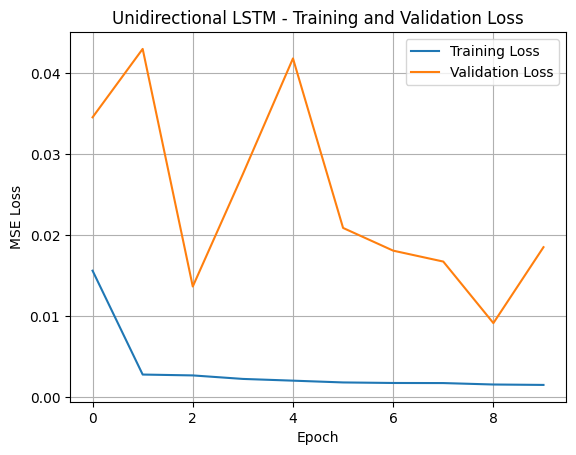

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step

 Metrics - Uni-LSTM: Validation Set
MAE  - 3110.8029
MSE  - 14716690.3479
RMSE - 3836.2339
R²   - 0.9354
MAPE - 3.64%

 Metrics - Uni-LSTM: Test Set
MAE  - 3130.7656
MSE  - 13969050.4547
RMSE - 3737.5193
R²   - 0.7408
MAPE - 3.31%


In [89]:
# Building Uni-directional LSTM model for next-day price prediction
Uni_LSTM = Sequential()
Uni_LSTM.add(LSTM(300, activation='selu', input_shape=(window_size, 1)))
Uni_LSTM.add(Dense(1))
Uni_LSTM.compile(optimizer='adam', loss='mse', metrics=['mae'])

#Training the Uni-LSTM model
history_uni_lstm = Uni_LSTM.fit(X_train_scaled, y_train_scaled, epochs=10, batch_size=32, validation_data=(X_val_scaled, y_val_scaled), verbose=1)

# Plotting training and validation loss over epochs
plt.plot(history_uni_lstm.history['loss'], label='Training Loss')
plt.plot(history_uni_lstm.history['val_loss'], label='Validation Loss')
plt.title('Unidirectional LSTM - Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.legend()
plt.grid(True)
plt.show()

#saving the trained model
Uni_LSTM.save("test2_uni_lstm_model.keras")

#Predicting the closing price of BTC on validation and test sets
y_val_pred_scaled = Uni_LSTM.predict(X_val_scaled).flatten()
y_test_pred_scaled = Uni_LSTM.predict(X_test_scaled).flatten()

#Inverse scaling
y_val_inverse = y_scaler.inverse_transform(y_val_scaled.reshape(-1, 1)).flatten()
y_val_pred_inverse = y_scaler.inverse_transform(y_val_pred_scaled.reshape(-1, 1)).flatten()
y_test_inverse = y_scaler.inverse_transform(y_test_scaled.reshape(-1, 1)).flatten()
y_test_pred_inverse = y_scaler.inverse_transform(y_test_pred_scaled.reshape(-1, 1)).flatten()

print(f"\n Metrics - Uni-LSTM: Validation Set")
mae_val = mean_absolute_error(y_val_inverse, y_val_pred_inverse)
print(f"MAE  - {mae_val:.4f}")
mse_val = mean_squared_error(y_val_inverse, y_val_pred_inverse)
print(f"MSE  - {mse_val:.4f}")
rmse_val = math.sqrt(mse_val)
print(f"RMSE - {rmse_val:.4f}")
r2_val = r2_score(y_val_inverse, y_val_pred_inverse)
print(f"R²   - {r2_val:.4f}")
mape_val = mean_absolute_percentage_error(y_val_inverse, y_val_pred_inverse) * 100
print(f"MAPE - {mape_val:.2f}%")

print(f"\n Metrics - Uni-LSTM: Test Set")
mae_test = mean_absolute_error(y_test_inverse, y_test_pred_inverse)
print(f"MAE  - {mae_test:.4f}")
mse_test = mean_squared_error(y_test_inverse, y_test_pred_inverse)
print(f"MSE  - {mse_test:.4f}")
rmse_test = math.sqrt(mse_test)
print(f"RMSE - {rmse_test:.4f}")
r2_test = r2_score(y_test_inverse, y_test_pred_inverse)
print(f"R²   - {r2_test:.4f}")
mape_test = mean_absolute_percentage_error(y_test_inverse, y_test_pred_inverse) * 100
print(f"MAPE - {mape_test:.2f}%")


Some test predictions of Unidirectionl LSTM

Sample 1
Last 10 days input (closing btc price): [3.05667313 3.04177783 3.18371879 3.20588594 3.08124079 3.02322938
 3.0587718  3.000652   2.96909598 2.99705804]
Actual BTC closing price      : 94419.7578125
Predicted BTC closing price   : 90267.8984375

Sample 2
Last 10 days input (closing btc price): [3.04177783 3.18371879 3.20588594 3.08124079 3.02322938 3.0587718
 3.000652   2.96909598 2.99705804 3.03229752]
Actual BTC closing price      : 96886.875
Predicted BTC closing price   : 91035.7578125

Sample 3
Last 10 days input (closing btc price): [3.18371879 3.20588594 3.08124079 3.02322938 3.0587718  3.000652
 2.96909598 2.99705804 3.03229752 3.12006644]
Actual BTC closing price      : 98107.4296875
Predicted BTC closing price   : 92820.0234375

Sample 4
Last 10 days input (closing btc price): [3.20588594 3.08124079 3.02322938 3.0587718  3.000652   2.96909598
 2.99705804 3.03229752 3.12006644 3.16348828]
Actual BTC closing price      : 98

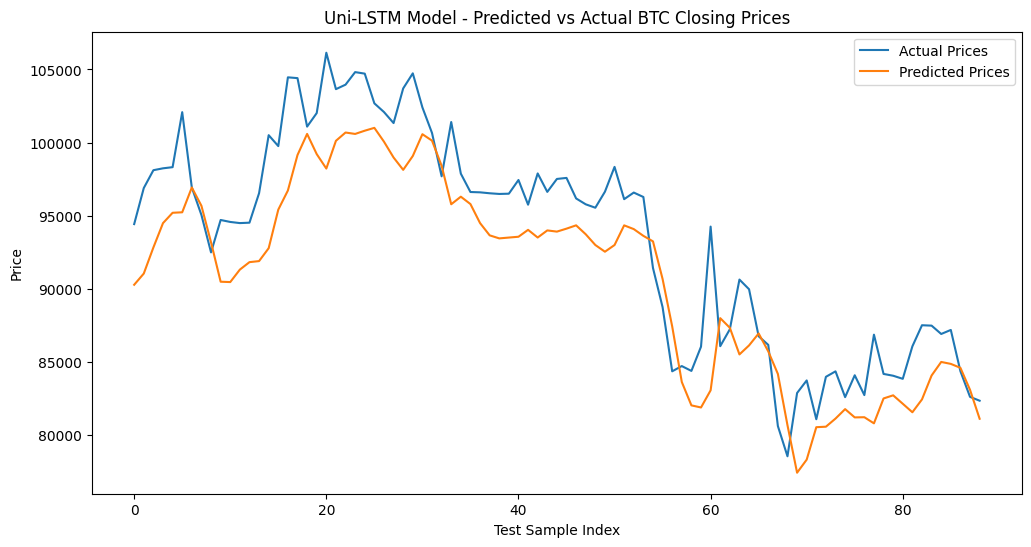

In [90]:
print("\nSome test predictions of Unidirectionl LSTM\n")

for day_index in range(5):
    print(f"Sample {day_index+1}")
    print("Last 10 days input (closing btc price):", X_test_scaled[day_index].flatten())
    print(f"Actual BTC closing price      : {y_test_inverse[day_index]}")
    print(f"Predicted BTC closing price   : {y_test_pred_inverse[day_index]}\n")

# Plotting actual vs predicted prices on test set
plt.figure(figsize=(12, 6))
plt.plot(y_test_inverse, label='Actual Prices')
plt.plot(y_test_pred_inverse, label='Predicted Prices')
plt.title('Uni-LSTM Model - Predicted vs Actual BTC Closing Prices')
plt.xlabel('Test Sample Index')
plt.ylabel('Price')
plt.legend()
plt.show()

# **Bidirectional LSTM**

Epoch 1/10
115/115 ━━━━━━━━━━━━━━━━━━━━ 8s 43ms/step - loss: 0.0628 - mae: 0.1092 - val_loss: 0.0358 - val_mae: 0.1465
Epoch 2/10
115/115 ━━━━━━━━━━━━━━━━━━━━ 5s 43ms/step - loss: 0.0035 - mae: 0.0332 - val_loss: 0.0173 - val_mae: 0.1026
Epoch 3/10
115/115 ━━━━━━━━━━━━━━━━━━━━ 5s 39ms/step - loss: 0.0028 - mae: 0.0314 - val_loss: 0.0906 - val_mae: 0.2710
Epoch 4/10
115/115 ━━━━━━━━━━━━━━━━━━━━ 5s 37ms/step - loss: 0.0036 - mae: 0.0351 - val_loss: 0.0119 - val_mae: 0.0854
Epoch 5/10
115/115 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - loss: 0.0018 - mae: 0.0242 - val_loss: 0.0189 - val_mae: 0.1082
Epoch 6/10
115/115 ━━━━━━━━━━━━━━━━━━━━ 4s 37ms/step - loss: 0.0019 - mae: 0.0244 - val_loss: 0.0093 - val_mae: 0.0759
Epoch 7/10
115/115 ━━━━━━━━━━━━━━━━━━━━ 4s 38ms/step - loss: 0.0019 - mae: 0.0246 - val_loss: 0.0139 - val_mae: 0.0928
Epoch 8/10
115/115 ━━━━━━━━━━━━━━━━━━━━ 5s 43ms/step - loss: 0.0016 - mae: 0.0234 - val_loss: 0.0116 - val_mae: 0.0831
Epoch 9/10
115/115 ━━━━━━━━━━━━━━━━━━━━ 4s 36ms/

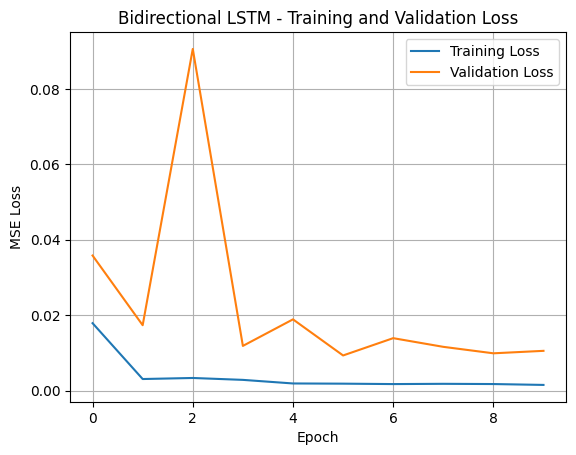

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step

 Metrics - Bi-LSTM: Validation Set
MAE  - 2248.1753
MSE  - 8371744.5649
RMSE - 2893.3967
R²   - 0.9632
MAPE - 2.62%

 Metrics - Bi-LSTM: Test Set
MAE  - 2315.6598
MSE  - 8380410.8404
RMSE - 2894.8939
R²   - 0.8445
MAPE - 2.47%


In [91]:
# Building Bi-directional LSTM model for next-day price prediction
Bi_LSTM = Sequential()
Bi_LSTM.add(Bidirectional(LSTM(300, activation='selu', input_shape=(window_size, 1))))
Bi_LSTM.add(Dense(1))
Bi_LSTM.compile(optimizer='adam', loss='mse', metrics=['mae'])

#Training the Bi-LSTM model
history_bi_lstm = Bi_LSTM.fit(X_train_scaled, y_train_scaled, epochs=10, batch_size=32, validation_data=(X_val_scaled, y_val_scaled), verbose=1)

# Plotting training and validation loss over epochs
plt.plot(history_bi_lstm.history['loss'], label='Training Loss')
plt.plot(history_bi_lstm.history['val_loss'], label='Validation Loss')
plt.title('Bidirectional LSTM - Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.legend()
plt.grid(True)
plt.show()

#saving the trained model
Bi_LSTM.save("test2_bi_lstm_model.keras")

#Predicting the closing price of BTC on validation and test sets
y_val_pred_scaled = Bi_LSTM.predict(X_val_scaled).flatten()
y_test_pred_scaled = Bi_LSTM.predict(X_test_scaled).flatten()

#Inverse scaling
y_val_inverse = y_scaler.inverse_transform(y_val_scaled.reshape(-1, 1)).flatten()
y_val_pred_inverse = y_scaler.inverse_transform(y_val_pred_scaled.reshape(-1, 1)).flatten()
y_test_inverse = y_scaler.inverse_transform(y_test_scaled.reshape(-1, 1)).flatten()
y_test_pred_inverse = y_scaler.inverse_transform(y_test_pred_scaled.reshape(-1, 1)).flatten()

print(f"\n Metrics - Bi-LSTM: Validation Set")
mae_val = mean_absolute_error(y_val_inverse, y_val_pred_inverse)
print(f"MAE  - {mae_val:.4f}")
mse_val = mean_squared_error(y_val_inverse, y_val_pred_inverse)
print(f"MSE  - {mse_val:.4f}")
rmse_val = math.sqrt(mse_val)
print(f"RMSE - {rmse_val:.4f}")
r2_val = r2_score(y_val_inverse, y_val_pred_inverse)
print(f"R²   - {r2_val:.4f}")
mape_val = mean_absolute_percentage_error(y_val_inverse, y_val_pred_inverse) * 100
print(f"MAPE - {mape_val:.2f}%")

print(f"\n Metrics - Bi-LSTM: Test Set")
mae_test = mean_absolute_error(y_test_inverse, y_test_pred_inverse)
print(f"MAE  - {mae_test:.4f}")
mse_test = mean_squared_error(y_test_inverse, y_test_pred_inverse)
print(f"MSE  - {mse_test:.4f}")
rmse_test = math.sqrt(mse_test)
print(f"RMSE - {rmse_test:.4f}")
r2_test = r2_score(y_test_inverse, y_test_pred_inverse)
print(f"R²   - {r2_test:.4f}")
mape_test = mean_absolute_percentage_error(y_test_inverse, y_test_pred_inverse) * 100
print(f"MAPE - {mape_test:.2f}%")


Some test predictions of Bidirectionl LSTM

Sample 1
Last 10 days input (closing btc price): [3.05667313 3.04177783 3.18371879 3.20588594 3.08124079 3.02322938
 3.0587718  3.000652   2.96909598 2.99705804]
Actual BTC closing price      : 94419.7578125
Predicted BTC closing price   : 91385.953125

Sample 2
Last 10 days input (closing btc price): [3.04177783 3.18371879 3.20588594 3.08124079 3.02322938 3.0587718
 3.000652   2.96909598 2.99705804 3.03229752]
Actual BTC closing price      : 96886.875
Predicted BTC closing price   : 92421.484375

Sample 3
Last 10 days input (closing btc price): [3.18371879 3.20588594 3.08124079 3.02322938 3.0587718  3.000652
 2.96909598 2.99705804 3.03229752 3.12006644]
Actual BTC closing price      : 98107.4296875
Predicted BTC closing price   : 94449.0078125

Sample 4
Last 10 days input (closing btc price): [3.20588594 3.08124079 3.02322938 3.0587718  3.000652   2.96909598
 2.99705804 3.03229752 3.12006644 3.16348828]
Actual BTC closing price      : 98236

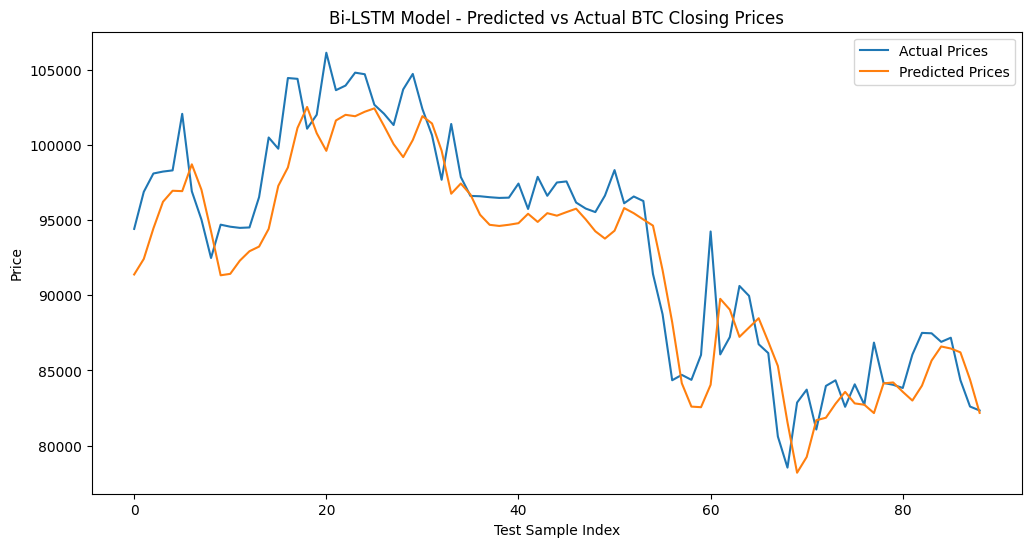

In [92]:
print("\nSome test predictions of Bidirectionl LSTM\n")

for day_index in range(5):
    print(f"Sample {day_index+1}")
    print("Last 10 days input (closing btc price):", X_test_scaled[day_index].flatten())
    print(f"Actual BTC closing price      : {y_test_inverse[day_index]}")
    print(f"Predicted BTC closing price   : {y_test_pred_inverse[day_index]}\n")

# Plotting actual vs predicted prices on test set
plt.figure(figsize=(12, 6))
plt.plot(y_test_inverse, label='Actual Prices')
plt.plot(y_test_pred_inverse, label='Predicted Prices')
plt.title('Bi-LSTM Model - Predicted vs Actual BTC Closing Prices')
plt.xlabel('Test Sample Index')
plt.ylabel('Price')
plt.legend()
plt.show()

# **Stacked LSTM**

Epoch 1/10
115/115 ━━━━━━━━━━━━━━━━━━━━ 7s 43ms/step - loss: 0.0474 - mae: 0.0938 - val_loss: 0.1189 - val_mae: 0.3120
Epoch 2/10
115/115 ━━━━━━━━━━━━━━━━━━━━ 4s 38ms/step - loss: 0.0047 - mae: 0.0399 - val_loss: 0.0568 - val_mae: 0.1992
Epoch 3/10
115/115 ━━━━━━━━━━━━━━━━━━━━ 5s 37ms/step - loss: 0.0027 - mae: 0.0291 - val_loss: 0.0121 - val_mae: 0.0867
Epoch 4/10
115/115 ━━━━━━━━━━━━━━━━━━━━ 4s 37ms/step - loss: 0.0021 - mae: 0.0249 - val_loss: 0.0130 - val_mae: 0.0893
Epoch 5/10
115/115 ━━━━━━━━━━━━━━━━━━━━ 5s 33ms/step - loss: 0.0024 - mae: 0.0276 - val_loss: 0.0127 - val_mae: 0.0879
Epoch 6/10
115/115 ━━━━━━━━━━━━━━━━━━━━ 5s 41ms/step - loss: 0.0019 - mae: 0.0241 - val_loss: 0.0080 - val_mae: 0.0694
Epoch 7/10
115/115 ━━━━━━━━━━━━━━━━━━━━ 4s 35ms/step - loss: 0.0018 - mae: 0.0237 - val_loss: 0.0142 - val_mae: 0.0929
Epoch 8/10
115/115 ━━━━━━━━━━━━━━━━━━━━ 5s 34ms/step - loss: 0.0015 - mae: 0.0219 - val_loss: 0.0291 - val_mae: 0.1478
Epoch 9/10
115/115 ━━━━━━━━━━━━━━━━━━━━ 6s 38ms/

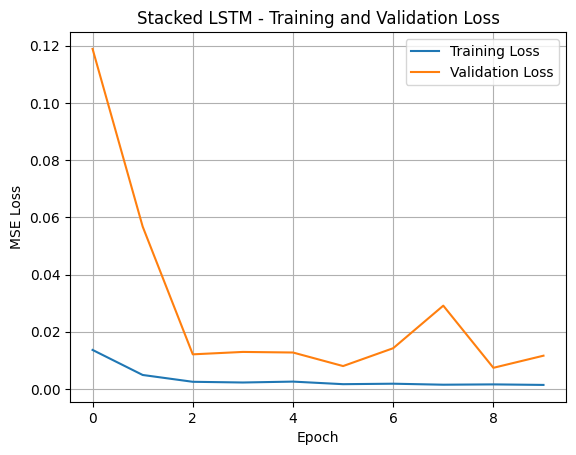

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step

 Metrics - Stacked LSTM: Validation Set
MAE  - 2248.1753
MSE  - 8371744.5649
RMSE - 2893.3967
R²   - 0.9632
MAPE - 2.62%

 Metrics - Stacked LSTM: Test Set
MAE  - 2315.6598
MSE  - 8380410.8404
RMSE - 2894.8939
R²   - 0.8445
MAPE - 2.47%


In [93]:
# Building Stacked LSTM model for next-day price prediction
stacked_LSTM = Sequential()
stacked_LSTM.add(LSTM(300, activation='selu', return_sequences=True, input_shape=(window_size, 1)))
stacked_LSTM.add(LSTM(150, activation='selu'))
stacked_LSTM.add(Dense(1))
stacked_LSTM.compile(optimizer='adam', loss='mse', metrics=['mae'])

#Training the Stacked LSTM model
history_stacked_lstm = stacked_LSTM.fit(X_train_scaled, y_train_scaled, epochs=10, batch_size=32, validation_data=(X_val_scaled, y_val_scaled), verbose=1)

# Plotting training and validation loss over epochs
plt.plot(history_stacked_lstm.history['loss'], label='Training Loss')
plt.plot(history_stacked_lstm.history['val_loss'], label='Validation Loss')
plt.title('Stacked LSTM - Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.legend()
plt.grid(True)
plt.show()

#saving the trained model
stacked_LSTM.save("test2_stacked_lstm_model.keras")

#Predicting the closing price of BTC on validation and test sets
y_val_pred_scaled = Bi_LSTM.predict(X_val_scaled).flatten()
y_test_pred_scaled = Bi_LSTM.predict(X_test_scaled).flatten()

#Inverse scaling
y_val_inverse = y_scaler.inverse_transform(y_val_scaled.reshape(-1, 1)).flatten()
y_val_pred_inverse = y_scaler.inverse_transform(y_val_pred_scaled.reshape(-1, 1)).flatten()
y_test_inverse = y_scaler.inverse_transform(y_test_scaled.reshape(-1, 1)).flatten()
y_test_pred_inverse = y_scaler.inverse_transform(y_test_pred_scaled.reshape(-1, 1)).flatten()

print(f"\n Metrics - Stacked LSTM: Validation Set")
mae_val = mean_absolute_error(y_val_inverse, y_val_pred_inverse)
print(f"MAE  - {mae_val:.4f}")
mse_val = mean_squared_error(y_val_inverse, y_val_pred_inverse)
print(f"MSE  - {mse_val:.4f}")
rmse_val = math.sqrt(mse_val)
print(f"RMSE - {rmse_val:.4f}")
r2_val = r2_score(y_val_inverse, y_val_pred_inverse)
print(f"R²   - {r2_val:.4f}")
mape_val = mean_absolute_percentage_error(y_val_inverse, y_val_pred_inverse) * 100
print(f"MAPE - {mape_val:.2f}%")

print(f"\n Metrics - Stacked LSTM: Test Set")
mae_test = mean_absolute_error(y_test_inverse, y_test_pred_inverse)
print(f"MAE  - {mae_test:.4f}")
mse_test = mean_squared_error(y_test_inverse, y_test_pred_inverse)
print(f"MSE  - {mse_test:.4f}")
rmse_test = math.sqrt(mse_test)
print(f"RMSE - {rmse_test:.4f}")
r2_test = r2_score(y_test_inverse, y_test_pred_inverse)
print(f"R²   - {r2_test:.4f}")
mape_test = mean_absolute_percentage_error(y_test_inverse, y_test_pred_inverse) * 100
print(f"MAPE - {mape_test:.2f}%")


Checking some test predictions - Stacked LSTM

Sample 1
Last 10 days input (closing price): [3.05667313 3.04177783 3.18371879 3.20588594 3.08124079 3.02322938
 3.0587718  3.000652   2.96909598 2.99705804]
Actual BTC closing price      : 94419.7578125
Predicted BTC closing price   : 92245.890625

Sample 2
Last 10 days input (closing price): [3.04177783 3.18371879 3.20588594 3.08124079 3.02322938 3.0587718
 3.000652   2.96909598 2.99705804 3.03229752]
Actual BTC closing price      : 96886.875
Predicted BTC closing price   : 93134.8671875

Sample 3
Last 10 days input (closing price): [3.18371879 3.20588594 3.08124079 3.02322938 3.0587718  3.000652
 2.96909598 2.99705804 3.03229752 3.12006644]
Actual BTC closing price      : 98107.4296875
Predicted BTC closing price   : 95022.7265625

Sample 4
Last 10 days input (closing price): [3.20588594 3.08124079 3.02322938 3.0587718  3.000652   2.96909598
 2.99705804 3.03229752 3.12006644 3.16348828]
Actual BTC closing price      : 98236.2265625
Pre

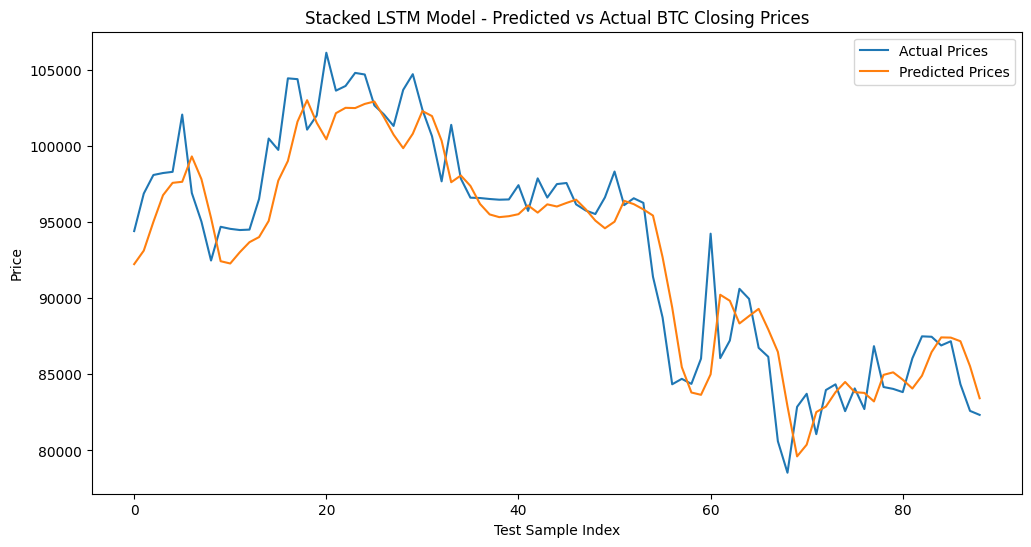

In [112]:
print("\nChecking some test predictions - Stacked LSTM\n")

for day_index in range(5):
    print(f"Sample {day_index+1}")
    print("Last 10 days input (closing price):", X_test_scaled[day_index].flatten())
    print(f"Actual BTC closing price      : {y_test_inverse[day_index]}")
    print(f"Predicted BTC closing price   : {y_test_pred_inverse[day_index]}\n")

# Plotting actual vs predicted prices on test set
plt.figure(figsize=(12, 6))
plt.plot(y_test_inverse, label='Actual Prices')
plt.plot(y_test_pred_inverse, label='Predicted Prices')
plt.title('Stacked LSTM Model - Predicted vs Actual BTC Closing Prices')
plt.xlabel('Test Sample Index')
plt.ylabel('Price')
plt.legend()
plt.show()

---

# Section: 6. Included Validation set Evaluation -  Transformer Model with varying Attention Blocks.ipynb


In [94]:
import pandas as pd
import matplotlib.pyplot as plt
import warnings as warn
warn.filterwarnings('ignore')
import numpy as np
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error
import math
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, GlobalAveragePooling1D, Attention, Concatenate, Lambda
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

In [ ]:
btc_cc = pd.read_csv('btc_usd(date&Close).csv')
btc_cc

Date         Close
0     2014-09-17    457.334015
1     2014-09-18    424.440002
2     2014-09-19    394.795990
3     2014-09-20    408.903992
4     2014-09-21    398.821014
...          ...           ...
3843  2025-03-26  86900.882812
3844  2025-03-27  87177.101562
3845  2025-03-28  84353.148438
3846  2025-03-29  82597.585938
3847  2025-03-30  82334.523438

[3848 rows x 2 columns]

In [95]:
btc_cc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3848 entries, 0 to 3847
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    3848 non-null   datetime64[ns]
 1   Close   3848 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 60.3 KB


Converting the strings in the Date column to datetime format

In [96]:
btc_cc['Date'] = pd.to_datetime(btc_cc['Date'])

# **Sliding window one-step ahead forecasting**

In [97]:
closing_prices = btc_cc['Close'].values
dates = btc_cc['Date'].values

# In this code 10 previous days will be used to predict the next day's price
window_size = 10

# Preparing the input (X), target (y), and target date using a sliding window
X, y, y_dates = [], [], []
for current_day_index in range(window_size, len(closing_prices)):
    ten_days_window = closing_prices[current_day_index - window_size:current_day_index]  # previous 10 days
    target_day = closing_prices[current_day_index]  # next day's price
    target_date = dates[current_day_index]  # next day's date

    X.append(ten_days_window)
    y.append(target_day)
    y_dates.append(target_date)

X = np.array(X)
y = np.array(y)
y_dates = np.array(y_dates)

print(f"Input shape (X): {X.shape}")
print(f"Target shape (y): {y.shape}")
print("Example input:", X[0])
print("Expected output:", y[0])

# Reshaping X
X = X.reshape((X.shape[0], X.shape[1], 1))
print(f"Reshaped input for Transformer: {X.shape}")

Input shape (X): (3838, 10)
Target shape (y): (3838,)
Example input: [457.33401489 424.44000244 394.79598999 408.9039917  398.8210144
 402.15200806 435.79098511 423.20498657 411.57400513 404.42498779]
Expected output: 399.5199890136719
Reshaped input for Transformer: (3838, 10, 1)


**DAta Splitting into Training and Testing**

In [98]:
#Define split dates
val_start_date = np.datetime64('2024-10-01')
test_start_date = np.datetime64('2025-01-01')

# Create masks for each period
train_mask = y_dates < val_start_date
val_mask = (y_dates >= val_start_date) & (y_dates < test_start_date)
test_mask = y_dates >= test_start_date

# Split the data
X_train, X_val, X_test = X[train_mask], X[val_mask], X[test_mask]
y_train, y_val, y_test = y[train_mask], y[val_mask], y[test_mask]

# Print shapes
print(f"\nTraining set:  X = {X_train.shape},  y = {y_train.shape}")
print(f"Validation set:  X = {X_val.shape},    y = {y_val.shape}")
print(f"Testing set:     X = {X_test.shape},   y = {y_test.shape}")


Training set:  X = (3657, 10, 1),  y = (3657,)
Validation set:  X = (92, 10, 1),    y = (92,)
Testing set:     X = (89, 10, 1),   y = (89,)


**Scaling the Data using Robust Scaler**

In [99]:
X_train_reshaped = X_train.reshape(-1, X_train.shape[-1])
X_val_reshaped = X_val.reshape(-1, X_val.shape[-1])
X_test_reshaped = X_test.reshape(-1, X_test.shape[-1])

x_scaler = RobustScaler()
X_train_scaled = x_scaler.fit_transform(X_train_reshaped)
X_val_scaled = x_scaler.transform(X_val_reshaped)
X_test_scaled = x_scaler.transform(X_test_reshaped)

X_train_scaled = X_train_scaled.reshape(X_train.shape)
X_val_scaled = X_val_scaled.reshape(X_val.shape)
X_test_scaled = X_test_scaled.reshape(X_test.shape)

y_scaler = RobustScaler()
y_train_scaled = y_scaler.fit_transform(y_train.reshape(-1, 1)).flatten()
y_val_scaled = y_scaler.transform(y_val.reshape(-1, 1)).flatten()
y_test_scaled = y_scaler.transform(y_test.reshape(-1, 1)).flatten()

In [100]:
X_train_scaled

array([[[-0.31046251],
        [-0.31163273],
        [-0.31268733],
        ...,
        [-0.31167666],
        [-0.31209044],
        [-0.31234477]],

       [[-0.31163273],
        [-0.31268733],
        [-0.31218543],
        ...,
        [-0.31209044],
        [-0.31234477],
        [-0.31251927]],

       [[-0.31268733],
        [-0.31218543],
        [-0.31254414],
        ...,
        [-0.31234477],
        [-0.31251927],
        [-0.31331399]],

       ...,

       [[ 1.86648567],
        [ 1.91240572],
        [ 1.92138922],
        ...,
        [ 1.91961642],
        [ 1.99211484],
        [ 2.01380325]],

       [[ 1.91240572],
        [ 1.92138922],
        [ 1.92857061],
        ...,
        [ 1.99211484],
        [ 2.01380325],
        [ 2.01725352]],

       [[ 1.92138922],
        [ 1.92857061],
        [ 1.9376022 ],
        ...,
        [ 2.01380325],
        [ 2.01725352],
        [ 2.00827626]]])

In [101]:
X_val_scaled

array([[[1.92857061],
        [1.9376022 ],
        [1.92625681],
        [1.96084217],
        [1.91961642],
        [1.99211484],
        [2.01380325],
        [2.01725352],
        [2.00827626],
        [1.92624611]],

       [[1.9376022 ],
        [1.92625681],
        [1.96084217],
        [1.91961642],
        [1.99211484],
        [2.01380325],
        [2.01725352],
        [2.00827626],
        [1.92624611],
        [1.83757446]],

       [[1.92625681],
        [1.96084217],
        [1.91961642],
        [1.99211484],
        [2.01380325],
        [2.01725352],
        [2.00827626],
        [1.92624611],
        [1.83757446],
        [1.83030914]],

       [[1.96084217],
        [1.91961642],
        [1.99211484],
        [2.01380325],
        [2.01725352],
        [2.00827626],
        [1.92624611],
        [1.83757446],
        [1.83030914],
        [1.83481361]],

       [[1.91961642],
        [1.99211484],
        [2.01380325],
        [2.01725352],
        [2.00827626],
  

In [ ]:
y_test_scaled

array([3.02455875, 3.11212517, 3.15544682, 3.16001827, 3.16281282,
       3.29637899, 3.11339683, 3.04669832, 2.95585347, 3.03455708,
       3.02977046, 3.02699642, 3.02799329, 3.09960209, 3.24052677,
       3.21399239, 3.38099363, 3.3790781 , 3.26129457, 3.29419891,
       3.44077259, 3.35228056, 3.36318065, 3.39368059, 3.3899596 ,
       3.31783171, 3.29671978, 3.26991476, 3.35406023, 3.39069276,
       3.30798312, 3.24590097, 3.14059449, 3.27250384, 3.14708424,
       3.1024912 , 3.10170508, 3.09942601, 3.09777085, 3.09839698,
       3.13167067, 3.07168236, 3.14758254, 3.10279012, 3.1342054 ,
       3.13673902, 3.0868594 , 3.07260352, 3.06430389, 3.10320689,
       3.16348636, 3.08510303, 3.10115354, 3.09036937, 2.9180222 ,
       2.82282886, 2.66704298, 2.67972134, 2.66796525, 2.7268455 ,
       3.01847495, 2.72804368, 2.76909265, 2.8898188 , 2.86632798,
       2.75207273, 2.73119982, 2.53408519, 2.46064792, 2.6143419 ,
       2.64487151, 2.5506132 , 2.65362924, 2.66690405, 2.60431

# **Transformer Regression Model**

In [102]:
#Building a Transformer-style model for Bitcoin price prediction using block-wise attention

def BTC_Transformer(input_shape, num_blocks):
    input_layer = Input(shape=input_shape)
    block_attention_outputs = []

    time_steps = input_shape[0]
    block_size = time_steps // num_blocks

    # Go through the input in blocks
    for block_index in range(num_blocks):
        start_index = block_index * block_size
        end_index = (block_index + 1) * block_size
        time_block = Lambda(lambda x: x[:, start_index:end_index, :])(input_layer)
        attention_output = Attention()([time_block, time_block])
        block_attention_outputs.append(attention_output)

    merged_blocks = Concatenate(axis=1)(block_attention_outputs)
    compressed_time_vector = GlobalAveragePooling1D()(merged_blocks)
    output_layer = Dense(1)(compressed_time_vector) #(eg: next BTC price)

    # Build and return the transformer model
    transformer_model = Model(inputs=input_layer, outputs=output_layer)
    return transformer_model

In [103]:
input_shape = X_train.shape[1:]
epochs = 50
batch_size = 32

**Transformer with one attention block**

Epoch 1/10
115/115 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.4940 - mae: 0.4875 - val_loss: 4.7460 - val_mae: 2.1309
Epoch 2/10
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.3612 - mae: 0.4535 - val_loss: 3.4655 - val_mae: 1.8175
Epoch 3/10
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.2623 - mae: 0.4099 - val_loss: 2.5442 - val_mae: 1.5546
Epoch 4/10
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1996 - mae: 0.3698 - val_loss: 1.8931 - val_mae: 1.3391
Epoch 5/10
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.1567 - mae: 0.3317 - val_loss: 1.4195 - val_mae: 1.1582
Epoch 6/10
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.1176 - mae: 0.2887 - val_loss: 1.0510 - val_mae: 0.9951
Epoch 7/10
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0865 - mae: 0.2488 - val_loss: 0.7748 - val_mae: 0.8528
Epoch 8/10
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0667 - mae: 0.2172 - val_loss: 0.5651 - val_mae: 0.7262
Epoch 9/10
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - lo

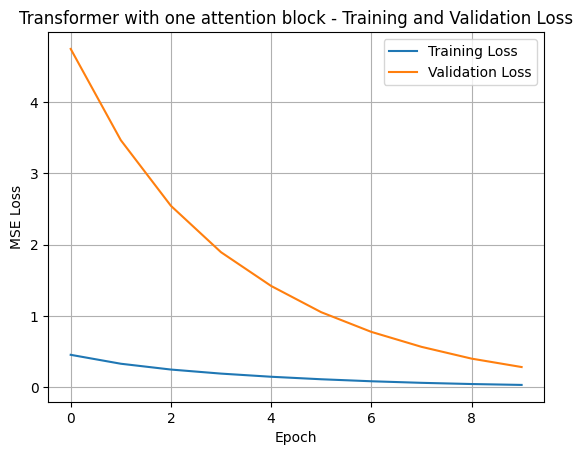

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step

 Metrics: Transformer with one attention block: Validation Set
MAE  - 14252.7173
MSE  - 223264638.1235
RMSE - 14942.0426
R²   - 0.0193
MAPE - 16.89%

 Metrics: Transformer with one attention block: Test Set
MAE  - 14539.5541
MSE  - 226906028.6176
RMSE - 15063.4003
R²   - -3.2111
MAPE - 15.39%


In [104]:
one_block_transformer = BTC_Transformer(input_shape, num_blocks=1)
one_block_transformer.compile(optimizer=Adam(learning_rate=0.001), loss='mse', metrics=['mae'])
history_one_block_transformer = one_block_transformer.fit(X_train_scaled, y_train_scaled, epochs=10, batch_size=32, validation_data=(X_val_scaled, y_val_scaled), verbose=1)

# Plotting training and validation loss over epochs
plt.plot(history_one_block_transformer.history['loss'], label='Training Loss')
plt.plot(history_one_block_transformer.history['val_loss'], label='Validation Loss')
plt.title('Transformer with one attention block - Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.legend()
plt.grid(True)
plt.show()

#saving the trained model
one_block_transformer.save("test2_one_block_transformer_model.keras")

#Predicting the closing price of BTC on validation and test sets
y_val_pred_scaled = one_block_transformer.predict(X_val_scaled).flatten()
y_test_pred_scaled = one_block_transformer.predict(X_test_scaled).flatten()

#Inverse scaling
y_val_inverse = y_scaler.inverse_transform(y_val_scaled.reshape(-1, 1)).flatten()
y_val_pred_inverse = y_scaler.inverse_transform(y_val_pred_scaled.reshape(-1, 1)).flatten()
y_test_inverse = y_scaler.inverse_transform(y_test_scaled.reshape(-1, 1)).flatten()
y_test_pred_inverse = y_scaler.inverse_transform(y_test_pred_scaled.reshape(-1, 1)).flatten()

print(f"\n Metrics: Transformer with one attention block: Validation Set")
mae_val = mean_absolute_error(y_val_inverse, y_val_pred_inverse)
print(f"MAE  - {mae_val:.4f}")
mse_val = mean_squared_error(y_val_inverse, y_val_pred_inverse)
print(f"MSE  - {mse_val:.4f}")
rmse_val = math.sqrt(mse_val)
print(f"RMSE - {rmse_val:.4f}")
r2_val = r2_score(y_val_inverse, y_val_pred_inverse)
print(f"R²   - {r2_val:.4f}")
mape_val = mean_absolute_percentage_error(y_val_inverse, y_val_pred_inverse) * 100
print(f"MAPE - {mape_val:.2f}%")

print(f"\n Metrics: Transformer with one attention block: Test Set")
mae_test = mean_absolute_error(y_test_inverse, y_test_pred_inverse)
print(f"MAE  - {mae_test:.4f}")
mse_test = mean_squared_error(y_test_inverse, y_test_pred_inverse)
print(f"MSE  - {mse_test:.4f}")
rmse_test = math.sqrt(mse_test)
print(f"RMSE - {rmse_test:.4f}")
r2_test = r2_score(y_test_inverse, y_test_pred_inverse)
print(f"R²   - {r2_test:.4f}")
mape_test = mean_absolute_percentage_error(y_test_inverse, y_test_pred_inverse) * 100
print(f"MAPE - {mape_test:.2f}%")


Some test predictions of Transformer with one attenton block

Sample 1
Last 10 days input (closing btc price): [3.05667313 3.04177783 3.18371879 3.20588594 3.08124079 3.02322938
 3.0587718  3.000652   2.96909598 2.99705804]
Actual BTC closing price      : 94419.7578125
Predicted BTC closing price   : 79680.609375

Sample 2
Last 10 days input (closing btc price): [3.04177783 3.18371879 3.20588594 3.08124079 3.02322938 3.0587718
 3.000652   2.96909598 2.99705804 3.03229752]
Actual BTC closing price      : 96886.875
Predicted BTC closing price   : 79635.484375

Sample 3
Last 10 days input (closing btc price): [3.18371879 3.20588594 3.08124079 3.02322938 3.0587718  3.000652
 2.96909598 2.99705804 3.03229752 3.12006644]
Actual BTC closing price      : 98107.4296875
Predicted BTC closing price   : 79815.3046875

Sample 4
Last 10 days input (closing btc price): [3.20588594 3.08124079 3.02322938 3.0587718  3.000652   2.96909598
 2.99705804 3.03229752 3.12006644 3.16348828]
Actual BTC closing 

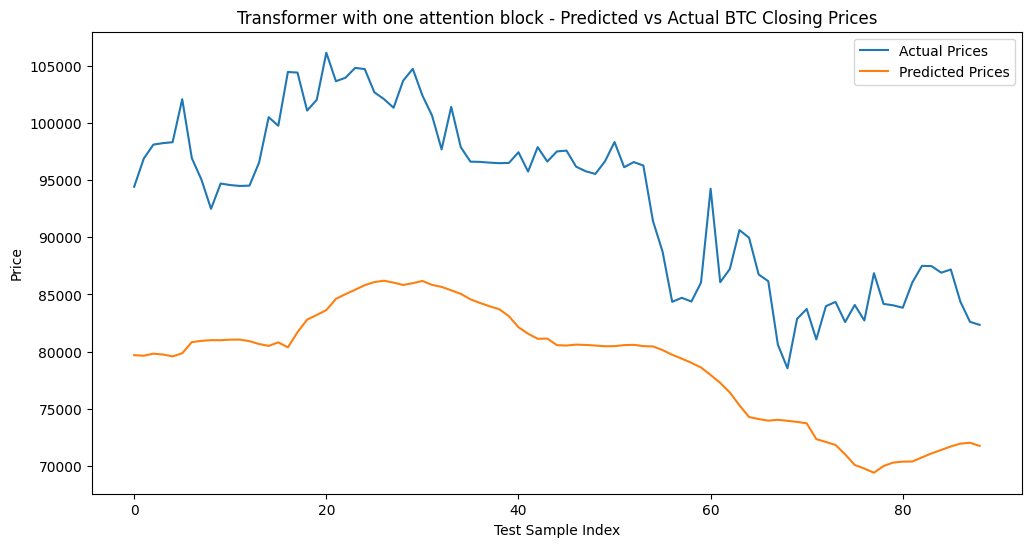

In [105]:
print("\nSome test predictions of Transformer with one attenton block\n")

for day_index in range(5):
    print(f"Sample {day_index+1}")
    print("Last 10 days input (closing btc price):", X_test_scaled[day_index].flatten())
    print(f"Actual BTC closing price      : {y_test_inverse[day_index]}")
    print(f"Predicted BTC closing price   : {y_test_pred_inverse[day_index]}\n")

# Plotting actual vs predicted prices on test set
plt.figure(figsize=(12, 6))
plt.plot(y_test_inverse, label='Actual Prices')
plt.plot(y_test_pred_inverse, label='Predicted Prices')
plt.title('Transformer with one attention block - Predicted vs Actual BTC Closing Prices')
plt.xlabel('Test Sample Index')
plt.ylabel('Price')
plt.legend()
plt.show()

**Transformer with two attention blocks**

Epoch 1/10
115/115 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.1321 - mae: 0.2559 - val_loss: 1.0346 - val_mae: 0.9912
Epoch 2/10
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0730 - mae: 0.2167 - val_loss: 0.5863 - val_mae: 0.7422
Epoch 3/10
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0468 - mae: 0.1803 - val_loss: 0.3426 - val_mae: 0.5636
Epoch 4/10
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0275 - mae: 0.1375 - val_loss: 0.1980 - val_mae: 0.4235
Epoch 5/10
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0149 - mae: 0.1011 - val_loss: 0.1096 - val_mae: 0.3076
Epoch 6/10
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0097 - mae: 0.0789 - val_loss: 0.0624 - val_mae: 0.2218
Epoch 7/10
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0056 - mae: 0.0567 - val_loss: 0.0365 - val_mae: 0.1616
Epoch 8/10
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0036 - mae: 0.0434 - val_loss: 0.0235 - val_mae: 0.1248
Epoch 9/10
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - lo

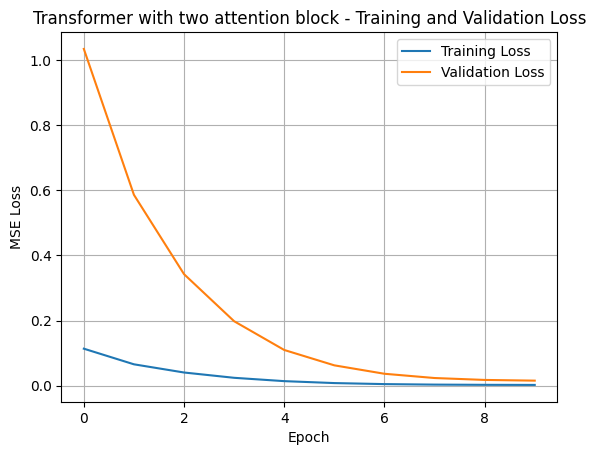

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 

 Metrics: Transformer with two attention blocks: Validation Set
MAE  - 2799.0895
MSE  - 12238294.0491
RMSE - 3498.3273
R²   - 0.9462
MAPE - 3.33%

 Metrics: Transformer with two attention blocks: Test Set
MAE  - 2487.1745
MSE  - 10965128.4802
RMSE - 3311.3635
R²   - 0.7965
MAPE - 2.70%


In [106]:
two_block_transformer = BTC_Transformer(input_shape, num_blocks=2)
two_block_transformer.compile(optimizer=Adam(learning_rate=0.001), loss='mse', metrics=['mae'])
history_two_block_transformer = two_block_transformer.fit(X_train_scaled, y_train_scaled, epochs=10, batch_size=32, validation_data=(X_val_scaled, y_val_scaled), verbose=1)

# Plotting training and validation loss over epochs
plt.plot(history_two_block_transformer.history['loss'], label='Training Loss')
plt.plot(history_two_block_transformer.history['val_loss'], label='Validation Loss')
plt.title('Transformer with two attention block - Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.legend()
plt.grid(True)
plt.show()

#saving the trained model
two_block_transformer.save("test2_two_block_transformer_model.keras")

#Predicting the closing price of BTC on validation and test sets
y_val_pred_scaled = two_block_transformer.predict(X_val_scaled).flatten()
y_test_pred_scaled = two_block_transformer.predict(X_test_scaled).flatten()

#Inverse scaling
y_val_inverse = y_scaler.inverse_transform(y_val_scaled.reshape(-1, 1)).flatten()
y_val_pred_inverse = y_scaler.inverse_transform(y_val_pred_scaled.reshape(-1, 1)).flatten()
y_test_inverse = y_scaler.inverse_transform(y_test_scaled.reshape(-1, 1)).flatten()
y_test_pred_inverse = y_scaler.inverse_transform(y_test_pred_scaled.reshape(-1, 1)).flatten()

print(f"\n Metrics: Transformer with two attention blocks: Validation Set")
mae_val = mean_absolute_error(y_val_inverse, y_val_pred_inverse)
print(f"MAE  - {mae_val:.4f}")
mse_val = mean_squared_error(y_val_inverse, y_val_pred_inverse)
print(f"MSE  - {mse_val:.4f}")
rmse_val = math.sqrt(mse_val)
print(f"RMSE - {rmse_val:.4f}")
r2_val = r2_score(y_val_inverse, y_val_pred_inverse)
print(f"R²   - {r2_val:.4f}")
mape_val = mean_absolute_percentage_error(y_val_inverse, y_val_pred_inverse) * 100
print(f"MAPE - {mape_val:.2f}%")

print(f"\n Metrics: Transformer with two attention blocks: Test Set")
mae_test = mean_absolute_error(y_test_inverse, y_test_pred_inverse)
print(f"MAE  - {mae_test:.4f}")
mse_test = mean_squared_error(y_test_inverse, y_test_pred_inverse)
print(f"MSE  - {mse_test:.4f}")
rmse_test = math.sqrt(mse_test)
print(f"RMSE - {rmse_test:.4f}")
r2_test = r2_score(y_test_inverse, y_test_pred_inverse)
print(f"R²   - {r2_test:.4f}")
mape_test = mean_absolute_percentage_error(y_test_inverse, y_test_pred_inverse) * 100
print(f"MAPE - {mape_test:.2f}%")


Some test predictions of Transformer with two attenton block

Sample 1
Last 10 days input (closing btc price): [3.05667313 3.04177783 3.18371879 3.20588594 3.08124079 3.02322938
 3.0587718  3.000652   2.96909598 2.99705804]
Actual BTC closing price      : 94419.7578125
Predicted BTC closing price   : 92759.5703125

Sample 2
Last 10 days input (closing btc price): [3.04177783 3.18371879 3.20588594 3.08124079 3.02322938 3.0587718
 3.000652   2.96909598 2.99705804 3.03229752]
Actual BTC closing price      : 96886.875
Predicted BTC closing price   : 92814.5625

Sample 3
Last 10 days input (closing btc price): [3.18371879 3.20588594 3.08124079 3.02322938 3.0587718  3.000652
 2.96909598 2.99705804 3.03229752 3.12006644]
Actual BTC closing price      : 98107.4296875
Predicted BTC closing price   : 93318.0546875

Sample 4
Last 10 days input (closing btc price): [3.20588594 3.08124079 3.02322938 3.0587718  3.000652   2.96909598
 2.99705804 3.03229752 3.12006644 3.16348828]
Actual BTC closing p

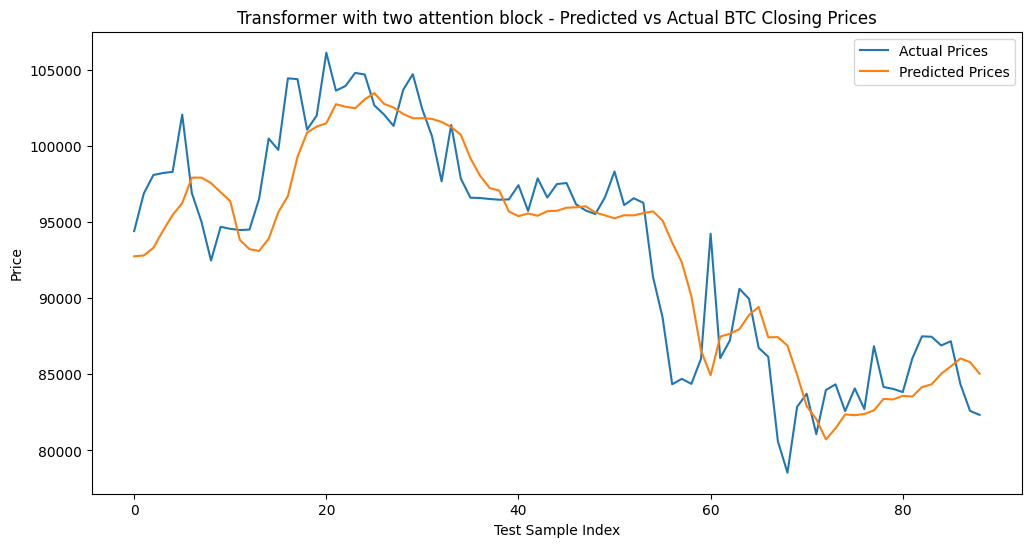

In [107]:
print("\nSome test predictions of Transformer with two attenton block\n")

for day_index in range(5):
    print(f"Sample {day_index+1}")
    print("Last 10 days input (closing btc price):", X_test_scaled[day_index].flatten())
    print(f"Actual BTC closing price      : {y_test_inverse[day_index]}")
    print(f"Predicted BTC closing price   : {y_test_pred_inverse[day_index]}\n")

# Plotting actual vs predicted prices on test set
plt.figure(figsize=(12, 6))
plt.plot(y_test_inverse, label='Actual Prices')
plt.plot(y_test_pred_inverse, label='Predicted Prices')
plt.title('Transformer with two attention block - Predicted vs Actual BTC Closing Prices')
plt.xlabel('Test Sample Index')
plt.ylabel('Price')
plt.legend()
plt.show()

**Transformer with three attention blocks**

Epoch 1/10
115/115 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0545 - mae: 0.1662 - val_loss: 0.3382 - val_mae: 0.5591
Epoch 2/10
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0238 - mae: 0.1246 - val_loss: 0.1568 - val_mae: 0.3713
Epoch 3/10
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0118 - mae: 0.0879 - val_loss: 0.0732 - val_mae: 0.2394
Epoch 4/10
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0058 - mae: 0.0588 - val_loss: 0.0372 - val_mae: 0.1591
Epoch 5/10
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0033 - mae: 0.0413 - val_loss: 0.0234 - val_mae: 0.1223
Epoch 6/10
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0027 - mae: 0.0332 - val_loss: 0.0187 - val_mae: 0.1074
Epoch 7/10
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0025 - mae: 0.0285 - val_loss: 0.0171 - val_mae: 0.1014
Epoch 8/10
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0023 - mae: 0.0274 - val_loss: 0.0167 - val_mae: 0.1000
Epoch 9/10
115/115 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - lo

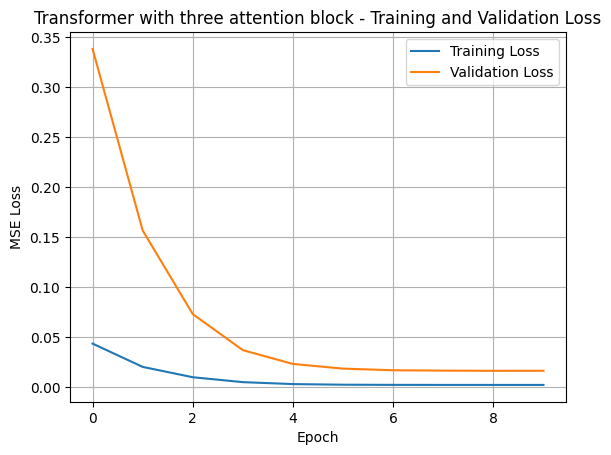

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 

 Metrics: Transformer with three attention blocks: Validation Set
MAE  - 2797.5470
MSE  - 13141451.7269
RMSE - 3625.1140
R²   - 0.9423
MAPE - 3.35%

 Metrics: Transformer with three attention blocks: Test Set
MAE  - 2493.8502
MSE  - 12281789.3169
RMSE - 3504.5384
R²   - 0.7721
MAPE - 2.72%


In [108]:
three_block_transformer = BTC_Transformer(input_shape, num_blocks=3)
three_block_transformer.compile(optimizer=Adam(learning_rate=0.001), loss='mse', metrics=['mae'])
history_three_block_transformer = three_block_transformer.fit(X_train_scaled, y_train_scaled, epochs=10, batch_size=32, validation_data=(X_val_scaled, y_val_scaled), verbose=1)

# Plotting training and validation loss over epochs
plt.plot(history_three_block_transformer.history['loss'], label='Training Loss')
plt.plot(history_three_block_transformer.history['val_loss'], label='Validation Loss')
plt.title('Transformer with three attention block - Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.legend()
plt.grid(True)
plt.show()

#saving the trained model
three_block_transformer.save("test2_three_block_transformer_model.keras")

#Predicting the closing price of BTC on validation and test sets
y_val_pred_scaled = three_block_transformer.predict(X_val_scaled).flatten()
y_test_pred_scaled = three_block_transformer.predict(X_test_scaled).flatten()

#Inverse scaling
y_val_inverse = y_scaler.inverse_transform(y_val_scaled.reshape(-1, 1)).flatten()
y_val_pred_inverse = y_scaler.inverse_transform(y_val_pred_scaled.reshape(-1, 1)).flatten()
y_test_inverse = y_scaler.inverse_transform(y_test_scaled.reshape(-1, 1)).flatten()
y_test_pred_inverse = y_scaler.inverse_transform(y_test_pred_scaled.reshape(-1, 1)).flatten()

print(f"\n Metrics: Transformer with three attention blocks: Validation Set")
mae_val = mean_absolute_error(y_val_inverse, y_val_pred_inverse)
print(f"MAE  - {mae_val:.4f}")
mse_val = mean_squared_error(y_val_inverse, y_val_pred_inverse)
print(f"MSE  - {mse_val:.4f}")
rmse_val = math.sqrt(mse_val)
print(f"RMSE - {rmse_val:.4f}")
r2_val = r2_score(y_val_inverse, y_val_pred_inverse)
print(f"R²   - {r2_val:.4f}")
mape_val = mean_absolute_percentage_error(y_val_inverse, y_val_pred_inverse) * 100
print(f"MAPE - {mape_val:.2f}%")

print(f"\n Metrics: Transformer with three attention blocks: Test Set")
mae_test = mean_absolute_error(y_test_inverse, y_test_pred_inverse)
print(f"MAE  - {mae_test:.4f}")
mse_test = mean_squared_error(y_test_inverse, y_test_pred_inverse)
print(f"MSE  - {mse_test:.4f}")
rmse_test = math.sqrt(mse_test)
print(f"RMSE - {rmse_test:.4f}")
r2_test = r2_score(y_test_inverse, y_test_pred_inverse)
print(f"R²   - {r2_test:.4f}")
mape_test = mean_absolute_percentage_error(y_test_inverse, y_test_pred_inverse) * 100
print(f"MAPE - {mape_test:.2f}%")


Some test predictions of Transformer with three attenton block

Sample 1
Last 10 days input (closing btc price): [3.05667313 3.04177783 3.18371879 3.20588594 3.08124079 3.02322938
 3.0587718  3.000652   2.96909598 2.99705804]
Actual BTC closing price      : 94419.7578125
Predicted BTC closing price   : 93785.5625

Sample 2
Last 10 days input (closing btc price): [3.04177783 3.18371879 3.20588594 3.08124079 3.02322938 3.0587718
 3.000652   2.96909598 2.99705804 3.03229752]
Actual BTC closing price      : 96886.875
Predicted BTC closing price   : 93106.4609375

Sample 3
Last 10 days input (closing btc price): [3.18371879 3.20588594 3.08124079 3.02322938 3.0587718  3.000652
 2.96909598 2.99705804 3.03229752 3.12006644]
Actual BTC closing price      : 98107.4296875
Predicted BTC closing price   : 93442.484375

Sample 4
Last 10 days input (closing btc price): [3.20588594 3.08124079 3.02322938 3.0587718  3.000652   2.96909598
 2.99705804 3.03229752 3.12006644 3.16348828]
Actual BTC closing 

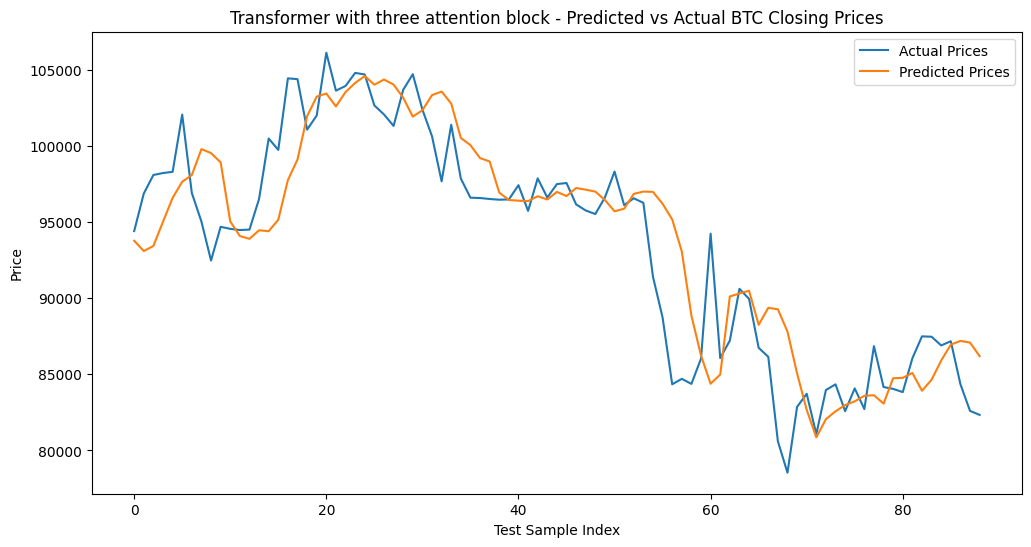

In [109]:
print("\nSome test predictions of Transformer with three attenton block\n")

for day_index in range(5):
    print(f"Sample {day_index+1}")
    print("Last 10 days input (closing btc price):", X_test_scaled[day_index].flatten())
    print(f"Actual BTC closing price      : {y_test_inverse[day_index]}")
    print(f"Predicted BTC closing price   : {y_test_pred_inverse[day_index]}\n")

# Plotting actual vs predicted prices on test set
plt.figure(figsize=(12, 6))
plt.plot(y_test_inverse, label='Actual Prices')
plt.plot(y_test_pred_inverse, label='Predicted Prices')
plt.title('Transformer with three attention block - Predicted vs Actual BTC Closing Prices')
plt.xlabel('Test Sample Index')
plt.ylabel('Price')
plt.legend()
plt.show()

**Transformer with four attention blocks**

Epoch 1/10
115/115 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 3.8484 - mae: 1.3585 - val_loss: 42.6011 - val_mae: 6.3893
Epoch 2/10
115/115 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 3.3920 - mae: 1.3042 - val_loss: 37.8901 - val_mae: 6.0217
Epoch 3/10
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.8450 - mae: 1.2248 - val_loss: 33.7057 - val_mae: 5.6758
Epoch 4/10
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.5638 - mae: 1.2047 - val_loss: 29.9398 - val_mae: 5.3458
Epoch 5/10
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.3309 - mae: 1.1747 - val_loss: 26.6314 - val_mae: 5.0387
Epoch 6/10
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2.1290 - mae: 1.1549 - val_loss: 23.6787 - val_mae: 4.7483
Epoch 7/10
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.9394 - mae: 1.1128 - val_loss: 21.1258 - val_mae: 4.4827
Epoch 8/10
115/115 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1.7497 - mae: 1.0703 - val_loss: 18.8542 - val_mae: 4.2328
Epoch 9/10
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/s

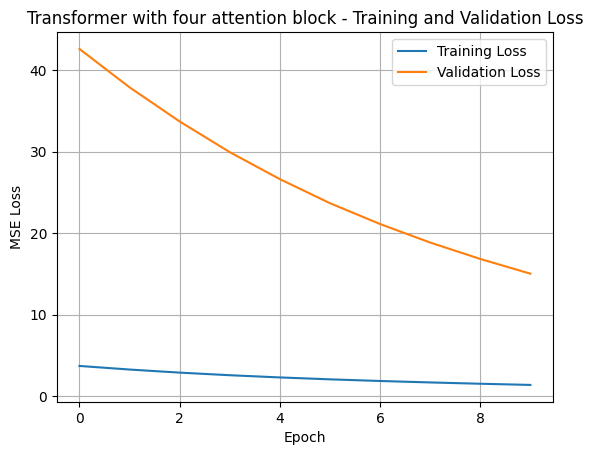

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 

 Metrics: Transformer with four attention blocks: Validation Set
MAE  - 106422.8752
MSE  - 11935809144.5110
RMSE - 109251.1288
R²   - -51.4298
MAPE - 126.32%

 Metrics: Transformer with four attention blocks: Test Set
MAE  - 123915.6857
MSE  - 15484517294.7506
RMSE - 124436.8004
R²   - -286.3724
MAPE - 132.39%


In [110]:
four_block_transformer = BTC_Transformer(input_shape, num_blocks=4)
four_block_transformer.compile(optimizer=Adam(learning_rate=0.001), loss='mse', metrics=['mae'])
history_four_block_transformer = four_block_transformer.fit(X_train_scaled, y_train_scaled, epochs=10, batch_size=32, validation_data=(X_val_scaled, y_val_scaled), verbose=1)

# Plotting training and validation loss over epochs
plt.plot(history_four_block_transformer.history['loss'], label='Training Loss')
plt.plot(history_four_block_transformer.history['val_loss'], label='Validation Loss')
plt.title('Transformer with four attention block - Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.legend()
plt.grid(True)
plt.show()

#saving the trained model
four_block_transformer.save("test2_four_block_transformer_model.keras")

#Predicting the closing price of BTC on validation and test sets
y_val_pred_scaled = four_block_transformer.predict(X_val_scaled).flatten()
y_test_pred_scaled = four_block_transformer.predict(X_test_scaled).flatten()

#Inverse scaling
y_val_inverse = y_scaler.inverse_transform(y_val_scaled.reshape(-1, 1)).flatten()
y_val_pred_inverse = y_scaler.inverse_transform(y_val_pred_scaled.reshape(-1, 1)).flatten()
y_test_inverse = y_scaler.inverse_transform(y_test_scaled.reshape(-1, 1)).flatten()
y_test_pred_inverse = y_scaler.inverse_transform(y_test_pred_scaled.reshape(-1, 1)).flatten()

print(f"\n Metrics: Transformer with four attention blocks: Validation Set")
mae_val = mean_absolute_error(y_val_inverse, y_val_pred_inverse)
print(f"MAE  - {mae_val:.4f}")
mse_val = mean_squared_error(y_val_inverse, y_val_pred_inverse)
print(f"MSE  - {mse_val:.4f}")
rmse_val = math.sqrt(mse_val)
print(f"RMSE - {rmse_val:.4f}")
r2_val = r2_score(y_val_inverse, y_val_pred_inverse)
print(f"R²   - {r2_val:.4f}")
mape_val = mean_absolute_percentage_error(y_val_inverse, y_val_pred_inverse) * 100
print(f"MAPE - {mape_val:.2f}%")

print(f"\n Metrics: Transformer with four attention blocks: Test Set")
mae_test = mean_absolute_error(y_test_inverse, y_test_pred_inverse)
print(f"MAE  - {mae_test:.4f}")
mse_test = mean_squared_error(y_test_inverse, y_test_pred_inverse)
print(f"MSE  - {mse_test:.4f}")
rmse_test = math.sqrt(mse_test)
print(f"RMSE - {rmse_test:.4f}")
r2_test = r2_score(y_test_inverse, y_test_pred_inverse)
print(f"R²   - {r2_test:.4f}")
mape_test = mean_absolute_percentage_error(y_test_inverse, y_test_pred_inverse) * 100
print(f"MAPE - {mape_test:.2f}%")


Some test predictions of Transformer with four attenton block

Sample 1
Last 10 days input (closing btc price): [3.05667313 3.04177783 3.18371879 3.20588594 3.08124079 3.02322938
 3.0587718  3.000652   2.96909598 2.99705804]
Actual BTC closing price      : 94419.7578125
Predicted BTC closing price   : -30632.58203125

Sample 2
Last 10 days input (closing btc price): [3.04177783 3.18371879 3.20588594 3.08124079 3.02322938 3.0587718
 3.000652   2.96909598 2.99705804 3.03229752]
Actual BTC closing price      : 96886.875
Predicted BTC closing price   : -29794.91015625

Sample 3
Last 10 days input (closing btc price): [3.18371879 3.20588594 3.08124079 3.02322938 3.0587718  3.000652
 2.96909598 2.99705804 3.03229752 3.12006644]
Actual BTC closing price      : 98107.4296875
Predicted BTC closing price   : -29759.7734375

Sample 4
Last 10 days input (closing btc price): [3.20588594 3.08124079 3.02322938 3.0587718  3.000652   2.96909598
 2.99705804 3.03229752 3.12006644 3.16348828]
Actual BTC 

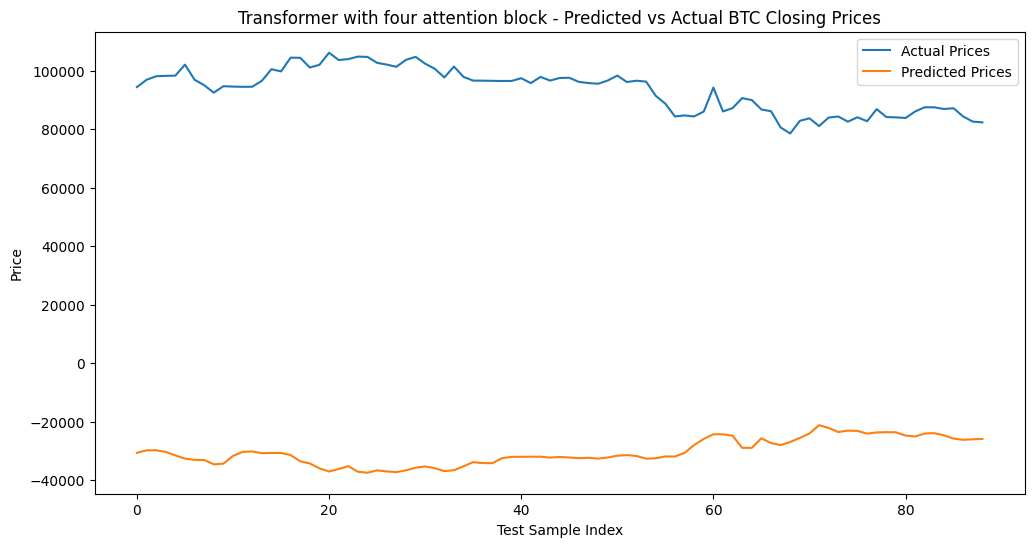

In [111]:
print("\nSome test predictions of Transformer with four attenton block\n")

for day_index in range(5):
    print(f"Sample {day_index+1}")
    print("Last 10 days input (closing btc price):", X_test_scaled[day_index].flatten())
    print(f"Actual BTC closing price      : {y_test_inverse[day_index]}")
    print(f"Predicted BTC closing price   : {y_test_pred_inverse[day_index]}\n")

# Plotting actual vs predicted prices on test set
plt.figure(figsize=(12, 6))
plt.plot(y_test_inverse, label='Actual Prices')
plt.plot(y_test_pred_inverse, label='Predicted Prices')
plt.title('Transformer with four attention block - Predicted vs Actual BTC Closing Prices')
plt.xlabel('Test Sample Index')
plt.ylabel('Price')
plt.legend()
plt.show()

**Transformer with five attention blocks**

Epoch 1/10
115/115 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1.6072 - mae: 0.8771 - val_loss: 17.1506 - val_mae: 4.0537
Epoch 2/10
115/115 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 1.3337 - mae: 0.8369 - val_loss: 14.3606 - val_mae: 3.7057
Epoch 3/10
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.0405 - mae: 0.7707 - val_loss: 12.0021 - val_mae: 3.3845
Epoch 4/10
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.9564 - mae: 0.7635 - val_loss: 10.0479 - val_mae: 3.0939
Epoch 5/10
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.7881 - mae: 0.7119 - val_loss: 8.4448 - val_mae: 2.8341
Epoch 6/10
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.7216 - mae: 0.6937 - val_loss: 7.1181 - val_mae: 2.6003
Epoch 7/10
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5754 - mae: 0.6292 - val_loss: 6.0047 - val_mae: 2.3870
Epoch 8/10
115/115 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.5069 - mae: 0.5932 - val_loss: 5.0716 - val_mae: 2.1929
Epoch 9/10
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 

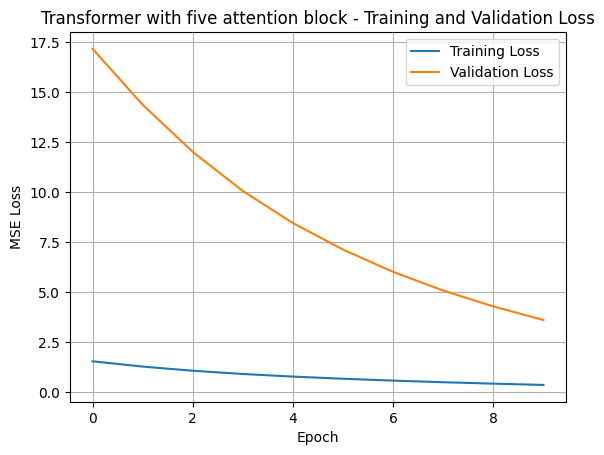

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 

 Metrics: Transformer with five attention blocks: Validation Set
MAE  - 52016.3219
MSE  - 2856540179.7049
RMSE - 53446.6106
R²   - -11.5478
MAPE - 61.67%

 Metrics: Transformer with five attention blocks: Test Set
MAE  - 59891.7560
MSE  - 3625973034.7261
RMSE - 60216.0530
R²   - -66.2933
MAPE - 63.92%


In [112]:
five_block_transformer = BTC_Transformer(input_shape, num_blocks=4)
five_block_transformer.compile(optimizer=Adam(learning_rate=0.001), loss='mse', metrics=['mae'])
history_five_block_transformer = five_block_transformer.fit(X_train_scaled, y_train_scaled, epochs=10, batch_size=32, validation_data=(X_val_scaled, y_val_scaled), verbose=1)

# Plotting training and validation loss over epochs
plt.plot(history_five_block_transformer.history['loss'], label='Training Loss')
plt.plot(history_five_block_transformer.history['val_loss'], label='Validation Loss')
plt.title('Transformer with five attention block - Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.legend()
plt.grid(True)
plt.show()

#saving the trained model
five_block_transformer.save("test2_five_block_transformer_model.keras")

#Predicting the closing price of BTC on validation and test sets
y_val_pred_scaled = five_block_transformer.predict(X_val_scaled).flatten()
y_test_pred_scaled = five_block_transformer.predict(X_test_scaled).flatten()

#Inverse scaling
y_val_inverse = y_scaler.inverse_transform(y_val_scaled.reshape(-1, 1)).flatten()
y_val_pred_inverse = y_scaler.inverse_transform(y_val_pred_scaled.reshape(-1, 1)).flatten()
y_test_inverse = y_scaler.inverse_transform(y_test_scaled.reshape(-1, 1)).flatten()
y_test_pred_inverse = y_scaler.inverse_transform(y_test_pred_scaled.reshape(-1, 1)).flatten()

print(f"\n Metrics: Transformer with five attention blocks: Validation Set")
mae_val = mean_absolute_error(y_val_inverse, y_val_pred_inverse)
print(f"MAE  - {mae_val:.4f}")
mse_val = mean_squared_error(y_val_inverse, y_val_pred_inverse)
print(f"MSE  - {mse_val:.4f}")
rmse_val = math.sqrt(mse_val)
print(f"RMSE - {rmse_val:.4f}")
r2_val = r2_score(y_val_inverse, y_val_pred_inverse)
print(f"R²   - {r2_val:.4f}")
mape_val = mean_absolute_percentage_error(y_val_inverse, y_val_pred_inverse) * 100
print(f"MAPE - {mape_val:.2f}%")

print(f"\n Metrics: Transformer with five attention blocks: Test Set")
mae_test = mean_absolute_error(y_test_inverse, y_test_pred_inverse)
print(f"MAE  - {mae_test:.4f}")
mse_test = mean_squared_error(y_test_inverse, y_test_pred_inverse)
print(f"MSE  - {mse_test:.4f}")
rmse_test = math.sqrt(mse_test)
print(f"RMSE - {rmse_test:.4f}")
r2_test = r2_score(y_test_inverse, y_test_pred_inverse)
print(f"R²   - {r2_test:.4f}")
mape_test = mean_absolute_percentage_error(y_test_inverse, y_test_pred_inverse) * 100
print(f"MAPE - {mape_test:.2f}%")


Some test predictions of Transformer with five attenton block

Sample 1
Last 10 days input (closing btc price): [3.05667313 3.04177783 3.18371879 3.20588594 3.08124079 3.02322938
 3.0587718  3.000652   2.96909598 2.99705804]
Actual BTC closing price      : 94419.7578125
Predicted BTC closing price   : 33690.89453125

Sample 2
Last 10 days input (closing btc price): [3.04177783 3.18371879 3.20588594 3.08124079 3.02322938 3.0587718
 3.000652   2.96909598 2.99705804 3.03229752]
Actual BTC closing price      : 96886.875
Predicted BTC closing price   : 33440.703125

Sample 3
Last 10 days input (closing btc price): [3.18371879 3.20588594 3.08124079 3.02322938 3.0587718  3.000652
 2.96909598 2.99705804 3.03229752 3.12006644]
Actual BTC closing price      : 98107.4296875
Predicted BTC closing price   : 33430.2109375

Sample 4
Last 10 days input (closing btc price): [3.20588594 3.08124079 3.02322938 3.0587718  3.000652   2.96909598
 2.99705804 3.03229752 3.12006644 3.16348828]
Actual BTC closi

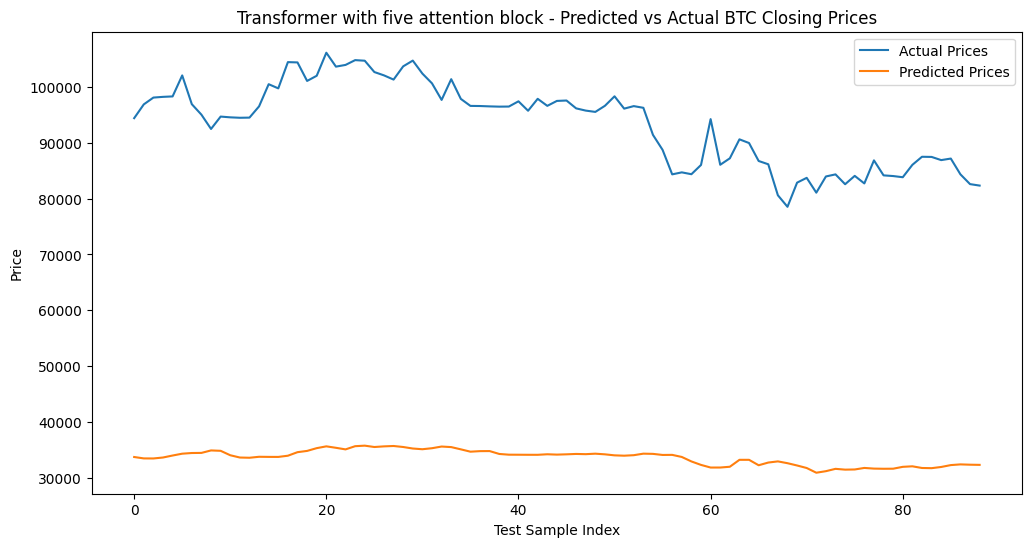

In [113]:
print("\nSome test predictions of Transformer with five attenton block\n")

for day_index in range(5):
    print(f"Sample {day_index+1}")
    print("Last 10 days input (closing btc price):", X_test_scaled[day_index].flatten())
    print(f"Actual BTC closing price      : {y_test_inverse[day_index]}")
    print(f"Predicted BTC closing price   : {y_test_pred_inverse[day_index]}\n")

# Plotting actual vs predicted prices on test set
plt.figure(figsize=(12, 6))
plt.plot(y_test_inverse, label='Actual Prices')
plt.plot(y_test_pred_inverse, label='Predicted Prices')
plt.title('Transformer with five attention block - Predicted vs Actual BTC Closing Prices')
plt.xlabel('Test Sample Index')
plt.ylabel('Price')
plt.legend()
plt.show()